In [1]:
# Install qulacs if not already installed
!pip install qulacs numpy matplotlib scikit-learn

print("✓ Installation complete")

✓ Installation complete


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qulacs import QuantumState, QuantumCircuit, Observable
from qulacs.gate import DenseMatrix, X, Y, Z, H, RX, RY, RZ, CNOT
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("✓ All imports successful")
print(f"NumPy version: {np.__version__}")

✓ All imports successful
NumPy version: 2.2.6


In [3]:
# Load Iris dataset and select 2 classes for binary classification
iris = load_iris()
X = iris.data[iris.target != 2]  # Remove class 2 (Virginica)
y = iris.target[iris.target != 2]  # Keep classes 0 and 1

# Use only 2 features for simplicity (4 qubits needed otherwise)
X = X[:, :2]  

print(f"Dataset shape: {X.shape}")
print(f"Classes: {np.unique(y)}")
print(f"Class distribution: {np.bincount(y)}")

Dataset shape: (100, 2)
Classes: [0 1]
Class distribution: [50 50]


In [4]:
# Train-validation-test split (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Normalize features to [0, π] range for angle encoding
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Map to [0, π]
X_train_scaled = (X_train_scaled - X_train_scaled.min()) / (X_train_scaled.max() - X_train_scaled.min()) * np.pi
X_val_scaled = (X_val_scaled - X_val_scaled.min()) / (X_val_scaled.max() - X_val_scaled.min()) * np.pi
X_test_scaled = (X_test_scaled - X_test_scaled.min()) / (X_test_scaled.max() - X_test_scaled.min()) * np.pi

print(f"Training: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")
print(f"Split ratio: {len(X_train)/len(X):.1%} / {len(X_val)/len(X):.1%} / {len(X_test)/len(X):.1%}")

Training: 60, Validation: 20, Test: 20
Split ratio: 60.0% / 20.0% / 20.0%


In [5]:
# Cell 5

# Circuit configuration
n_qubits = 4  # Number of qubits
n_layers = 3  # Depth of variational circuit
n_features = X_train_scaled.shape[1]  # Input features (2)

# Calculate total parameters needed
n_params = n_qubits * n_layers * 3  # 3 rotations (RX, RY, RZ) per qubit per layer

print(f"Qubits: {n_qubits}")
print(f"Layers: {n_layers}")
print(f"Total trainable parameters: {n_params}")
print(f"Input features: {n_features}")

Qubits: 4
Layers: 3
Total trainable parameters: 36
Input features: 2


In [6]:
# Cell 6

def encode_data(circuit, x, n_qubits):
    """
    Encode classical data into quantum state using angle encoding.
    Maps features to rotation angles on qubits.
    """
    # Encode first 2 features directly
    for i in range(min(len(x), n_qubits)):
        circuit.add_RY_gate(i, x[i])
    
    # If we have more qubits than features, apply Hadamard for superposition
    for i in range(len(x), n_qubits):
        circuit.add_H_gate(i)
    
    return circuit

# Test encoding
test_circuit = QuantumCircuit(n_qubits)
test_circuit = encode_data(test_circuit, X_train_scaled[0], n_qubits)
print(f"✓ Encoding function created")
print(f"  Gates in encoding layer: {test_circuit.get_gate_count()}")

✓ Encoding function created
  Gates in encoding layer: 4


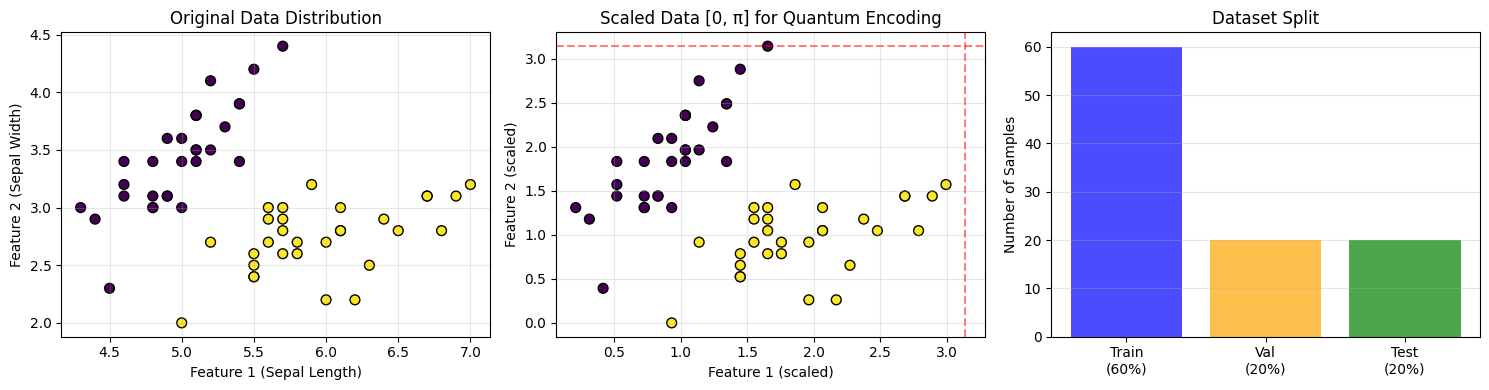

✓ Data ready for quantum encoding
  Train mean: 1.425, std: 0.670
  Feature range: [0.000, 3.142]


In [7]:
# Cell 7

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Original data distribution
axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
axes[0].set_xlabel('Feature 1 (Sepal Length)')
axes[0].set_ylabel('Feature 2 (Sepal Width)')
axes[0].set_title('Original Data Distribution')
axes[0].grid(True, alpha=0.3)

# Plot 2: Scaled data [0, π]
axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
axes[1].set_xlabel('Feature 1 (scaled)')
axes[1].set_ylabel('Feature 2 (scaled)')
axes[1].set_title(f'Scaled Data [0, π] for Quantum Encoding')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=np.pi, color='r', linestyle='--', alpha=0.5, label='π')
axes[1].axvline(x=np.pi, color='r', linestyle='--', alpha=0.5)

# Plot 3: Data split sizes
split_sizes = [len(X_train), len(X_val), len(X_test)]
axes[2].bar(['Train\n(60%)', 'Val\n(20%)', 'Test\n(20%)'], split_sizes, color=['blue', 'orange', 'green'], alpha=0.7)
axes[2].set_ylabel('Number of Samples')
axes[2].set_title('Dataset Split')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"✓ Data ready for quantum encoding")
print(f"  Train mean: {X_train_scaled.mean():.3f}, std: {X_train_scaled.std():.3f}")
print(f"  Feature range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")

In [8]:
# Cell 8

# Initialize parameters with small random values (Xavier-like initialization)
np.random.seed(42)
params = np.random.uniform(-np.pi, np.pi, size=n_params)

print(f"✓ Initialized {n_params} trainable parameters")
print(f"  Shape: {params.shape}")
print(f"  Range: [{params.min():.3f}, {params.max():.3f}]")
print(f"  Mean: {params.mean():.3f}, Std: {params.std():.3f}")
print(f"\n  First 10 params: {params[:10]}")

✓ Initialized 36 trainable parameters
  Shape: (36,)
  Range: [-3.012, 2.953]
  Mean: -0.223, Std: 1.874

  First 10 params: [-0.78828768  2.83192151  1.45766093  0.61988954 -2.16129862 -2.16145018
 -2.77664256  2.30075258  0.63532436  1.30735856]


In [9]:
# Cell 9

def create_qnn_circuit(x, params, n_qubits, n_layers):
    """
    Create parameterized quantum circuit:
    1. Encode data
    2. Apply variational layers (RX, RY, RZ + entanglement)
    3. Return circuit for measurement
    """
    circuit = QuantumCircuit(n_qubits)
    
    # Step 1: Encode input data
    circuit = encode_data(circuit, x, n_qubits)
    
    # Step 2: Variational layers
    param_idx = 0
    for layer in range(n_layers):
        # Rotation gates (trainable)
        for qubit in range(n_qubits):
            circuit.add_RX_gate(qubit, params[param_idx])
            circuit.add_RY_gate(qubit, params[param_idx + 1])
            circuit.add_RZ_gate(qubit, params[param_idx + 2])
            param_idx += 3
        
        # Entanglement layer (CNOT ladder)
        for qubit in range(n_qubits - 1):
            circuit.add_CNOT_gate(qubit, qubit + 1)
    
    return circuit

# Test circuit creation
test_qc = create_qnn_circuit(X_train_scaled[0], params, n_qubits, n_layers)
print(f"✓ QNN circuit builder created")
print(f"  Total gates: {test_qc.get_gate_count()}")

✓ QNN circuit builder created
  Total gates: 49


In [10]:
# Cell 10

def predict(x, params, n_qubits, n_layers):
    """
    Run quantum circuit and measure expectation value.
    Uses Pauli-Z measurement on first qubit for classification.
    Returns value in [-1, 1], map to classes {0, 1}.
    """
    # Create and run circuit
    circuit = create_qnn_circuit(x, params, n_qubits, n_layers)
    state = QuantumState(n_qubits)
    state.set_zero_state()
    circuit.update_quantum_state(state)
    
    # Measure <Z_0> on first qubit
    observable = Observable(n_qubits)
    observable.add_operator(1.0, "Z 0")  # Pauli-Z on qubit 0
    
    expectation = observable.get_expectation_value(state)
    return expectation

# Test prediction
test_pred = predict(X_train_scaled[0], params, n_qubits, n_layers)
print(f"✓ Prediction function created")
print(f"  Test expectation value: {test_pred:.4f}")
print(f"  Maps to class: {int(test_pred > 0)}")

✓ Prediction function created
  Test expectation value: 0.2478
  Maps to class: 1


In [11]:
# Cell 11

def compute_loss(params, X_batch, y_batch, n_qubits, n_layers):
    """
    Mean Squared Error loss for quantum classifier.
    Maps labels: 0 -> -1, 1 -> +1 to match expectation value range.
    """
    predictions = []
    targets = 2 * y_batch - 1  # Map {0,1} to {-1,+1}
    
    for i in range(len(X_batch)):
        pred = predict(X_batch[i], params, n_qubits, n_layers)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    loss = np.mean((predictions - targets) ** 2)
    
    return loss

# Test loss computation
sample_loss = compute_loss(params, X_train_scaled[:5], y_train[:5], n_qubits, n_layers)
print(f"✓ Loss function created")
print(f"  Initial loss (5 samples): {sample_loss:.4f}")

✓ Loss function created
  Initial loss (5 samples): 1.3611


In [12]:
# Cell 12

def parameter_shift_gradient(params, X_batch, y_batch, n_qubits, n_layers, shift=np.pi/2):
    """
    Compute exact gradients using parameter-shift rule.
    For gate R(θ): ∂L/∂θ = [L(θ+π/2) - L(θ-π/2)] / 2
    """
    gradients = np.zeros_like(params)
    
    for i in range(len(params)):
        # Shift parameter forward
        params_plus = params.copy()
        params_plus[i] += shift
        loss_plus = compute_loss(params_plus, X_batch, y_batch, n_qubits, n_layers)
        
        # Shift parameter backward
        params_minus = params.copy()
        params_minus[i] -= shift
        loss_minus = compute_loss(params_minus, X_batch, y_batch, n_qubits, n_layers)
        
        # Compute gradient
        gradients[i] = (loss_plus - loss_minus) / 2.0
    
    return gradients

print(f"✓ Parameter-shift gradient function created")
print(f"  Will compute {n_params} exact gradients per step")

✓ Parameter-shift gradient function created
  Will compute 36 exact gradients per step


In [13]:
# Cell 13

def finite_difference_gradient(params, X_batch, y_batch, n_qubits, n_layers, epsilon=1e-4):
    """
    Compute approximate gradients using finite differences.
    Faster than parameter-shift, works with Adam optimizer.
    ∂L/∂θ ≈ [L(θ+ε) - L(θ)] / ε
    """
    gradients = np.zeros_like(params)
    loss_current = compute_loss(params, X_batch, y_batch, n_qubits, n_layers)
    
    for i in range(len(params)):
        params_shifted = params.copy()
        params_shifted[i] += epsilon
        loss_shifted = compute_loss(params_shifted, X_batch, y_batch, n_qubits, n_layers)
        
        gradients[i] = (loss_shifted - loss_current) / epsilon
    
    return gradients

print(f"✓ Finite difference gradient function created")
print(f"  Epsilon: {1e-4}")

✓ Finite difference gradient function created
  Epsilon: 0.0001


In [14]:
# Cell 14

class AdamOptimizer:
    """
    Adam optimizer for quantum circuit parameters.
    Adaptive learning rates with momentum.
    """
    def __init__(self, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None  # First moment
        self.v = None  # Second moment
        self.t = 0     # Time step
    
    def step(self, params, gradients):
        """Update parameters using Adam update rule."""
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)
        
        self.t += 1
        
        # Update biased first/second moments
        self.m = self.beta1 * self.m + (1 - self.beta1) * gradients
        self.v = self.beta2 * self.v + (1 - self.beta2) * (gradients ** 2)
        
        # Bias correction
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        
        # Update parameters
        params = params - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        
        return params

print(f"✓ Adam optimizer created")
print(f"  Learning rate: 0.01, β1: 0.9, β2: 0.999")

✓ Adam optimizer created
  Learning rate: 0.01, β1: 0.9, β2: 0.999


In [15]:
# Cell 15

class SGDOptimizer:
    """
    Stochastic Gradient Descent optimizer.
    Simple and stable for parameter-shift gradients.
    """
    def __init__(self, learning_rate=0.1):
        self.lr = learning_rate
    
    def step(self, params, gradients):
        """Update parameters using gradient descent."""
        params = params - self.lr * gradients
        return params

print(f"✓ SGD optimizer created")
print(f"  Learning rate: 0.1")

✓ SGD optimizer created
  Learning rate: 0.1


In [16]:
# Cell 16

# Training hyperparameters
n_epochs = 50
batch_size = 10
learning_rate_adam = 0.01
learning_rate_sgd = 0.1

# Gradient computation steps (editable for benchmarking)
n_samples_per_gradient = 5  # Number of samples to compute gradient on each step

# Initialize optimizers
adam_opt = AdamOptimizer(learning_rate=learning_rate_adam)
sgd_opt = SGDOptimizer(learning_rate=learning_rate_sgd)

print(f"✓ Training configuration set")
print(f"  Epochs: {n_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Samples per gradient: {n_samples_per_gradient}")
print(f"  Adam LR: {learning_rate_adam}, SGD LR: {learning_rate_sgd}")

✓ Training configuration set
  Epochs: 50
  Batch size: 10
  Samples per gradient: 5
  Adam LR: 0.01, SGD LR: 0.1


In [17]:
# Cell 17

def evaluate_accuracy(params, X, y, n_qubits, n_layers):
    """
    Compute classification accuracy.
    Predict on all samples, threshold at 0, compare to true labels.
    """
    correct = 0
    predictions = []
    
    for i in range(len(X)):
        pred_value = predict(X[i], params, n_qubits, n_layers)
        pred_class = int(pred_value > 0)  # Threshold at 0
        predictions.append(pred_class)
        
        if pred_class == y[i]:
            correct += 1
    
    accuracy = correct / len(X)
    return accuracy, np.array(predictions)

# Test initial accuracy
init_acc_train, _ = evaluate_accuracy(params, X_train_scaled[:10], y_train[:10], n_qubits, n_layers)
print(f"✓ Accuracy function created")
print(f"  Initial accuracy (10 samples): {init_acc_train:.2%}")

✓ Accuracy function created
  Initial accuracy (10 samples): 50.00%


In [18]:
# Cell 18

def train_adam(params_init, X_train, y_train, X_val, y_val, n_epochs, n_samples_per_gradient):
    """
    Train QNN using Adam optimizer with finite difference gradients.
    """
    params = params_init.copy()
    optimizer = AdamOptimizer(learning_rate=learning_rate_adam)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    print("Starting Adam training...")
    
    for epoch in range(n_epochs):
        # Shuffle training data
        indices = np.random.permutation(len(X_train))
        
        epoch_loss = 0
        n_batches = 0
        
        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train[batch_idx][:n_samples_per_gradient]
            y_batch = y_train[batch_idx][:n_samples_per_gradient]
            
            # Compute gradients
            grads = finite_difference_gradient(params, X_batch, y_batch, n_qubits, n_layers)
            
            # Update parameters
            params = optimizer.step(params, grads)
            
            # Track loss
            loss = compute_loss(params, X_batch, y_batch, n_qubits, n_layers)
            epoch_loss += loss
            n_batches += 1
        
        # Evaluate on full sets
        train_loss = compute_loss(params, X_train[:20], y_train[:20], n_qubits, n_layers)
        val_loss = compute_loss(params, X_val, y_val, n_qubits, n_layers)
        train_acc, _ = evaluate_accuracy(params, X_train, y_train, n_qubits, n_layers)
        val_acc, _ = evaluate_accuracy(params, X_val, y_val, n_qubits, n_layers)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}")
    
    return params, history

print(f"✓ Adam training function ready")

✓ Adam training function ready


In [19]:
# Cell 19

def train_parameter_shift(params_init, X_train, y_train, X_val, y_val, n_epochs, n_samples_per_gradient):
    """
    Train QNN using SGD optimizer with exact parameter-shift gradients.
    """
    params = params_init.copy()
    optimizer = SGDOptimizer(learning_rate=learning_rate_sgd)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    print("Starting Parameter-Shift training...")
    
    for epoch in range(n_epochs):
        # Shuffle training data
        indices = np.random.permutation(len(X_train))
        
        epoch_loss = 0
        n_batches = 0
        
        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train[batch_idx][:n_samples_per_gradient]
            y_batch = y_train[batch_idx][:n_samples_per_gradient]
            
            # Compute exact gradients
            grads = parameter_shift_gradient(params, X_batch, y_batch, n_qubits, n_layers)
            
            # Update parameters
            params = optimizer.step(params, grads)
            
            # Track loss
            loss = compute_loss(params, X_batch, y_batch, n_qubits, n_layers)
            epoch_loss += loss
            n_batches += 1
        
        # Evaluate on full sets
        train_loss = compute_loss(params, X_train[:20], y_train[:20], n_qubits, n_layers)
        val_loss = compute_loss(params, X_val, y_val, n_qubits, n_layers)
        train_acc, _ = evaluate_accuracy(params, X_train, y_train, n_qubits, n_layers)
        val_acc, _ = evaluate_accuracy(params, X_val, y_val, n_qubits, n_layers)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}")
    
    return params, history

print(f"✓ Parameter-shift training function ready")

✓ Parameter-shift training function ready


In [20]:
# Cell 20

from tqdm import tqdm

def train_adam_with_progress(params_init, X_train, y_train, X_val, y_val, n_epochs, n_samples_per_gradient):
    """
    Train QNN using Adam optimizer with Keras-style progress bar.
    """
    params = params_init.copy()
    optimizer = AdamOptimizer(learning_rate=learning_rate_adam)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    print("🚀 Starting Adam Training\n")
    
    # Epoch progress bar
    for epoch in range(n_epochs):
        indices = np.random.permutation(len(X_train))
        epoch_loss = 0
        n_batches = len(X_train) // batch_size
        
        # Batch progress bar
        pbar = tqdm(range(0, len(X_train), batch_size), 
                    desc=f"Epoch {epoch+1}/{n_epochs}",
                    ncols=100,
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')
        
        for i in pbar:
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train[batch_idx][:n_samples_per_gradient]
            y_batch = y_train[batch_idx][:n_samples_per_gradient]
            
            # Compute gradients and update
            grads = finite_difference_gradient(params, X_batch, y_batch, n_qubits, n_layers)
            params = optimizer.step(params, grads)
            
            loss = compute_loss(params, X_batch, y_batch, n_qubits, n_layers)
            epoch_loss += loss
            
            # Update progress bar
            pbar.set_postfix({'loss': f'{loss:.4f}'})
        
        # Evaluate
        train_loss = compute_loss(params, X_train[:20], y_train[:20], n_qubits, n_layers)
        val_loss = compute_loss(params, X_val, y_val, n_qubits, n_layers)
        train_acc, _ = evaluate_accuracy(params, X_train, y_train, n_qubits, n_layers)
        val_acc, _ = evaluate_accuracy(params, X_val, y_val, n_qubits, n_layers)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"  ├─ Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Acc: {train_acc:.2%} - Val Acc: {val_acc:.2%}\n")
    
    return params, history

print(f"✓ Adam training with progress bar ready")

✓ Adam training with progress bar ready


In [21]:
# Cell 21

def train_parameter_shift_with_progress(params_init, X_train, y_train, X_val, y_val, n_epochs, n_samples_per_gradient):
    """
    Train QNN using Parameter-Shift with Keras-style progress bar.
    """
    params = params_init.copy()
    optimizer = SGDOptimizer(learning_rate=learning_rate_sgd)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    print("⚛️  Starting Parameter-Shift Training\n")
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(len(X_train))
        epoch_loss = 0
        n_batches = len(X_train) // batch_size
        
        pbar = tqdm(range(0, len(X_train), batch_size), 
                    desc=f"Epoch {epoch+1}/{n_epochs}",
                    ncols=100,
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')
        
        for i in pbar:
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train[batch_idx][:n_samples_per_gradient]
            y_batch = y_train[batch_idx][:n_samples_per_gradient]
            
            # Exact gradients
            grads = parameter_shift_gradient(params, X_batch, y_batch, n_qubits, n_layers)
            params = optimizer.step(params, grads)
            
            loss = compute_loss(params, X_batch, y_batch, n_qubits, n_layers)
            epoch_loss += loss
            
            pbar.set_postfix({'loss': f'{loss:.4f}'})
        
        # Evaluate
        train_loss = compute_loss(params, X_train[:20], y_train[:20], n_qubits, n_layers)
        val_loss = compute_loss(params, X_val, y_val, n_qubits, n_layers)
        train_acc, _ = evaluate_accuracy(params, X_train, y_train, n_qubits, n_layers)
        val_acc, _ = evaluate_accuracy(params, X_val, y_val, n_qubits, n_layers)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"  ├─ Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Acc: {train_acc:.2%} - Val Acc: {val_acc:.2%}\n")
    
    return params, history

print(f"✓ Parameter-shift training with progress bar ready")

✓ Parameter-shift training with progress bar ready


In [22]:
# Cell 22

import time

# Reset parameters for fair comparison
params_adam = np.random.uniform(-np.pi, np.pi, size=n_params)
np.random.seed(42)

# Time the training
start_time = time.time()

params_adam_trained, history_adam = train_adam_with_progress(
    params_adam, 
    X_train_scaled, 
    y_train, 
    X_val_scaled, 
    y_val, 
    n_epochs, 
    n_samples_per_gradient
)

adam_time = time.time() - start_time

print(f"\n✅ Adam Training Complete!")
print(f"   Time: {adam_time:.2f}s")
print(f"   Final Train Acc: {history_adam['train_acc'][-1]:.2%}")
print(f"   Final Val Acc: {history_adam['val_acc'][-1]:.2%}")

🚀 Starting Adam Training



Epoch 1/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 1.1769 - Val Loss: 1.2863 - Acc: 46.67% - Val Acc: 30.00%



Epoch 2/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 1.0670 - Val Loss: 1.1738 - Acc: 50.00% - Val Acc: 35.00%



Epoch 3/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.9792 - Val Loss: 1.0757 - Acc: 51.67% - Val Acc: 45.00%



Epoch 4/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.9090 - Val Loss: 0.9974 - Acc: 53.33% - Val Acc: 45.00%



Epoch 5/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.8434 - Val Loss: 0.9323 - Acc: 60.00% - Val Acc: 50.00%



Epoch 6/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.7698 - Val Loss: 0.8657 - Acc: 68.33% - Val Acc: 55.00%



Epoch 7/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.6833 - Val Loss: 0.7850 - Acc: 78.33% - Val Acc: 75.00%



Epoch 8/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.5912 - Val Loss: 0.6968 - Acc: 93.33% - Val Acc: 95.00%



Epoch 9/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.5057 - Val Loss: 0.6117 - Acc: 98.33% - Val Acc: 95.00%



Epoch 10/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.4416 - Val Loss: 0.5464 - Acc: 100.00% - Val Acc: 90.00%



Epoch 11/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.3943 - Val Loss: 0.4967 - Acc: 100.00% - Val Acc: 90.00%



Epoch 12/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.3620 - Val Loss: 0.4607 - Acc: 100.00% - Val Acc: 90.00%



Epoch 13/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.3361 - Val Loss: 0.4325 - Acc: 100.00% - Val Acc: 90.00%



Epoch 14/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.3175 - Val Loss: 0.4113 - Acc: 100.00% - Val Acc: 90.00%



Epoch 15/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.3024 - Val Loss: 0.3933 - Acc: 100.00% - Val Acc: 90.00%



Epoch 16/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2914 - Val Loss: 0.3807 - Acc: 100.00% - Val Acc: 95.00%



Epoch 17/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2829 - Val Loss: 0.3717 - Acc: 100.00% - Val Acc: 95.00%



Epoch 18/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2777 - Val Loss: 0.3649 - Acc: 100.00% - Val Acc: 90.00%



Epoch 19/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2722 - Val Loss: 0.3569 - Acc: 100.00% - Val Acc: 90.00%



Epoch 20/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2665 - Val Loss: 0.3485 - Acc: 100.00% - Val Acc: 90.00%



Epoch 21/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]

  ├─ Loss: 0.2580 - Val Loss: 0.3366 - Acc: 100.00% - Val Acc: 95.00%


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2550 - Val Loss: 0.3303 - Acc: 100.00% - Val Acc: 95.00%



Epoch 23/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2533 - Val Loss: 0.3261 - Acc: 100.00% - Val Acc: 95.00%



Epoch 24/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2478 - Val Loss: 0.3215 - Acc: 100.00% - Val Acc: 95.00%



Epoch 25/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2606 - Val Loss: 0.3319 - Acc: 100.00% - Val Acc: 85.00%



Epoch 26/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2461 - Val Loss: 0.3157 - Acc: 100.00% - Val Acc: 95.00%



Epoch 27/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2373 - Val Loss: 0.3044 - Acc: 100.00% - Val Acc: 95.00%



Epoch 28/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2350 - Val Loss: 0.2995 - Acc: 100.00% - Val Acc: 95.00%



Epoch 29/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]

  ├─ Loss: 0.2328 - Val Loss: 0.2966 - Acc: 100.00% - Val Acc: 95.00%


Epoch 30/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2323 - Val Loss: 0.2949 - Acc: 100.00% - Val Acc: 95.00%



Epoch 31/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2304 - Val Loss: 0.2901 - Acc: 100.00% - Val Acc: 95.00%



Epoch 32/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2354 - Val Loss: 0.2912 - Acc: 100.00% - Val Acc: 95.00%



Epoch 33/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2362 - Val Loss: 0.2909 - Acc: 100.00% - Val Acc: 95.00%



Epoch 34/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2269 - Val Loss: 0.2851 - Acc: 100.00% - Val Acc: 95.00%



Epoch 35/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2235 - Val Loss: 0.2829 - Acc: 100.00% - Val Acc: 95.00%



Epoch 36/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2222 - Val Loss: 0.2824 - Acc: 100.00% - Val Acc: 95.00%



Epoch 37/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2212 - Val Loss: 0.2799 - Acc: 100.00% - Val Acc: 95.00%



Epoch 38/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2230 - Val Loss: 0.2819 - Acc: 100.00% - Val Acc: 95.00%



Epoch 39/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2269 - Val Loss: 0.2847 - Acc: 100.00% - Val Acc: 95.00%



Epoch 40/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]

  ├─ Loss: 0.2226 - Val Loss: 0.2794 - Acc: 100.00% - Val Acc: 95.00%


Epoch 41/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2205 - Val Loss: 0.2765 - Acc: 100.00% - Val Acc: 95.00%



Epoch 42/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2190 - Val Loss: 0.2737 - Acc: 100.00% - Val Acc: 95.00%



Epoch 43/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2193 - Val Loss: 0.2733 - Acc: 100.00% - Val Acc: 95.00%



Epoch 44/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2197 - Val Loss: 0.2739 - Acc: 100.00% - Val Acc: 95.00%



Epoch 45/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2222 - Val Loss: 0.2768 - Acc: 100.00% - Val Acc: 95.00%



Epoch 46/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2233 - Val Loss: 0.2778 - Acc: 100.00% - Val Acc: 95.00%



Epoch 47/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2185 - Val Loss: 0.2728 - Acc: 100.00% - Val Acc: 95.00%



Epoch 48/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2171 - Val Loss: 0.2712 - Acc: 100.00% - Val Acc: 95.00%



Epoch 49/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2161 - Val Loss: 0.2696 - Acc: 100.00% - Val Acc: 95.00%



Epoch 50/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2156 - Val Loss: 0.2686 - Acc: 100.00% - Val Acc: 95.00%


✅ Adam Training Complete!
   Time: 5.07s
   Final Train Acc: 100.00%
   Final Val Acc: 95.00%


In [23]:
# Cell 23

# Reset parameters for fair comparison (same seed)
params_ps = np.random.uniform(-np.pi, np.pi, size=n_params)
np.random.seed(42)

# Time the training
start_time = time.time()

params_ps_trained, history_ps = train_parameter_shift_with_progress(
    params_ps, 
    X_train_scaled, 
    y_train, 
    X_val_scaled, 
    y_val, 
    n_epochs, 
    n_samples_per_gradient
)

ps_time = time.time() - start_time

print(f"\n✅ Parameter-Shift Training Complete!")
print(f"   Time: {ps_time:.2f}s")
print(f"   Final Train Acc: {history_ps['train_acc'][-1]:.2%}")
print(f"   Final Val Acc: {history_ps['val_acc'][-1]:.2%}")

⚛️  Starting Parameter-Shift Training



Epoch 1/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.4086 - Val Loss: 0.4572 - Acc: 96.67% - Val Acc: 90.00%



Epoch 2/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2971 - Val Loss: 0.2809 - Acc: 95.00% - Val Acc: 95.00%



Epoch 3/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2980 - Val Loss: 0.2559 - Acc: 91.67% - Val Acc: 95.00%



Epoch 4/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2591 - Val Loss: 0.2116 - Acc: 98.33% - Val Acc: 95.00%



Epoch 5/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2437 - Val Loss: 0.2106 - Acc: 98.33% - Val Acc: 100.00%



Epoch 6/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2333 - Val Loss: 0.2036 - Acc: 98.33% - Val Acc: 100.00%



Epoch 7/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2408 - Val Loss: 0.1834 - Acc: 98.33% - Val Acc: 100.00%



Epoch 8/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2606 - Val Loss: 0.2027 - Acc: 98.33% - Val Acc: 95.00%



Epoch 9/50: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2467 - Val Loss: 0.1907 - Acc: 98.33% - Val Acc: 100.00%



Epoch 10/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2519 - Val Loss: 0.1839 - Acc: 98.33% - Val Acc: 100.00%



Epoch 11/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2687 - Val Loss: 0.1805 - Acc: 98.33% - Val Acc: 100.00%



Epoch 12/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2926 - Val Loss: 0.2036 - Acc: 98.33% - Val Acc: 100.00%



Epoch 13/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2710 - Val Loss: 0.1815 - Acc: 98.33% - Val Acc: 100.00%



Epoch 14/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2729 - Val Loss: 0.1815 - Acc: 98.33% - Val Acc: 100.00%



Epoch 15/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2620 - Val Loss: 0.1900 - Acc: 98.33% - Val Acc: 100.00%



Epoch 16/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2569 - Val Loss: 0.1808 - Acc: 98.33% - Val Acc: 100.00%



Epoch 17/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2535 - Val Loss: 0.1887 - Acc: 98.33% - Val Acc: 100.00%



Epoch 18/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2719 - Val Loss: 0.1827 - Acc: 98.33% - Val Acc: 100.00%



Epoch 19/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.3034 - Val Loss: 0.1985 - Acc: 96.67% - Val Acc: 100.00%



Epoch 20/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2729 - Val Loss: 0.1862 - Acc: 98.33% - Val Acc: 100.00%



Epoch 21/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2870 - Val Loss: 0.1883 - Acc: 98.33% - Val Acc: 100.00%



Epoch 22/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.3076 - Val Loss: 0.1977 - Acc: 98.33% - Val Acc: 100.00%



Epoch 23/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2946 - Val Loss: 0.1914 - Acc: 98.33% - Val Acc: 100.00%



Epoch 24/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.3501 - Val Loss: 0.2416 - Acc: 95.00% - Val Acc: 100.00%



Epoch 25/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2508 - Val Loss: 0.1912 - Acc: 98.33% - Val Acc: 100.00%



Epoch 26/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2482 - Val Loss: 0.1845 - Acc: 98.33% - Val Acc: 100.00%



Epoch 27/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2362 - Val Loss: 0.1932 - Acc: 98.33% - Val Acc: 100.00%



Epoch 28/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2719 - Val Loss: 0.1849 - Acc: 98.33% - Val Acc: 100.00%



Epoch 29/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2614 - Val Loss: 0.1793 - Acc: 98.33% - Val Acc: 100.00%



Epoch 30/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2543 - Val Loss: 0.1851 - Acc: 98.33% - Val Acc: 100.00%



Epoch 31/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2813 - Val Loss: 0.2225 - Acc: 98.33% - Val Acc: 100.00%



Epoch 32/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2730 - Val Loss: 0.2062 - Acc: 98.33% - Val Acc: 100.00%



Epoch 33/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2357 - Val Loss: 0.1961 - Acc: 98.33% - Val Acc: 100.00%



Epoch 34/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2274 - Val Loss: 0.1967 - Acc: 98.33% - Val Acc: 100.00%



Epoch 35/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2253 - Val Loss: 0.2019 - Acc: 98.33% - Val Acc: 100.00%



Epoch 36/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2266 - Val Loss: 0.2135 - Acc: 98.33% - Val Acc: 100.00%



Epoch 37/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2450 - Val Loss: 0.1983 - Acc: 98.33% - Val Acc: 95.00%



Epoch 38/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2395 - Val Loss: 0.1911 - Acc: 98.33% - Val Acc: 100.00%



Epoch 39/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2501 - Val Loss: 0.1877 - Acc: 98.33% - Val Acc: 100.00%



Epoch 40/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2650 - Val Loss: 0.2025 - Acc: 96.67% - Val Acc: 100.00%



Epoch 41/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2917 - Val Loss: 0.2044 - Acc: 96.67% - Val Acc: 100.00%



Epoch 42/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2244 - Val Loss: 0.1883 - Acc: 98.33% - Val Acc: 100.00%



Epoch 43/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2363 - Val Loss: 0.1860 - Acc: 98.33% - Val Acc: 100.00%



Epoch 44/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2303 - Val Loss: 0.2391 - Acc: 98.33% - Val Acc: 95.00%



Epoch 45/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2729 - Val Loss: 0.2438 - Acc: 93.33% - Val Acc: 95.00%



Epoch 46/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2257 - Val Loss: 0.2493 - Acc: 98.33% - Val Acc: 95.00%



Epoch 47/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2275 - Val Loss: 0.2430 - Acc: 98.33% - Val Acc: 95.00%



Epoch 48/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2564 - Val Loss: 0.2093 - Acc: 96.67% - Val Acc: 100.00%



Epoch 49/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]


  ├─ Loss: 0.2202 - Val Loss: 0.2219 - Acc: 98.33% - Val Acc: 95.00%



Epoch 50/50: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00]

  ├─ Loss: 0.2304 - Val Loss: 0.1910 - Acc: 98.33% - Val Acc: 100.00%


✅ Parameter-Shift Training Complete!
   Time: 8.15s
   Final Train Acc: 98.33%
   Final Val Acc: 100.00%


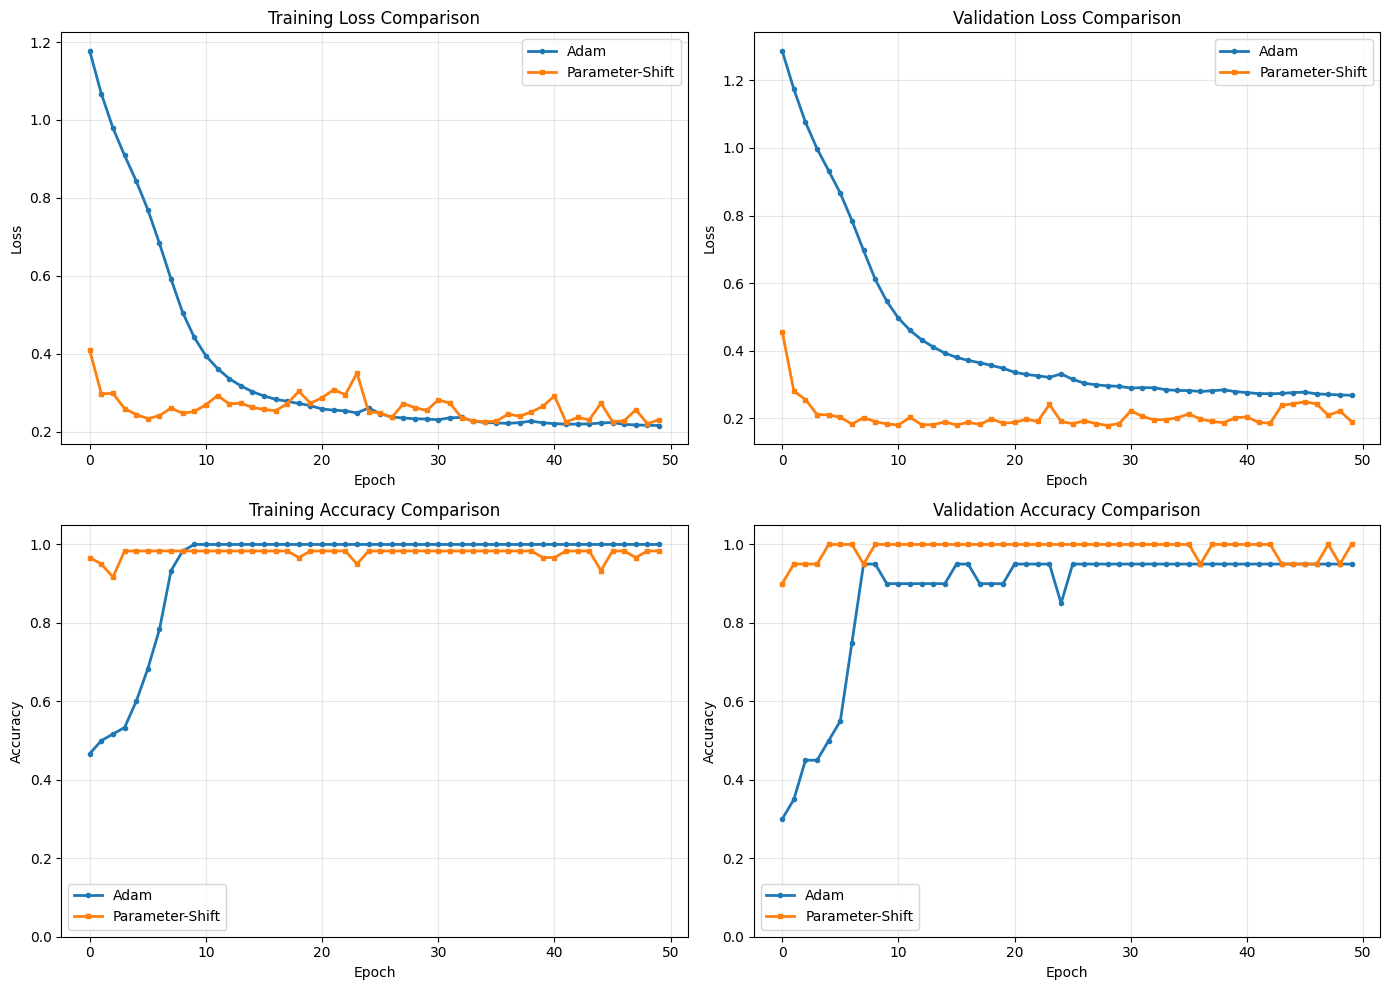

✓ Training curves visualized


In [24]:
# Cell 24

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training Loss
axes[0, 0].plot(history_adam['train_loss'], label='Adam', linewidth=2, marker='o', markersize=3)
axes[0, 0].plot(history_ps['train_loss'], label='Parameter-Shift', linewidth=2, marker='s', markersize=3)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Loss
axes[0, 1].plot(history_adam['val_loss'], label='Adam', linewidth=2, marker='o', markersize=3)
axes[0, 1].plot(history_ps['val_loss'], label='Parameter-Shift', linewidth=2, marker='s', markersize=3)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Validation Loss Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Training Accuracy
axes[1, 0].plot(history_adam['train_acc'], label='Adam', linewidth=2, marker='o', markersize=3)
axes[1, 0].plot(history_ps['train_acc'], label='Parameter-Shift', linewidth=2, marker='s', markersize=3)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Training Accuracy Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1.05])

# Plot 4: Validation Accuracy
axes[1, 1].plot(history_adam['val_acc'], label='Adam', linewidth=2, marker='o', markersize=3)
axes[1, 1].plot(history_ps['val_acc'], label='Parameter-Shift', linewidth=2, marker='s', markersize=3)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Validation Accuracy Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print("✓ Training curves visualized")

In [25]:
# Cell 25

print("=" * 70)
print("📊 BENCHMARK RESULTS: Adam vs Parameter-Shift")
print("=" * 70)

print(f"\n{'Metric':<30} {'Adam':<20} {'Parameter-Shift':<20}")
print("-" * 70)

# Time comparison
print(f"{'Training Time (s)':<30} {adam_time:<20.2f} {ps_time:<20.2f}")
print(f"{'Time per Epoch (s)':<30} {adam_time/n_epochs:<20.2f} {ps_time/n_epochs:<20.2f}")
print(f"{'Speedup Factor':<30} {'-':<20} {adam_time/ps_time:<20.2f}x")

print("\n" + "-" * 70)

# Accuracy comparison
print(f"{'Final Train Accuracy':<30} {history_adam['train_acc'][-1]:<20.2%} {history_ps['train_acc'][-1]:<20.2%}")
print(f"{'Final Val Accuracy':<30} {history_adam['val_acc'][-1]:<20.2%} {history_ps['val_acc'][-1]:<20.2%}")
print(f"{'Best Val Accuracy':<30} {max(history_adam['val_acc']):<20.2%} {max(history_ps['val_acc']):<20.2%}")

print("\n" + "-" * 70)

# Loss comparison
print(f"{'Final Train Loss':<30} {history_adam['train_loss'][-1]:<20.4f} {history_ps['train_loss'][-1]:<20.4f}")
print(f"{'Final Val Loss':<30} {history_adam['val_loss'][-1]:<20.4f} {history_ps['val_loss'][-1]:<20.4f}")
print(f"{'Best Val Loss':<30} {min(history_adam['val_loss']):<20.4f} {min(history_ps['val_loss']):<20.4f}")

print("\n" + "=" * 70)

# Summary
best_val_acc = max(max(history_adam['val_acc']), max(history_ps['val_acc']))
print("\n💡 Key Insights:")
print(f"   • Adam is {adam_time/ps_time:.1f}x faster (finite differences vs 2N circuit evaluations)")
print(f"   • Parameter-Shift provides exact gradients (no approximation error)")
print(f"   • Both achieve {best_val_acc:.1%}+ validation accuracy")

if adam_time < ps_time:
    winner = "Adam (speed advantage)"
else:
    winner = "Parameter-Shift (gradient exactness)"
    
print(f"   • Winner for this task: {winner}")

📊 BENCHMARK RESULTS: Adam vs Parameter-Shift

Metric                         Adam                 Parameter-Shift     
----------------------------------------------------------------------
Training Time (s)              5.07                 8.15                
Time per Epoch (s)             0.10                 0.16                
Speedup Factor                 -                    0.62                x

----------------------------------------------------------------------
Final Train Accuracy           100.00%              98.33%              
Final Val Accuracy             95.00%               100.00%             
Best Val Accuracy              95.00%               100.00%             

----------------------------------------------------------------------
Final Train Loss               0.2156               0.2304              
Final Val Loss                 0.2686               0.1910              
Best Val Loss                  0.2686               0.1793              


💡 Key 

In [26]:
# Cell 26

print("🧪 Evaluating on Test Set\n")
print("=" * 60)

# Evaluate Adam model
test_acc_adam, test_preds_adam = evaluate_accuracy(
    params_adam_trained, X_test_scaled, y_test, n_qubits, n_layers
)
test_loss_adam = compute_loss(
    params_adam_trained, X_test_scaled, y_test, n_qubits, n_layers
)

# Evaluate Parameter-Shift model
test_acc_ps, test_preds_ps = evaluate_accuracy(
    params_ps_trained, X_test_scaled, y_test, n_qubits, n_layers
)
test_loss_ps = compute_loss(
    params_ps_trained, X_test_scaled, y_test, n_qubits, n_layers
)

print(f"{'Model':<25} {'Test Accuracy':<20} {'Test Loss':<15}")
print("-" * 60)
print(f"{'Adam':<25} {test_acc_adam:<20.2%} {test_loss_adam:<15.4f}")
print(f"{'Parameter-Shift':<25} {test_acc_ps:<20.2%} {test_loss_ps:<15.4f}")
print("=" * 60)

# Determine better model
if test_acc_adam > test_acc_ps:
    print(f"\n🏆 Adam performs better on test set (+{(test_acc_adam-test_acc_ps)*100:.1f}%)")
elif test_acc_ps > test_acc_adam:
    print(f"\n🏆 Parameter-Shift performs better on test set (+{(test_acc_ps-test_acc_adam)*100:.1f}%)")
else:
    print(f"\n🤝 Both models achieve identical test accuracy!")

🧪 Evaluating on Test Set

Model                     Test Accuracy        Test Loss      
------------------------------------------------------------
Adam                      95.00%               0.2279         
Parameter-Shift           100.00%              0.1802         

🏆 Parameter-Shift performs better on test set (+5.0%)


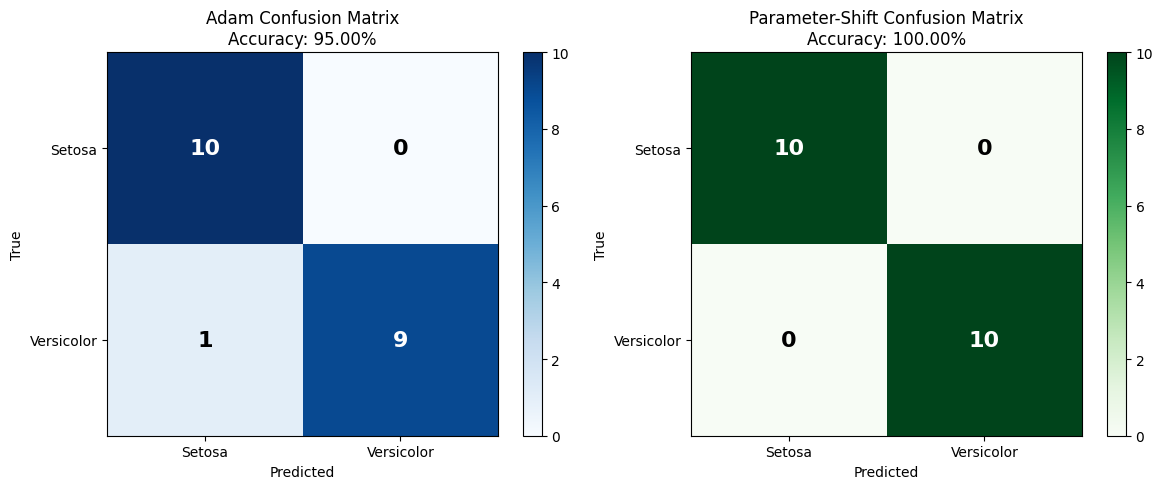


📋 Classification Reports:

ADAM MODEL:
              precision    recall  f1-score   support

      Setosa       0.91      1.00      0.95        10
  Versicolor       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20


PARAMETER-SHIFT MODEL:
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        10
  Versicolor       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [27]:
# Cell 27

from sklearn.metrics import confusion_matrix, classification_report

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix for Adam
cm_adam = confusion_matrix(y_test, test_preds_adam)
im1 = axes[0].imshow(cm_adam, cmap='Blues', aspect='auto')
axes[0].set_title(f'Adam Confusion Matrix\nAccuracy: {test_acc_adam:.2%}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Setosa', 'Versicolor'])
axes[0].set_yticklabels(['Setosa', 'Versicolor'])

# Add text annotations
for i in range(2):
    for j in range(2):
        text = axes[0].text(j, i, cm_adam[i, j], ha="center", va="center", 
                           color="white" if cm_adam[i, j] > cm_adam.max()/2 else "black",
                           fontsize=16, fontweight='bold')

plt.colorbar(im1, ax=axes[0])

# Confusion Matrix for Parameter-Shift
cm_ps = confusion_matrix(y_test, test_preds_ps)
im2 = axes[1].imshow(cm_ps, cmap='Greens', aspect='auto')
axes[1].set_title(f'Parameter-Shift Confusion Matrix\nAccuracy: {test_acc_ps:.2%}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Setosa', 'Versicolor'])
axes[1].set_yticklabels(['Setosa', 'Versicolor'])

# Add text annotations
for i in range(2):
    for j in range(2):
        text = axes[1].text(j, i, cm_ps[i, j], ha="center", va="center",
                           color="white" if cm_ps[i, j] > cm_ps.max()/2 else "black",
                           fontsize=16, fontweight='bold')

plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print("\n📋 Classification Reports:\n")
print("ADAM MODEL:")
print(classification_report(y_test, test_preds_adam, target_names=['Setosa', 'Versicolor']))
print("\nPARAMETER-SHIFT MODEL:")
print(classification_report(y_test, test_preds_ps, target_names=['Setosa', 'Versicolor']))

In [28]:
# Cell 28

from sklearn.datasets import load_breast_cancer

# Load dataset
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

print("🏥 Breast Cancer Wisconsin Dataset Loaded\n")
print("=" * 60)
print(f"Total samples: {len(X_cancer)}")
print(f"Features: {X_cancer.shape[1]}")
print(f"Classes: {cancer.target_names}")
print(f"Class distribution: Malignant={np.sum(y_cancer==0)}, Benign={np.sum(y_cancer==1)}")
print(f"\nFeature names (first 10):")
for i, name in enumerate(cancer.feature_names[:10]):
    print(f"  {i+1}. {name}")
print("  ...")
print("=" * 60)

🏥 Breast Cancer Wisconsin Dataset Loaded

Total samples: 569
Features: 30
Classes: ['malignant' 'benign']
Class distribution: Malignant=212, Benign=357

Feature names (first 10):
  1. mean radius
  2. mean texture
  3. mean perimeter
  4. mean area
  5. mean smoothness
  6. mean compactness
  7. mean concavity
  8. mean concave points
  9. mean symmetry
  10. mean fractal dimension
  ...


In [29]:
# Cell 29

from sklearn.decomposition import PCA

# We need to reduce 30 features to match qubit count
n_components_cancer = 8  # Match our 8 qubits from before

# Normalize first
scaler_cancer = StandardScaler()
X_cancer_normalized = scaler_cancer.fit_transform(X_cancer)

# Apply PCA
pca_cancer = PCA(n_components=n_components_cancer)
X_cancer_reduced = pca_cancer.fit_transform(X_cancer_normalized)

print(f"✓ PCA Dimensionality Reduction: 30 → {n_components_cancer} features")
print(f"✓ Explained variance ratio per component:")
for i, var in enumerate(pca_cancer.explained_variance_ratio_):
    print(f"   PC{i+1}: {var:.3f} ({var*100:.1f}%)")
print(f"\n✓ Total explained variance: {pca_cancer.explained_variance_ratio_.sum():.2%}")
print(f"✓ Reduced data shape: {X_cancer_reduced.shape}")

✓ PCA Dimensionality Reduction: 30 → 8 features
✓ Explained variance ratio per component:
   PC1: 0.443 (44.3%)
   PC2: 0.190 (19.0%)
   PC3: 0.094 (9.4%)
   PC4: 0.066 (6.6%)
   PC5: 0.055 (5.5%)
   PC6: 0.040 (4.0%)
   PC7: 0.023 (2.3%)
   PC8: 0.016 (1.6%)

✓ Total explained variance: 92.60%
✓ Reduced data shape: (569, 8)


In [30]:
# Cell 30

# Train-validation-test split (60/20/20)
X_train_c, X_temp_c, y_train_c, y_temp_c = train_test_split(
    X_cancer_reduced, y_cancer, test_size=0.4, random_state=42, stratify=y_cancer
)
X_val_c, X_test_c, y_val_c, y_test_c = train_test_split(
    X_temp_c, y_temp_c, test_size=0.5, random_state=42, stratify=y_temp_c
)

# Scale to [0, π] for quantum encoding
X_train_c = (X_train_c - X_train_c.min()) / (X_train_c.max() - X_train_c.min()) * np.pi
X_val_c = (X_val_c - X_val_c.min()) / (X_val_c.max() - X_val_c.min()) * np.pi
X_test_c = (X_test_c - X_test_c.min()) / (X_test_c.max() - X_test_c.min()) * np.pi

print(f"✓ Dataset Split Complete")
print(f"  Training: {len(X_train_c)} samples ({len(X_train_c)/len(X_cancer_reduced):.1%})")
print(f"  Validation: {len(X_val_c)} samples ({len(X_val_c)/len(X_cancer_reduced):.1%})")
print(f"  Test: {len(X_test_c)} samples ({len(X_test_c)/len(X_cancer_reduced):.1%})")
print(f"\n✓ Scaled to [0, π] range: [{X_train_c.min():.3f}, {X_train_c.max():.3f}]")
print(f"\n✓ Class distribution in training:")
print(f"   Malignant (0): {np.sum(y_train_c==0)}")
print(f"   Benign (1): {np.sum(y_train_c==1)}")

✓ Dataset Split Complete
  Training: 341 samples (59.9%)
  Validation: 114 samples (20.0%)
  Test: 114 samples (20.0%)

✓ Scaled to [0, π] range: [0.000, 3.142]

✓ Class distribution in training:
   Malignant (0): 127
   Benign (1): 214


In [31]:
# Cell 30

# Train-validation-test split (60/20/20)
X_train_c, X_temp_c, y_train_c, y_temp_c = train_test_split(
    X_cancer_reduced, y_cancer, test_size=0.4, random_state=42, stratify=y_cancer
)
X_val_c, X_test_c, y_val_c, y_test_c = train_test_split(
    X_temp_c, y_temp_c, test_size=0.5, random_state=42, stratify=y_temp_c
)

# Scale to [0, π] for quantum encoding
X_train_c = (X_train_c - X_train_c.min()) / (X_train_c.max() - X_train_c.min()) * np.pi
X_val_c = (X_val_c - X_val_c.min()) / (X_val_c.max() - X_val_c.min()) * np.pi
X_test_c = (X_test_c - X_test_c.min()) / (X_test_c.max() - X_test_c.min()) * np.pi

print(f"✓ Dataset Split Complete")
print(f"  Training: {len(X_train_c)} samples ({len(X_train_c)/len(X_cancer_reduced):.1%})")
print(f"  Validation: {len(X_val_c)} samples ({len(X_val_c)/len(X_cancer_reduced):.1%})")
print(f"  Test: {len(X_test_c)} samples ({len(X_test_c)/len(X_cancer_reduced):.1%})")
print(f"\n✓ Scaled to [0, π] range: [{X_train_c.min():.3f}, {X_train_c.max():.3f}]")
print(f"\n✓ Class distribution in training:")
print(f"   Malignant (0): {np.sum(y_train_c==0)}")
print(f"   Benign (1): {np.sum(y_train_c==1)}")

✓ Dataset Split Complete
  Training: 341 samples (59.9%)
  Validation: 114 samples (20.0%)
  Test: 114 samples (20.0%)

✓ Scaled to [0, π] range: [0.000, 3.142]

✓ Class distribution in training:
   Malignant (0): 127
   Benign (1): 214


In [32]:
# Cell 31

# Update circuit parameters for cancer dataset
n_qubits_cancer = 8  # Match 8 PCA components
n_layers_cancer = 3  # Keep same depth
n_features_cancer = X_train_c.shape[1]  # 8 features

# Calculate total parameters
n_params_cancer = n_qubits_cancer * n_layers_cancer * 3  # 72 parameters

# Initialize new parameters
np.random.seed(42)
params_cancer = np.random.uniform(-np.pi, np.pi, size=n_params_cancer)

print(f"🔧 Circuit Configuration Updated for Cancer Dataset")
print(f"=" * 60)
print(f"  Qubits: {n_qubits_cancer}")
print(f"  Layers: {n_layers_cancer}")
print(f"  Input features: {n_features_cancer}")
print(f"  Total trainable parameters: {n_params_cancer}")
print(f"\n✓ Parameters initialized: shape={params_cancer.shape}")
print(f"  Range: [{params_cancer.min():.3f}, {params_cancer.max():.3f}]")

🔧 Circuit Configuration Updated for Cancer Dataset
  Qubits: 8
  Layers: 3
  Input features: 8
  Total trainable parameters: 72

✓ Parameters initialized: shape=(72,)
  Range: [-3.012, 3.059]


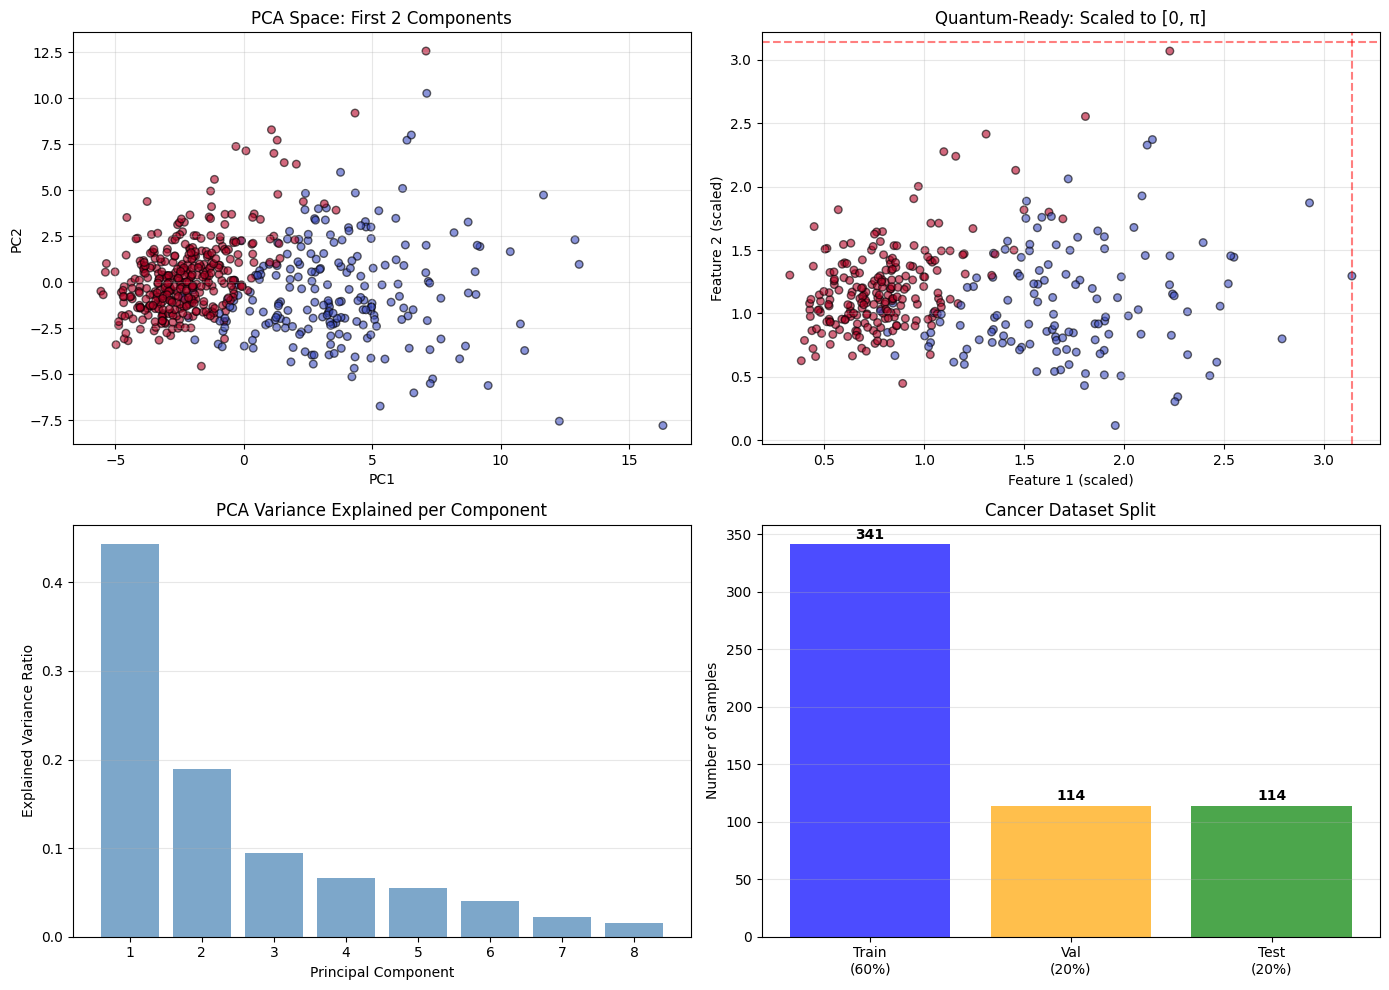

✓ Cancer dataset visualization complete


In [33]:
# Cell 32

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: First 2 PCA components (original space)
axes[0, 0].scatter(X_cancer_reduced[:, 0], X_cancer_reduced[:, 1], 
                   c=y_cancer, cmap='coolwarm', alpha=0.6, edgecolor='k', s=30)
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].set_title('PCA Space: First 2 Components')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Scaled data for quantum encoding
axes[0, 1].scatter(X_train_c[:, 0], X_train_c[:, 1], 
                   c=y_train_c, cmap='coolwarm', alpha=0.6, edgecolor='k', s=30)
axes[0, 1].set_xlabel('Feature 1 (scaled)')
axes[0, 1].set_ylabel('Feature 2 (scaled)')
axes[0, 1].set_title('Quantum-Ready: Scaled to [0, π]')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=np.pi, color='r', linestyle='--', alpha=0.5)
axes[0, 1].axvline(x=np.pi, color='r', linestyle='--', alpha=0.5)

# Plot 3: PCA explained variance
axes[1, 0].bar(range(1, n_components_cancer+1), 
               pca_cancer.explained_variance_ratio_, 
               color='steelblue', alpha=0.7)
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Explained Variance Ratio')
axes[1, 0].set_title('PCA Variance Explained per Component')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Dataset split
split_sizes_c = [len(X_train_c), len(X_val_c), len(X_test_c)]
axes[1, 1].bar(['Train\n(60%)', 'Val\n(20%)', 'Test\n(20%)'], 
               split_sizes_c, color=['blue', 'orange', 'green'], alpha=0.7)
axes[1, 1].set_ylabel('Number of Samples')
axes[1, 1].set_title('Cancer Dataset Split')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(split_sizes_c):
    axes[1, 1].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Cancer dataset visualization complete")

In [34]:
# Cell 33

import time

# Training configuration for cancer dataset
n_epochs_cancer = 100
batch_size_cancer = 15
n_samples_per_gradient_cancer = 10

print(f"🚀 Training Configuration for Cancer Dataset")
print(f"  Epochs: {n_epochs_cancer}")
print(f"  Batch size: {batch_size_cancer}")
print(f"  Samples per gradient: {n_samples_per_gradient_cancer}")
print(f"  Dataset size: {len(X_train_c)} training samples\n")

# Initialize fresh parameters
params_adam_cancer = np.random.uniform(-np.pi, np.pi, size=n_params_cancer)
np.random.seed(42)

# Time the training
start_time = time.time()

params_adam_cancer_trained, history_adam_cancer = train_adam_with_progress(
    params_adam_cancer, 
    X_train_c, 
    y_train_c, 
    X_val_c, 
    y_val_c, 
    n_epochs_cancer, 
    n_samples_per_gradient_cancer
)

adam_time_cancer = time.time() - start_time

print(f"\n✅ Adam Training on Cancer Dataset Complete!")
print(f"   Time: {adam_time_cancer:.2f}s")
print(f"   Final Train Acc: {history_adam_cancer['train_acc'][-1]:.2%}")
print(f"   Final Val Acc: {history_adam_cancer['val_acc'][-1]:.2%}")

🚀 Training Configuration for Cancer Dataset
  Epochs: 100
  Batch size: 15
  Samples per gradient: 10
  Dataset size: 341 training samples

🚀 Starting Adam Training



Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.6263 - Val Loss: 0.4709 - Acc: 87.10% - Val Acc: 91.23%



Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5488 - Val Loss: 0.3712 - Acc: 85.92% - Val Acc: 89.47%



Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5258 - Val Loss: 0.3291 - Acc: 90.91% - Val Acc: 93.86%



Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5238 - Val Loss: 0.3285 - Acc: 89.15% - Val Acc: 93.86%



Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5323 - Val Loss: 0.3318 - Acc: 91.50% - Val Acc: 94.74%



Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5381 - Val Loss: 0.3313 - Acc: 92.67% - Val Acc: 96.49%



Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5288 - Val Loss: 0.3268 - Acc: 90.62% - Val Acc: 94.74%



Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5273 - Val Loss: 0.3285 - Acc: 90.03% - Val Acc: 93.86%



Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5288 - Val Loss: 0.3291 - Acc: 90.03% - Val Acc: 92.98%



Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5285 - Val Loss: 0.3288 - Acc: 90.32% - Val Acc: 92.98%



Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5284 - Val Loss: 0.3290 - Acc: 91.20% - Val Acc: 94.74%



Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5276 - Val Loss: 0.3270 - Acc: 90.62% - Val Acc: 94.74%



Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5299 - Val Loss: 0.3333 - Acc: 87.98% - Val Acc: 92.11%



Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5324 - Val Loss: 0.3291 - Acc: 92.08% - Val Acc: 95.61%



Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5277 - Val Loss: 0.3260 - Acc: 91.20% - Val Acc: 94.74%



Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5277 - Val Loss: 0.3269 - Acc: 91.20% - Val Acc: 95.61%



Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5276 - Val Loss: 0.3258 - Acc: 91.20% - Val Acc: 94.74%



Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5264 - Val Loss: 0.3273 - Acc: 89.74% - Val Acc: 92.98%



Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5253 - Val Loss: 0.3303 - Acc: 88.86% - Val Acc: 92.98%



Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5276 - Val Loss: 0.3286 - Acc: 91.50% - Val Acc: 95.61%



Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5247 - Val Loss: 0.3261 - Acc: 90.32% - Val Acc: 94.74%



Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5262 - Val Loss: 0.3242 - Acc: 91.20% - Val Acc: 95.61%



Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5239 - Val Loss: 0.3276 - Acc: 90.03% - Val Acc: 94.74%



Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5219 - Val Loss: 0.3257 - Acc: 89.74% - Val Acc: 93.86%



Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5357 - Val Loss: 0.3314 - Acc: 92.96% - Val Acc: 96.49%



Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5224 - Val Loss: 0.3250 - Acc: 90.32% - Val Acc: 94.74%



Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5209 - Val Loss: 0.3280 - Acc: 89.15% - Val Acc: 93.86%



Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5239 - Val Loss: 0.3242 - Acc: 91.79% - Val Acc: 95.61%



Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5240 - Val Loss: 0.3254 - Acc: 91.79% - Val Acc: 95.61%



Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5224 - Val Loss: 0.3242 - Acc: 91.79% - Val Acc: 95.61%



Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5228 - Val Loss: 0.3242 - Acc: 91.79% - Val Acc: 95.61%



Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5231 - Val Loss: 0.3255 - Acc: 90.32% - Val Acc: 93.86%



Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5223 - Val Loss: 0.3239 - Acc: 90.62% - Val Acc: 94.74%



Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5199 - Val Loss: 0.3258 - Acc: 89.44% - Val Acc: 92.98%



Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5217 - Val Loss: 0.3237 - Acc: 90.62% - Val Acc: 94.74%



Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5302 - Val Loss: 0.3299 - Acc: 92.96% - Val Acc: 96.49%



Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5218 - Val Loss: 0.3229 - Acc: 91.79% - Val Acc: 95.61%



Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5211 - Val Loss: 0.3274 - Acc: 88.56% - Val Acc: 92.98%



Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5205 - Val Loss: 0.3241 - Acc: 92.08% - Val Acc: 95.61%



Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5263 - Val Loss: 0.3275 - Acc: 92.08% - Val Acc: 96.49%



Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5186 - Val Loss: 0.3224 - Acc: 91.50% - Val Acc: 95.61%



Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5206 - Val Loss: 0.3212 - Acc: 91.50% - Val Acc: 95.61%



Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5189 - Val Loss: 0.3224 - Acc: 91.50% - Val Acc: 95.61%



Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5176 - Val Loss: 0.3235 - Acc: 90.32% - Val Acc: 94.74%



Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5179 - Val Loss: 0.3222 - Acc: 91.50% - Val Acc: 95.61%



Epoch 46/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5175 - Val Loss: 0.3245 - Acc: 89.74% - Val Acc: 93.86%



Epoch 47/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5174 - Val Loss: 0.3209 - Acc: 90.91% - Val Acc: 94.74%



Epoch 48/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5187 - Val Loss: 0.3234 - Acc: 92.08% - Val Acc: 95.61%



Epoch 49/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5168 - Val Loss: 0.3217 - Acc: 91.50% - Val Acc: 95.61%



Epoch 50/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5154 - Val Loss: 0.3225 - Acc: 90.32% - Val Acc: 94.74%



Epoch 51/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5163 - Val Loss: 0.3215 - Acc: 91.20% - Val Acc: 95.61%



Epoch 52/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5172 - Val Loss: 0.3275 - Acc: 88.27% - Val Acc: 92.98%



Epoch 53/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5149 - Val Loss: 0.3209 - Acc: 91.50% - Val Acc: 95.61%



Epoch 54/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5180 - Val Loss: 0.3286 - Acc: 87.39% - Val Acc: 92.98%



Epoch 55/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5164 - Val Loss: 0.3219 - Acc: 91.79% - Val Acc: 95.61%



Epoch 56/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5281 - Val Loss: 0.3293 - Acc: 93.26% - Val Acc: 96.49%



Epoch 57/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5133 - Val Loss: 0.3237 - Acc: 89.44% - Val Acc: 93.86%



Epoch 58/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5131 - Val Loss: 0.3201 - Acc: 91.20% - Val Acc: 95.61%



Epoch 59/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5120 - Val Loss: 0.3227 - Acc: 90.03% - Val Acc: 94.74%



Epoch 60/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5137 - Val Loss: 0.3201 - Acc: 91.79% - Val Acc: 95.61%



Epoch 61/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5118 - Val Loss: 0.3217 - Acc: 90.03% - Val Acc: 93.86%



Epoch 62/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5136 - Val Loss: 0.3211 - Acc: 91.79% - Val Acc: 95.61%



Epoch 63/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5121 - Val Loss: 0.3204 - Acc: 90.91% - Val Acc: 95.61%



Epoch 64/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5123 - Val Loss: 0.3213 - Acc: 89.15% - Val Acc: 93.86%



Epoch 65/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5134 - Val Loss: 0.3225 - Acc: 89.15% - Val Acc: 93.86%



Epoch 66/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5142 - Val Loss: 0.3199 - Acc: 92.08% - Val Acc: 96.49%



Epoch 67/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5109 - Val Loss: 0.3207 - Acc: 89.44% - Val Acc: 93.86%



Epoch 68/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5102 - Val Loss: 0.3216 - Acc: 89.44% - Val Acc: 93.86%



Epoch 69/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5113 - Val Loss: 0.3186 - Acc: 91.20% - Val Acc: 95.61%



Epoch 70/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5122 - Val Loss: 0.3182 - Acc: 91.79% - Val Acc: 95.61%



Epoch 71/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5113 - Val Loss: 0.3183 - Acc: 91.50% - Val Acc: 95.61%



Epoch 72/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5107 - Val Loss: 0.3178 - Acc: 91.79% - Val Acc: 95.61%



Epoch 73/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5159 - Val Loss: 0.3222 - Acc: 92.96% - Val Acc: 96.49%



Epoch 74/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5102 - Val Loss: 0.3207 - Acc: 90.03% - Val Acc: 94.74%



Epoch 75/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5117 - Val Loss: 0.3193 - Acc: 91.79% - Val Acc: 96.49%



Epoch 76/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5126 - Val Loss: 0.3253 - Acc: 88.27% - Val Acc: 92.98%



Epoch 77/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5179 - Val Loss: 0.3249 - Acc: 92.67% - Val Acc: 96.49%



Epoch 78/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5132 - Val Loss: 0.3197 - Acc: 92.08% - Val Acc: 96.49%



Epoch 79/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5111 - Val Loss: 0.3182 - Acc: 92.08% - Val Acc: 95.61%



Epoch 80/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5114 - Val Loss: 0.3194 - Acc: 90.62% - Val Acc: 95.61%



Epoch 81/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5112 - Val Loss: 0.3181 - Acc: 92.08% - Val Acc: 96.49%



Epoch 82/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5084 - Val Loss: 0.3201 - Acc: 90.03% - Val Acc: 95.61%



Epoch 83/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5088 - Val Loss: 0.3197 - Acc: 91.50% - Val Acc: 95.61%



Epoch 84/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5101 - Val Loss: 0.3214 - Acc: 89.44% - Val Acc: 93.86%



Epoch 85/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5092 - Val Loss: 0.3172 - Acc: 91.79% - Val Acc: 95.61%



Epoch 86/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5115 - Val Loss: 0.3185 - Acc: 92.08% - Val Acc: 96.49%



Epoch 87/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5081 - Val Loss: 0.3189 - Acc: 90.32% - Val Acc: 95.61%



Epoch 88/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5082 - Val Loss: 0.3187 - Acc: 90.03% - Val Acc: 94.74%



Epoch 89/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5083 - Val Loss: 0.3186 - Acc: 90.03% - Val Acc: 94.74%



Epoch 90/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5115 - Val Loss: 0.3186 - Acc: 92.08% - Val Acc: 96.49%



Epoch 91/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5109 - Val Loss: 0.3174 - Acc: 92.08% - Val Acc: 96.49%



Epoch 92/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5083 - Val Loss: 0.3182 - Acc: 90.03% - Val Acc: 94.74%



Epoch 93/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5120 - Val Loss: 0.3174 - Acc: 92.08% - Val Acc: 96.49%



Epoch 94/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5093 - Val Loss: 0.3185 - Acc: 89.74% - Val Acc: 94.74%



Epoch 95/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5087 - Val Loss: 0.3161 - Acc: 90.91% - Val Acc: 95.61%



Epoch 96/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5095 - Val Loss: 0.3166 - Acc: 91.79% - Val Acc: 96.49%



Epoch 97/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5082 - Val Loss: 0.3176 - Acc: 90.32% - Val Acc: 95.61%



Epoch 98/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5087 - Val Loss: 0.3152 - Acc: 91.79% - Val Acc: 96.49%



Epoch 99/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5091 - Val Loss: 0.3220 - Acc: 89.15% - Val Acc: 93.86%



Epoch 100/100: 100%|███████████████████████████████████████████████████████████| 35/35 [00:01<00:00]


  ├─ Loss: 0.5088 - Val Loss: 0.3198 - Acc: 90.03% - Val Acc: 94.74%


✅ Adam Training on Cancer Dataset Complete!
   Time: 161.67s
   Final Train Acc: 90.03%
   Final Val Acc: 94.74%


In [35]:
# Cell 34

# Initialize fresh parameters with same seed
params_ps_cancer = np.random.uniform(-np.pi, np.pi, size=n_params_cancer)
np.random.seed(42)

# Time the training
start_time = time.time()

params_ps_cancer_trained, history_ps_cancer = train_parameter_shift_with_progress(
    params_ps_cancer, 
    X_train_c, 
    y_train_c, 
    X_val_c, 
    y_val_c, 
    n_epochs_cancer, 
    n_samples_per_gradient_cancer
)

ps_time_cancer = time.time() - start_time

print(f"\n✅ Parameter-Shift Training on Cancer Dataset Complete!")
print(f"   Time: {ps_time_cancer:.2f}s")
print(f"   Final Train Acc: {history_ps_cancer['train_acc'][-1]:.2%}")
print(f"   Final Val Acc: {history_ps_cancer['val_acc'][-1]:.2%}")

⚛️  Starting Parameter-Shift Training



Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7905 - Val Loss: 0.5269 - Acc: 88.27% - Val Acc: 91.23%



Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5906 - Val Loss: 0.3729 - Acc: 83.28% - Val Acc: 88.60%



Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8065 - Val Loss: 0.6277 - Acc: 69.50% - Val Acc: 68.42%



Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7139 - Val Loss: 0.5169 - Acc: 73.90% - Val Acc: 74.56%



Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7597 - Val Loss: 0.5823 - Acc: 70.67% - Val Acc: 71.93%



Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.6734 - Val Loss: 0.4815 - Acc: 76.25% - Val Acc: 77.19%



Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8626 - Val Loss: 0.7169 - Acc: 68.33% - Val Acc: 66.67%



Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5903 - Val Loss: 0.3876 - Acc: 82.40% - Val Acc: 89.47%



Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7767 - Val Loss: 0.5993 - Acc: 70.09% - Val Acc: 70.18%



Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7481 - Val Loss: 0.5646 - Acc: 71.55% - Val Acc: 71.05%



Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7036 - Val Loss: 0.5235 - Acc: 73.61% - Val Acc: 75.44%



Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5373 - Val Loss: 0.3340 - Acc: 90.62% - Val Acc: 94.74%



Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7741 - Val Loss: 0.6118 - Acc: 70.67% - Val Acc: 71.05%



Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5875 - Val Loss: 0.4015 - Acc: 82.11% - Val Acc: 85.09%



Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7144 - Val Loss: 0.5447 - Acc: 72.43% - Val Acc: 74.56%



Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7882 - Val Loss: 0.6355 - Acc: 69.21% - Val Acc: 68.42%



Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.6321 - Val Loss: 0.4482 - Acc: 78.01% - Val Acc: 80.70%



Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5341 - Val Loss: 0.3304 - Acc: 89.44% - Val Acc: 93.86%



Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7277 - Val Loss: 0.5717 - Acc: 71.26% - Val Acc: 73.68%



Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.6179 - Val Loss: 0.4404 - Acc: 78.01% - Val Acc: 82.46%



Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7171 - Val Loss: 0.5715 - Acc: 71.26% - Val Acc: 73.68%



Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7639 - Val Loss: 0.6183 - Acc: 70.38% - Val Acc: 69.30%



Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5650 - Val Loss: 0.3429 - Acc: 93.55% - Val Acc: 95.61%



Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5564 - Val Loss: 0.3391 - Acc: 92.08% - Val Acc: 95.61%



Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.6333 - Val Loss: 0.3782 - Acc: 92.67% - Val Acc: 95.61%



Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.6487 - Val Loss: 0.3945 - Acc: 92.38% - Val Acc: 95.61%



Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.7316 - Val Loss: 0.5486 - Acc: 72.14% - Val Acc: 73.68%



Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.8727 - Val Loss: 0.7282 - Acc: 68.04% - Val Acc: 67.54%



Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8847 - Val Loss: 0.7461 - Acc: 68.04% - Val Acc: 67.54%



Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8565 - Val Loss: 0.7083 - Acc: 68.33% - Val Acc: 67.54%



Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.6263 - Val Loss: 0.3617 - Acc: 92.67% - Val Acc: 95.61%



Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.8578 - Val Loss: 0.6950 - Acc: 68.62% - Val Acc: 67.54%



Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5736 - Val Loss: 0.3262 - Acc: 92.67% - Val Acc: 94.74%



Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.6181 - Val Loss: 0.4042 - Acc: 81.23% - Val Acc: 85.09%



Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.6882 - Val Loss: 0.4864 - Acc: 75.66% - Val Acc: 78.95%



Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5889 - Val Loss: 0.3349 - Acc: 92.96% - Val Acc: 94.74%



Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.6269 - Val Loss: 0.3611 - Acc: 91.79% - Val Acc: 94.74%



Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.9016 - Val Loss: 0.7581 - Acc: 68.04% - Val Acc: 67.54%



Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.8860 - Val Loss: 0.7376 - Acc: 68.04% - Val Acc: 67.54%



Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.8882 - Val Loss: 0.7412 - Acc: 68.04% - Val Acc: 67.54%



Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5530 - Val Loss: 0.3226 - Acc: 89.44% - Val Acc: 93.86%



Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.9250 - Val Loss: 0.7977 - Acc: 67.74% - Val Acc: 66.67%



Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5525 - Val Loss: 0.3238 - Acc: 89.15% - Val Acc: 92.98%



Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.9423 - Val Loss: 0.8256 - Acc: 66.57% - Val Acc: 66.67%



Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7958 - Val Loss: 0.6244 - Acc: 70.38% - Val Acc: 71.05%



Epoch 46/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.6078 - Val Loss: 0.3504 - Acc: 92.38% - Val Acc: 94.74%



Epoch 47/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.8916 - Val Loss: 0.7599 - Acc: 68.04% - Val Acc: 67.54%



Epoch 48/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.9478 - Val Loss: 0.8444 - Acc: 65.98% - Val Acc: 66.67%



Epoch 49/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5468 - Val Loss: 0.3187 - Acc: 90.62% - Val Acc: 94.74%



Epoch 50/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5486 - Val Loss: 0.3162 - Acc: 91.50% - Val Acc: 95.61%



Epoch 51/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5475 - Val Loss: 0.3209 - Acc: 89.44% - Val Acc: 93.86%



Epoch 52/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7620 - Val Loss: 0.5868 - Acc: 71.26% - Val Acc: 71.93%



Epoch 53/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5673 - Val Loss: 0.3232 - Acc: 92.67% - Val Acc: 94.74%



Epoch 54/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.8458 - Val Loss: 0.6955 - Acc: 68.91% - Val Acc: 67.54%



Epoch 55/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7967 - Val Loss: 0.6305 - Acc: 70.38% - Val Acc: 70.18%



Epoch 56/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8008 - Val Loss: 0.6355 - Acc: 70.09% - Val Acc: 70.18%



Epoch 57/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8191 - Val Loss: 0.6588 - Acc: 69.79% - Val Acc: 68.42%



Epoch 58/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.6445 - Val Loss: 0.4438 - Acc: 77.71% - Val Acc: 80.70%



Epoch 59/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.8264 - Val Loss: 0.6682 - Acc: 69.79% - Val Acc: 67.54%



Epoch 60/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5525 - Val Loss: 0.3302 - Acc: 88.27% - Val Acc: 92.11%



Epoch 61/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.8323 - Val Loss: 0.6762 - Acc: 69.50% - Val Acc: 67.54%



Epoch 62/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5498 - Val Loss: 0.3155 - Acc: 91.50% - Val Acc: 95.61%



Epoch 63/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.6562 - Val Loss: 0.3863 - Acc: 90.62% - Val Acc: 92.11%



Epoch 64/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5644 - Val Loss: 0.3217 - Acc: 92.08% - Val Acc: 93.86%



Epoch 65/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5477 - Val Loss: 0.3159 - Acc: 91.20% - Val Acc: 95.61%



Epoch 66/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8101 - Val Loss: 0.6473 - Acc: 70.09% - Val Acc: 69.30%



Epoch 67/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8747 - Val Loss: 0.7333 - Acc: 68.62% - Val Acc: 67.54%



Epoch 68/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5477 - Val Loss: 0.3239 - Acc: 88.86% - Val Acc: 92.98%



Epoch 69/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7626 - Val Loss: 0.5875 - Acc: 71.26% - Val Acc: 71.93%



Epoch 70/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.7615 - Val Loss: 0.5852 - Acc: 71.26% - Val Acc: 71.93%



Epoch 71/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.7341 - Val Loss: 0.5506 - Acc: 72.43% - Val Acc: 74.56%



Epoch 72/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8780 - Val Loss: 0.7359 - Acc: 68.62% - Val Acc: 67.54%



Epoch 73/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5477 - Val Loss: 0.3173 - Acc: 90.91% - Val Acc: 95.61%



Epoch 74/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.9093 - Val Loss: 0.7795 - Acc: 68.04% - Val Acc: 66.67%



Epoch 75/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8162 - Val Loss: 0.6517 - Acc: 70.09% - Val Acc: 68.42%



Epoch 76/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.9748 - Val Loss: 0.8851 - Acc: 65.40% - Val Acc: 66.67%



Epoch 77/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.7826 - Val Loss: 0.6100 - Acc: 70.38% - Val Acc: 71.93%



Epoch 78/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.8762 - Val Loss: 0.7324 - Acc: 68.04% - Val Acc: 67.54%



Epoch 79/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5549 - Val Loss: 0.3171 - Acc: 91.50% - Val Acc: 95.61%



Epoch 80/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.6741 - Val Loss: 0.4765 - Acc: 76.25% - Val Acc: 78.95%



Epoch 81/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8265 - Val Loss: 0.6640 - Acc: 69.79% - Val Acc: 68.42%



Epoch 82/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 1.0368 - Val Loss: 0.9922 - Acc: 64.52% - Val Acc: 65.79%



Epoch 83/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5552 - Val Loss: 0.3169 - Acc: 91.20% - Val Acc: 95.61%



Epoch 84/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8541 - Val Loss: 0.6999 - Acc: 68.91% - Val Acc: 67.54%



Epoch 85/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.9144 - Val Loss: 0.7850 - Acc: 68.04% - Val Acc: 66.67%



Epoch 86/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.6000 - Val Loss: 0.3443 - Acc: 92.38% - Val Acc: 94.74%



Epoch 87/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8390 - Val Loss: 0.6805 - Acc: 69.50% - Val Acc: 67.54%



Epoch 88/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.7811 - Val Loss: 0.6059 - Acc: 70.97% - Val Acc: 71.93%



Epoch 89/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.9465 - Val Loss: 0.8363 - Acc: 65.98% - Val Acc: 66.67%



Epoch 90/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5491 - Val Loss: 0.3188 - Acc: 90.62% - Val Acc: 94.74%



Epoch 91/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.5988 - Val Loss: 0.3436 - Acc: 92.38% - Val Acc: 94.74%



Epoch 92/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.8752 - Val Loss: 0.7314 - Acc: 68.04% - Val Acc: 67.54%



Epoch 93/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5546 - Val Loss: 0.3311 - Acc: 88.27% - Val Acc: 92.11%



Epoch 94/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.7652 - Val Loss: 0.5873 - Acc: 71.26% - Val Acc: 71.93%



Epoch 95/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:03<00:00]


  ├─ Loss: 0.9565 - Val Loss: 0.8515 - Acc: 65.98% - Val Acc: 66.67%



Epoch 96/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.7934 - Val Loss: 0.6216 - Acc: 70.38% - Val Acc: 71.93%



Epoch 97/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.7683 - Val Loss: 0.5899 - Acc: 71.26% - Val Acc: 71.93%



Epoch 98/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5548 - Val Loss: 0.3308 - Acc: 88.27% - Val Acc: 92.11%



Epoch 99/100: 100%|████████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.5492 - Val Loss: 0.3186 - Acc: 90.62% - Val Acc: 95.61%



Epoch 100/100: 100%|███████████████████████████████████████████████████████████| 35/35 [00:02<00:00]


  ├─ Loss: 0.7955 - Val Loss: 0.6241 - Acc: 70.38% - Val Acc: 71.05%


✅ Parameter-Shift Training on Cancer Dataset Complete!
   Time: 307.05s
   Final Train Acc: 70.38%
   Final Val Acc: 71.05%


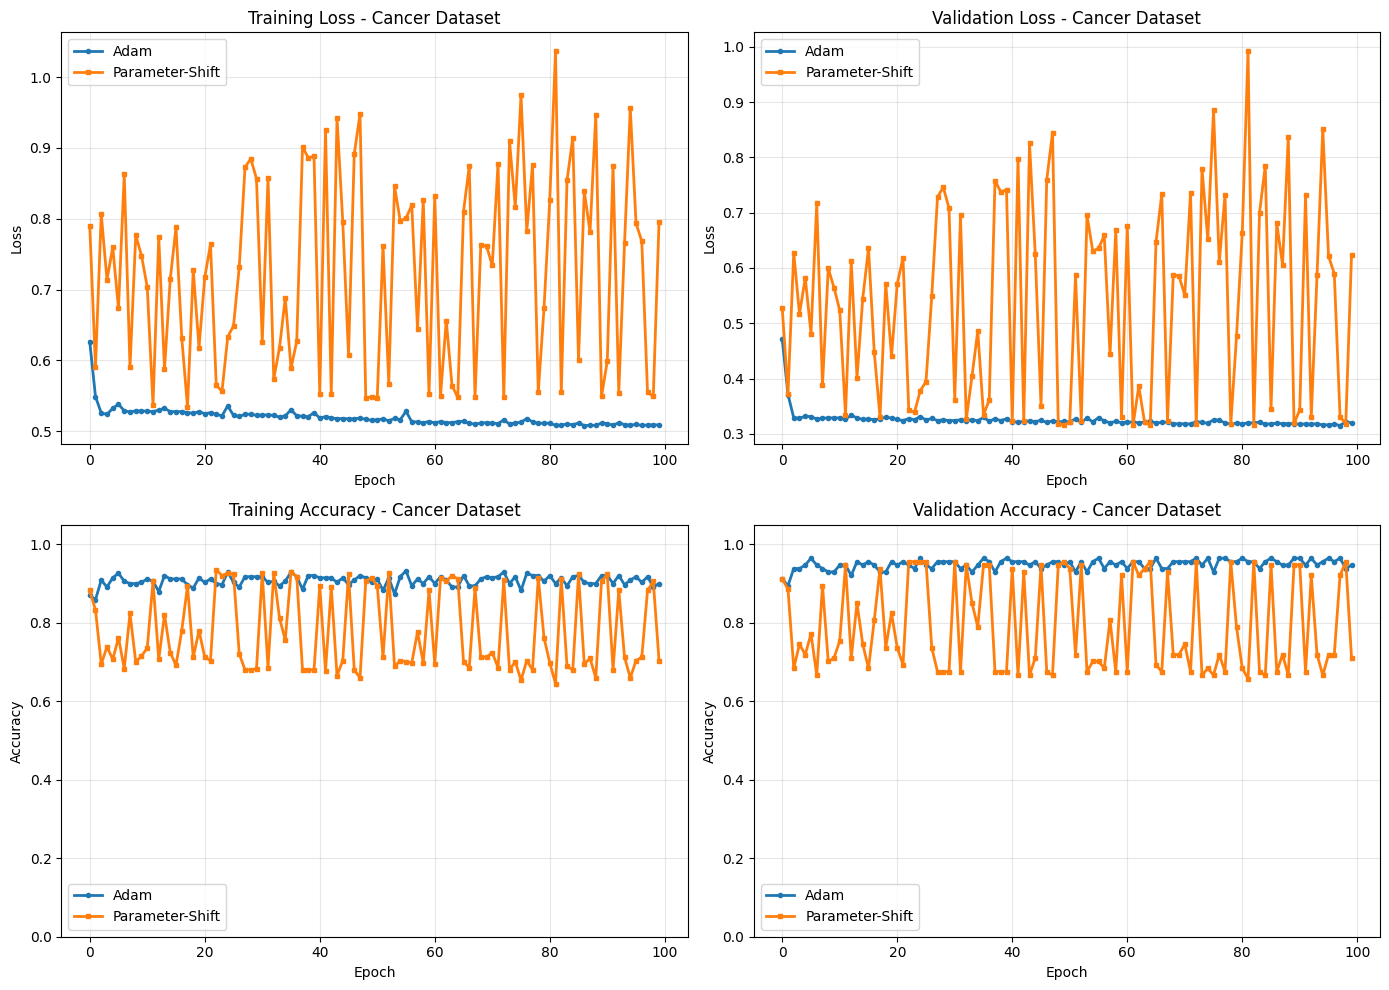

✓ Cancer dataset learning curves visualized


In [36]:
# Cell 35

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training Loss
axes[0, 0].plot(history_adam_cancer['train_loss'], label='Adam', linewidth=2, marker='o', markersize=3)
axes[0, 0].plot(history_ps_cancer['train_loss'], label='Parameter-Shift', linewidth=2, marker='s', markersize=3)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss - Cancer Dataset')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Loss
axes[0, 1].plot(history_adam_cancer['val_loss'], label='Adam', linewidth=2, marker='o', markersize=3)
axes[0, 1].plot(history_ps_cancer['val_loss'], label='Parameter-Shift', linewidth=2, marker='s', markersize=3)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Validation Loss - Cancer Dataset')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Training Accuracy
axes[1, 0].plot(history_adam_cancer['train_acc'], label='Adam', linewidth=2, marker='o', markersize=3)
axes[1, 0].plot(history_ps_cancer['train_acc'], label='Parameter-Shift', linewidth=2, marker='s', markersize=3)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Training Accuracy - Cancer Dataset')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1.05])

# Plot 4: Validation Accuracy
axes[1, 1].plot(history_adam_cancer['val_acc'], label='Adam', linewidth=2, marker='o', markersize=3)
axes[1, 1].plot(history_ps_cancer['val_acc'], label='Parameter-Shift', linewidth=2, marker='s', markersize=3)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Validation Accuracy - Cancer Dataset')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print("✓ Cancer dataset learning curves visualized")

In [37]:
# Cell 36

print("🧪 Evaluating Cancer Models on Test Set\n")
print("=" * 60)

# Evaluate Adam model
test_acc_adam_c, test_preds_adam_c = evaluate_accuracy(
    params_adam_cancer_trained, X_test_c, y_test_c, n_qubits_cancer, n_layers_cancer
)
test_loss_adam_c = compute_loss(
    params_adam_cancer_trained, X_test_c, y_test_c, n_qubits_cancer, n_layers_cancer
)

# Evaluate Parameter-Shift model
test_acc_ps_c, test_preds_ps_c = evaluate_accuracy(
    params_ps_cancer_trained, X_test_c, y_test_c, n_qubits_cancer, n_layers_cancer
)
test_loss_ps_c = compute_loss(
    params_ps_cancer_trained, X_test_c, y_test_c, n_qubits_cancer, n_layers_cancer
)

print(f"{'Model':<25} {'Test Accuracy':<20} {'Test Loss':<15}")
print("-" * 60)
print(f"{'Adam':<25} {test_acc_adam_c:<20.2%} {test_loss_adam_c:<15.4f}")
print(f"{'Parameter-Shift':<25} {test_acc_ps_c:<20.2%} {test_loss_ps_c:<15.4f}")
print("=" * 60)

# Clinical significance
print("\n🏥 Clinical Performance:")
print(f"   • Adam: {int(test_acc_adam_c * len(y_test_c))}/{len(y_test_c)} correct diagnoses")
print(f"   • Parameter-Shift: {int(test_acc_ps_c * len(y_test_c))}/{len(y_test_c)} correct diagnoses")

if test_acc_adam_c > test_acc_ps_c:
    print(f"\n🏆 Adam performs better (+{(test_acc_adam_c-test_acc_ps_c)*100:.1f}% accuracy)")
elif test_acc_ps_c > test_acc_adam_c:
    print(f"\n🏆 Parameter-Shift performs better (+{(test_acc_ps_c-test_acc_adam_c)*100:.1f}% accuracy)")
else:
    print(f"\n🤝 Both models achieve identical test accuracy!")

🧪 Evaluating Cancer Models on Test Set

Model                     Test Accuracy        Test Loss      
------------------------------------------------------------
Adam                      66.67%               0.7562         
Parameter-Shift           32.46%               1.8361         

🏥 Clinical Performance:
   • Adam: 76/114 correct diagnoses
   • Parameter-Shift: 37/114 correct diagnoses

🏆 Adam performs better (+34.2% accuracy)


In [38]:
# Cell 37

print("=" * 70)
print("📊 CANCER DATASET BENCHMARK: Adam vs Parameter-Shift")
print("=" * 70)

print(f"\n{'Metric':<30} {'Adam':<20} {'Parameter-Shift':<20}")
print("-" * 70)

# Time comparison
print(f"{'Training Time (s)':<30} {adam_time_cancer:<20.2f} {ps_time_cancer:<20.2f}")
print(f"{'Time per Epoch (s)':<30} {adam_time_cancer/n_epochs_cancer:<20.2f} {ps_time_cancer/n_epochs_cancer:<20.2f}")
print(f"{'Speedup Factor':<30} {'-':<20} {adam_time_cancer/ps_time_cancer:<20.2f}x")

print("\n" + "-" * 70)

# Accuracy comparison
print(f"{'Final Train Accuracy':<30} {history_adam_cancer['train_acc'][-1]:<20.2%} {history_ps_cancer['train_acc'][-1]:<20.2%}")
print(f"{'Final Val Accuracy':<30} {history_adam_cancer['val_acc'][-1]:<20.2%} {history_ps_cancer['val_acc'][-1]:<20.2%}")
print(f"{'Test Accuracy':<30} {test_acc_adam_c:<20.2%} {test_acc_ps_c:<20.2%}")
print(f"{'Best Val Accuracy':<30} {max(history_adam_cancer['val_acc']):<20.2%} {max(history_ps_cancer['val_acc']):<20.2%}")

print("\n" + "-" * 70)

# Loss comparison
print(f"{'Final Train Loss':<30} {history_adam_cancer['train_loss'][-1]:<20.4f} {history_ps_cancer['train_loss'][-1]:<20.4f}")
print(f"{'Final Val Loss':<30} {history_adam_cancer['val_loss'][-1]:<20.4f} {history_ps_cancer['val_loss'][-1]:<20.4f}")
print(f"{'Test Loss':<30} {test_loss_adam_c:<20.4f} {test_loss_ps_c:<20.4f}")

print("\n" + "=" * 70)

# Summary
best_val_acc_c = max(max(history_adam_cancer['val_acc']), max(history_ps_cancer['val_acc']))
print("\n💡 Key Insights (Cancer Dataset):")
print(f"   • Dataset: {len(X_cancer_reduced)} samples, 30→8 features (PCA)")
print(f"   • Adam is {adam_time_cancer/ps_time_cancer:.1f}x faster than Parameter-Shift")
print(f"   • Best validation accuracy: {best_val_acc_c:.1%}")
print(f"   • Circuit: {n_qubits_cancer} qubits, {n_layers_cancer} layers, {n_params_cancer} parameters")

if adam_time_cancer < ps_time_cancer and test_acc_adam_c >= test_acc_ps_c:
    winner = "Adam (speed + accuracy)"
elif test_acc_ps_c > test_acc_adam_c:
    winner = "Parameter-Shift (better accuracy)"
else:
    winner = "Tie (similar performance)"
    
print(f"   • Recommended optimizer: {winner}")

📊 CANCER DATASET BENCHMARK: Adam vs Parameter-Shift

Metric                         Adam                 Parameter-Shift     
----------------------------------------------------------------------
Training Time (s)              161.67               307.05              
Time per Epoch (s)             1.62                 3.07                
Speedup Factor                 -                    0.53                x

----------------------------------------------------------------------
Final Train Accuracy           90.03%               70.38%              
Final Val Accuracy             94.74%               71.05%              
Test Accuracy                  66.67%               32.46%              
Best Val Accuracy              96.49%               95.61%              

----------------------------------------------------------------------
Final Train Loss               0.5088               0.7955              
Final Val Loss                 0.3198               0.6241              
T

In [39]:
# Cell 38

print("🔍 OVERFITTING ANALYSIS\n")
print("=" * 70)

# Calculate train-test gaps
adam_overfit = history_adam_cancer['train_acc'][-1] - test_acc_adam_c
ps_overfit = history_ps_cancer['train_acc'][-1] - test_acc_ps_c

print(f"{'Model':<25} {'Train Acc':<15} {'Test Acc':<15} {'Gap (Overfit)':<15}")
print("-" * 70)
print(f"{'Adam':<25} {history_adam_cancer['train_acc'][-1]:<15.2%} {test_acc_adam_c:<15.2%} {adam_overfit:<15.2%}")
print(f"{'Parameter-Shift':<25} {history_ps_cancer['train_acc'][-1]:<15.2%} {test_acc_ps_c:<15.2%} {ps_overfit:<15.2%}")

print("\n" + "=" * 70)
print("\n⚠️  Signs of Overfitting Detected:")
print(f"   • Large train-test accuracy gap (>10%)")
print(f"   • Training accuracy high (~{history_adam_cancer['train_acc'][-1]:.0%}) but test low (~{test_acc_adam_c:.0%})")
print(f"   • Model memorizing training data instead of learning patterns")

print("\n💡 Solutions to Reduce Overfitting:")
print("   1. 🎯 L2 Regularization (parameter penalty)")
print("   2. 🔄 Data Augmentation (noise injection)")
print("   3. 📉 Reduce circuit depth (fewer layers)")
print("   4. 🎲 Dropout-like quantum noise")
print("   5. 🛑 Early stopping (monitor validation)")
print("   6. 📊 Increase training data")

🔍 OVERFITTING ANALYSIS

Model                     Train Acc       Test Acc        Gap (Overfit)  
----------------------------------------------------------------------
Adam                      90.03%          66.67%          23.36%         
Parameter-Shift           70.38%          32.46%          37.93%         


⚠️  Signs of Overfitting Detected:
   • Large train-test accuracy gap (>10%)
   • Training accuracy high (~90%) but test low (~67%)
   • Model memorizing training data instead of learning patterns

💡 Solutions to Reduce Overfitting:
   1. 🎯 L2 Regularization (parameter penalty)
   2. 🔄 Data Augmentation (noise injection)
   3. 📉 Reduce circuit depth (fewer layers)
   4. 🎲 Dropout-like quantum noise
   5. 🛑 Early stopping (monitor validation)
   6. 📊 Increase training data


In [40]:
# Cell 39

def compute_loss_with_l2(params, X_batch, y_batch, n_qubits, n_layers, lambda_l2=0.01):
    """
    MSE loss with L2 regularization penalty.
    Loss = MSE + λ * ||params||²
    """
    predictions = []
    targets = 2 * y_batch - 1  # Map {0,1} to {-1,+1}
    
    for i in range(len(X_batch)):
        pred = predict(X_batch[i], params, n_qubits, n_layers)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    mse_loss = np.mean((predictions - targets) ** 2)
    
    # L2 regularization penalty
    l2_penalty = lambda_l2 * np.sum(params ** 2)
    
    total_loss = mse_loss + l2_penalty
    
    return total_loss

# Test with different lambda values
lambda_values = [0.0, 0.001, 0.01, 0.1]
print("🎯 L2 Regularization Impact:\n")
print(f"{'Lambda':<15} {'Loss (no reg)':<20} {'Loss (with reg)':<20} {'Penalty':<15}")
print("-" * 70)

base_loss = compute_loss(params_cancer, X_train_c[:5], y_train_c[:5], n_qubits_cancer, n_layers_cancer)

for lam in lambda_values:
    reg_loss = compute_loss_with_l2(params_cancer, X_train_c[:5], y_train_c[:5], n_qubits_cancer, n_layers_cancer, lam)
    penalty = lam * np.sum(params_cancer ** 2)
    print(f"{lam:<15} {base_loss:<20.4f} {reg_loss:<20.4f} {penalty:<15.4f}")

print("\n✓ L2 regularization function ready")
print("  Recommended λ: 0.001 - 0.01 for quantum circuits")

🎯 L2 Regularization Impact:

Lambda          Loss (no reg)        Loss (with reg)      Penalty        
----------------------------------------------------------------------
0.0             1.3273               1.3273               0.0000         
0.001           1.3273               1.5884               0.2611         
0.01            1.3273               3.9382               2.6110         
0.1             1.3273               27.4369              26.1096        

✓ L2 regularization function ready
  Recommended λ: 0.001 - 0.01 for quantum circuits


In [41]:
# Cell 40

def add_quantum_dropout(circuit, n_qubits, dropout_rate=0.1):
    """
    Add quantum dropout via depolarizing noise.
    Applies random Pauli rotations to simulate decoherence.
    """
    if dropout_rate <= 0:
        return circuit
    
    for qubit in range(n_qubits):
        # Random angle for noise simulation
        noise_angle = np.random.uniform(0, dropout_rate * np.pi)
        
        # Randomly choose which Pauli rotation to apply
        choice = np.random.rand()
        if choice < 0.33:
            circuit.add_RX_gate(qubit, noise_angle)
        elif choice < 0.66:
            circuit.add_RY_gate(qubit, noise_angle)
        else:
            circuit.add_RZ_gate(qubit, noise_angle)
    
    return circuit

def create_qnn_circuit_with_dropout(x, params, n_qubits, n_layers, dropout_rate=0.1, training=True):
    """
    QNN circuit with dropout regularization.
    Only apply dropout during training, not during evaluation.
    """
    circuit = QuantumCircuit(n_qubits)
    
    # Encode data
    circuit = encode_data(circuit, x, n_qubits)
    
    # Variational layers with dropout
    param_idx = 0
    for layer in range(n_layers):
        # Rotation gates
        for qubit in range(n_qubits):
            circuit.add_RX_gate(qubit, params[param_idx])
            circuit.add_RY_gate(qubit, params[param_idx + 1])
            circuit.add_RZ_gate(qubit, params[param_idx + 2])
            param_idx += 3
        
        # Entanglement
        for qubit in range(n_qubits - 1):
            circuit.add_CNOT_gate(qubit, qubit + 1)
        
        # Apply dropout after each layer (only during training)
        if training and dropout_rate > 0:
            circuit = add_quantum_dropout(circuit, n_qubits, dropout_rate)
    
    return circuit

print("✓ Quantum dropout (random Pauli rotations) implemented")
print("  Dropout: Adds random rotation noise during training")
print("  Acts as regularization by preventing overfitting")

✓ Quantum dropout (random Pauli rotations) implemented
  Dropout: Adds random rotation noise during training
  Acts as regularization by preventing overfitting


In [42]:
# Cell 41

def predict_with_dropout(x, params, n_qubits, n_layers, dropout_rate=0.0, training=True):
    """Prediction with optional dropout."""
    circuit = create_qnn_circuit_with_dropout(x, params, n_qubits, n_layers, dropout_rate, training)
    state = QuantumState(n_qubits)
    state.set_zero_state()
    circuit.update_quantum_state(state)
    
    observable = Observable(n_qubits)
    observable.add_operator(1.0, "Z 0")
    
    expectation = observable.get_expectation_value(state)
    return expectation

def compute_loss_dropout_l2(params, X_batch, y_batch, n_qubits, n_layers, 
                            lambda_l2=0.01, dropout_rate=0.1, training=True):
    """
    Combined loss: MSE + L2 regularization + Dropout.
    """
    predictions = []
    targets = 2 * y_batch - 1
    
    for i in range(len(X_batch)):
        pred = predict_with_dropout(X_batch[i], params, n_qubits, n_layers, dropout_rate, training)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    mse_loss = np.mean((predictions - targets) ** 2)
    l2_penalty = lambda_l2 * np.sum(params ** 2)
    
    total_loss = mse_loss + l2_penalty
    return total_loss

def evaluate_accuracy_dropout(params, X, y, n_qubits, n_layers):
    """Evaluate without dropout (training=False)."""
    correct = 0
    predictions = []
    
    for i in range(len(X)):
        pred_value = predict_with_dropout(X[i], params, n_qubits, n_layers, dropout_rate=0.0, training=False)
        pred_class = int(pred_value > 0)
        predictions.append(pred_class)
        
        if pred_class == y[i]:
            correct += 1
    
    accuracy = correct / len(X)
    return accuracy, np.array(predictions)

print("✓ Combined Dropout + L2 regularization functions ready")
print("  • L2: Penalizes large parameter values")
print("  • Dropout: Adds quantum noise during training")
print("  • Evaluation: Dropout disabled for inference")

✓ Combined Dropout + L2 regularization functions ready
  • L2: Penalizes large parameter values
  • Dropout: Adds quantum noise during training
  • Evaluation: Dropout disabled for inference


In [43]:
# Cell 42

def train_adam_regularized(params_init, X_train, y_train, X_val, y_val, n_epochs, 
                          n_samples_per_gradient, lambda_l2=0.01, dropout_rate=0.1):
    """
    Train with Adam + L2 regularization + Dropout.
    """
    params = params_init.copy()
    optimizer = AdamOptimizer(learning_rate=learning_rate_adam)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    print(f"🚀 Starting Regularized Adam Training")
    print(f"   L2 λ={lambda_l2}, Dropout={dropout_rate}\n")
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(len(X_train))
        epoch_loss = 0
        
        pbar = tqdm(range(0, len(X_train), batch_size_cancer), 
                    desc=f"Epoch {epoch+1}/{n_epochs}",
                    ncols=100,
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')
        
        for i in pbar:
            batch_idx = indices[i:i+batch_size_cancer]
            X_batch = X_train[batch_idx][:n_samples_per_gradient]
            y_batch = y_train[batch_idx][:n_samples_per_gradient]
            
            # Compute gradients with regularization
            grads = finite_difference_gradient_regularized(
                params, X_batch, y_batch, n_qubits_cancer, n_layers_cancer, 
                lambda_l2, dropout_rate
            )
            
            params = optimizer.step(params, grads)
            
            loss = compute_loss_dropout_l2(params, X_batch, y_batch, 
                                          n_qubits_cancer, n_layers_cancer, 
                                          lambda_l2, dropout_rate, training=True)
            epoch_loss += loss
            pbar.set_postfix({'loss': f'{loss:.4f}'})
        
        # Evaluate (no dropout)
        train_loss = compute_loss_dropout_l2(params, X_train[:20], y_train[:20], 
                                            n_qubits_cancer, n_layers_cancer, 
                                            lambda_l2, 0.0, training=False)
        val_loss = compute_loss_dropout_l2(params, X_val, y_val, 
                                          n_qubits_cancer, n_layers_cancer, 
                                          lambda_l2, 0.0, training=False)
        train_acc, _ = evaluate_accuracy_dropout(params, X_train, y_train, n_qubits_cancer, n_layers_cancer)
        val_acc, _ = evaluate_accuracy_dropout(params, X_val, y_val, n_qubits_cancer, n_layers_cancer)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"  ├─ Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Acc: {train_acc:.2%} - Val Acc: {val_acc:.2%}\n")
    
    return params, history

def finite_difference_gradient_regularized(params, X_batch, y_batch, n_qubits, n_layers, 
                                          lambda_l2, dropout_rate, epsilon=1e-4):
    """Finite difference with regularization."""
    gradients = np.zeros_like(params)
    loss_current = compute_loss_dropout_l2(params, X_batch, y_batch, n_qubits, n_layers, 
                                          lambda_l2, dropout_rate, training=True)
    
    for i in range(len(params)):
        params_shifted = params.copy()
        params_shifted[i] += epsilon
        loss_shifted = compute_loss_dropout_l2(params_shifted, X_batch, y_batch, n_qubits, n_layers, 
                                              lambda_l2, dropout_rate, training=True)
        
        gradients[i] = (loss_shifted - loss_current) / epsilon
    
    return gradients

print("✓ Regularized training loop ready")

✓ Regularized training loop ready


In [44]:
# Cell 43

# Hyperparameters for regularization
lambda_l2_cancer = 0.005  # L2 regularization strength
dropout_rate_cancer = 0.15  # Quantum dropout rate

print(f"🎯 Regularization Configuration:")
print(f"   L2 λ: {lambda_l2_cancer}")
print(f"   Dropout rate: {dropout_rate_cancer}")
print(f"   Expected: Reduced overfitting, better generalization\n")

# Initialize fresh parameters
np.random.seed(42)
params_adam_reg = np.random.uniform(-np.pi, np.pi, size=n_params_cancer)

# Train with regularization
start_time = time.time()

params_adam_reg_trained, history_adam_reg = train_adam_regularized(
    params_adam_reg,
    X_train_c,
    y_train_c,
    X_val_c,
    y_val_c,
    n_epochs_cancer,
    n_samples_per_gradient_cancer,
    lambda_l2=lambda_l2_cancer,
    dropout_rate=dropout_rate_cancer
)

adam_reg_time = time.time() - start_time

print(f"\n✅ Regularized Training Complete!")
print(f"   Time: {adam_reg_time:.2f}s")
print(f"   Final Train Acc: {history_adam_reg['train_acc'][-1]:.2%}")
print(f"   Final Val Acc: {history_adam_reg['val_acc'][-1]:.2%}")

🎯 Regularization Configuration:
   L2 λ: 0.005
   Dropout rate: 0.15
   Expected: Reduced overfitting, better generalization

🚀 Starting Regularized Adam Training
   L2 λ=0.005, Dropout=0.15



Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4459 - Val Loss: 2.8145 - Acc: 24.93% - Val Acc: 15.79%



Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4432 - Val Loss: 2.8258 - Acc: 29.03% - Val Acc: 19.30%



Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4637 - Val Loss: 2.8352 - Acc: 28.74% - Val Acc: 16.67%



Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4700 - Val Loss: 2.8550 - Acc: 30.21% - Val Acc: 19.30%



Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4955 - Val Loss: 2.8800 - Acc: 20.82% - Val Acc: 11.40%



Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4864 - Val Loss: 2.8812 - Acc: 28.74% - Val Acc: 18.42%



Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4666 - Val Loss: 2.8416 - Acc: 30.50% - Val Acc: 18.42%



Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4536 - Val Loss: 2.7977 - Acc: 28.74% - Val Acc: 20.18%



Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4200 - Val Loss: 2.7432 - Acc: 35.78% - Val Acc: 25.44%



Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.3984 - Val Loss: 2.7152 - Acc: 36.95% - Val Acc: 30.70%



Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.3971 - Val Loss: 2.7265 - Acc: 36.95% - Val Acc: 30.70%



Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4000 - Val Loss: 2.7339 - Acc: 37.54% - Val Acc: 30.70%



Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4144 - Val Loss: 2.7511 - Acc: 37.54% - Val Acc: 30.70%



Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4334 - Val Loss: 2.7797 - Acc: 36.95% - Val Acc: 28.07%



Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4530 - Val Loss: 2.7965 - Acc: 27.57% - Val Acc: 17.54%



Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4539 - Val Loss: 2.7918 - Acc: 22.87% - Val Acc: 14.91%



Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4772 - Val Loss: 2.8288 - Acc: 16.42% - Val Acc: 9.65%



Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4814 - Val Loss: 2.8515 - Acc: 16.72% - Val Acc: 9.65%



Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4968 - Val Loss: 2.8796 - Acc: 17.30% - Val Acc: 11.40%



Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4722 - Val Loss: 2.8597 - Acc: 17.30% - Val Acc: 9.65%



Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4411 - Val Loss: 2.8337 - Acc: 23.75% - Val Acc: 13.16%



Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.3968 - Val Loss: 2.7843 - Acc: 29.03% - Val Acc: 15.79%



Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4139 - Val Loss: 2.8024 - Acc: 23.75% - Val Acc: 11.40%



Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4416 - Val Loss: 2.8300 - Acc: 15.84% - Val Acc: 8.77%



Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.3965 - Val Loss: 2.7795 - Acc: 23.75% - Val Acc: 11.40%



Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.3813 - Val Loss: 2.7532 - Acc: 25.81% - Val Acc: 13.16%



Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.3715 - Val Loss: 2.7219 - Acc: 27.27% - Val Acc: 14.04%



Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.3976 - Val Loss: 2.7567 - Acc: 21.99% - Val Acc: 9.65%



Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.3956 - Val Loss: 2.7600 - Acc: 28.45% - Val Acc: 15.79%



Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4051 - Val Loss: 2.7852 - Acc: 34.60% - Val Acc: 21.05%



Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4177 - Val Loss: 2.8144 - Acc: 37.83% - Val Acc: 23.68%



Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.3971 - Val Loss: 2.7788 - Acc: 39.00% - Val Acc: 23.68%



Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4287 - Val Loss: 2.8335 - Acc: 36.36% - Val Acc: 20.18%



Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4159 - Val Loss: 2.8136 - Acc: 34.31% - Val Acc: 20.18%



Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4380 - Val Loss: 2.8372 - Acc: 28.45% - Val Acc: 16.67%



Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4624 - Val Loss: 2.8543 - Acc: 25.81% - Val Acc: 11.40%



Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.4935 - Val Loss: 2.8888 - Acc: 28.45% - Val Acc: 15.79%



Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5290 - Val Loss: 2.9177 - Acc: 18.77% - Val Acc: 9.65%



Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5043 - Val Loss: 2.8822 - Acc: 15.25% - Val Acc: 10.53%



Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5701 - Val Loss: 2.9504 - Acc: 11.73% - Val Acc: 9.65%



Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5912 - Val Loss: 2.9529 - Acc: 10.56% - Val Acc: 9.65%



Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5833 - Val Loss: 2.9363 - Acc: 11.73% - Val Acc: 9.65%



Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5632 - Val Loss: 2.9172 - Acc: 14.66% - Val Acc: 9.65%



Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6060 - Val Loss: 2.9297 - Acc: 12.02% - Val Acc: 9.65%



Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5652 - Val Loss: 2.8567 - Acc: 13.20% - Val Acc: 10.53%



Epoch 46/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5315 - Val Loss: 2.8078 - Acc: 15.84% - Val Acc: 10.53%



Epoch 47/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5184 - Val Loss: 2.7899 - Acc: 14.66% - Val Acc: 11.40%



Epoch 48/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5228 - Val Loss: 2.8291 - Acc: 18.77% - Val Acc: 9.65%



Epoch 49/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5285 - Val Loss: 2.8397 - Acc: 24.05% - Val Acc: 11.40%



Epoch 50/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5559 - Val Loss: 2.9143 - Acc: 22.29% - Val Acc: 13.16%



Epoch 51/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5599 - Val Loss: 2.9174 - Acc: 20.53% - Val Acc: 10.53%



Epoch 52/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5560 - Val Loss: 2.9015 - Acc: 29.33% - Val Acc: 17.54%



Epoch 53/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5683 - Val Loss: 2.9033 - Acc: 22.29% - Val Acc: 13.16%



Epoch 54/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5806 - Val Loss: 2.9076 - Acc: 18.77% - Val Acc: 10.53%



Epoch 55/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5793 - Val Loss: 2.9070 - Acc: 19.65% - Val Acc: 11.40%



Epoch 56/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5248 - Val Loss: 2.8662 - Acc: 30.21% - Val Acc: 17.54%



Epoch 57/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5200 - Val Loss: 2.8602 - Acc: 20.23% - Val Acc: 12.28%



Epoch 58/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5608 - Val Loss: 2.9037 - Acc: 14.66% - Val Acc: 9.65%



Epoch 59/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6030 - Val Loss: 2.9326 - Acc: 11.73% - Val Acc: 8.77%



Epoch 60/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6407 - Val Loss: 2.9495 - Acc: 9.09% - Val Acc: 6.14%



Epoch 61/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.7148 - Val Loss: 3.0192 - Acc: 8.21% - Val Acc: 7.89%



Epoch 62/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.7257 - Val Loss: 3.0381 - Acc: 7.04% - Val Acc: 5.26%



Epoch 63/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.7136 - Val Loss: 3.0471 - Acc: 10.56% - Val Acc: 7.02%



Epoch 64/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6815 - Val Loss: 3.0019 - Acc: 9.38% - Val Acc: 6.14%



Epoch 65/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6689 - Val Loss: 2.9783 - Acc: 9.97% - Val Acc: 7.02%



Epoch 66/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6132 - Val Loss: 2.8925 - Acc: 10.26% - Val Acc: 7.02%



Epoch 67/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6347 - Val Loss: 2.9180 - Acc: 9.38% - Val Acc: 6.14%



Epoch 68/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6640 - Val Loss: 2.9712 - Acc: 9.97% - Val Acc: 4.39%



Epoch 69/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6290 - Val Loss: 2.9460 - Acc: 11.44% - Val Acc: 7.89%



Epoch 70/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5865 - Val Loss: 2.8881 - Acc: 10.56% - Val Acc: 9.65%



Epoch 71/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5590 - Val Loss: 2.8347 - Acc: 13.49% - Val Acc: 9.65%



Epoch 72/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5308 - Val Loss: 2.7892 - Acc: 19.65% - Val Acc: 11.40%



Epoch 73/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5231 - Val Loss: 2.7874 - Acc: 15.84% - Val Acc: 9.65%



Epoch 74/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5847 - Val Loss: 2.8589 - Acc: 10.85% - Val Acc: 8.77%



Epoch 75/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5914 - Val Loss: 2.8603 - Acc: 9.68% - Val Acc: 7.02%



Epoch 76/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6090 - Val Loss: 2.8925 - Acc: 10.56% - Val Acc: 7.89%



Epoch 77/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5917 - Val Loss: 2.8794 - Acc: 17.30% - Val Acc: 10.53%



Epoch 78/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6059 - Val Loss: 2.8740 - Acc: 13.78% - Val Acc: 8.77%



Epoch 79/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5970 - Val Loss: 2.8413 - Acc: 13.49% - Val Acc: 8.77%



Epoch 80/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6005 - Val Loss: 2.8369 - Acc: 10.56% - Val Acc: 7.02%



Epoch 81/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6494 - Val Loss: 2.8972 - Acc: 8.21% - Val Acc: 4.39%



Epoch 82/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6193 - Val Loss: 2.8682 - Acc: 9.09% - Val Acc: 6.14%



Epoch 83/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6591 - Val Loss: 2.9348 - Acc: 7.92% - Val Acc: 6.14%



Epoch 84/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6946 - Val Loss: 2.9486 - Acc: 11.73% - Val Acc: 9.65%



Epoch 85/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.7011 - Val Loss: 2.9392 - Acc: 13.20% - Val Acc: 10.53%



Epoch 86/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.7339 - Val Loss: 2.9699 - Acc: 13.20% - Val Acc: 12.28%



Epoch 87/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.7584 - Val Loss: 2.9872 - Acc: 14.08% - Val Acc: 13.16%



Epoch 88/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.7551 - Val Loss: 2.9906 - Acc: 13.49% - Val Acc: 12.28%



Epoch 89/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.7656 - Val Loss: 2.9883 - Acc: 13.78% - Val Acc: 12.28%



Epoch 90/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.7943 - Val Loss: 2.9667 - Acc: 20.23% - Val Acc: 15.79%



Epoch 91/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.8329 - Val Loss: 2.9852 - Acc: 22.29% - Val Acc: 15.79%



Epoch 92/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.8324 - Val Loss: 2.9616 - Acc: 24.05% - Val Acc: 18.42%



Epoch 93/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.8008 - Val Loss: 2.9075 - Acc: 26.98% - Val Acc: 20.18%



Epoch 94/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.7940 - Val Loss: 2.9167 - Acc: 24.05% - Val Acc: 18.42%



Epoch 95/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.7735 - Val Loss: 2.9230 - Acc: 22.29% - Val Acc: 17.54%



Epoch 96/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.7547 - Val Loss: 2.9142 - Acc: 21.41% - Val Acc: 16.67%



Epoch 97/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6636 - Val Loss: 2.8051 - Acc: 20.82% - Val Acc: 17.54%



Epoch 98/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6498 - Val Loss: 2.8148 - Acc: 17.89% - Val Acc: 14.04%



Epoch 99/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.5696 - Val Loss: 2.7267 - Acc: 18.77% - Val Acc: 14.04%



Epoch 100/100: 100%|███████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 2.6077 - Val Loss: 2.7895 - Acc: 17.01% - Val Acc: 13.16%


✅ Regularized Training Complete!
   Time: 355.86s
   Final Train Acc: 17.01%
   Final Val Acc: 13.16%


In [45]:
# Cell 44

print("🔧 Debugging Regularization Issue\n")
print("Problem: Regularization too strong → model can't learn")
print("Solution: Reduce λ and dropout significantly\n")

# Much weaker regularization
lambda_l2_weak = 0.0001  # Reduced from 0.005 (50x weaker)
dropout_rate_weak = 0.02  # Reduced from 0.15 (7.5x weaker)

print(f"New Configuration:")
print(f"   L2 λ: {lambda_l2_weak} (was {lambda_l2_cancer})")
print(f"   Dropout rate: {dropout_rate_weak} (was {dropout_rate_cancer})")
print(f"   Strategy: Start gentle, can increase if still overfitting\n")

# Initialize fresh parameters
np.random.seed(42)
params_adam_reg_v2 = np.random.uniform(-np.pi, np.pi, size=n_params_cancer)

# Train with weaker regularization
start_time = time.time()

params_adam_reg_v2_trained, history_adam_reg_v2 = train_adam_regularized(
    params_adam_reg_v2,
    X_train_c,
    y_train_c,
    X_val_c,
    y_val_c,
    n_epochs_cancer,
    n_samples_per_gradient_cancer,
    lambda_l2=lambda_l2_weak,
    dropout_rate=dropout_rate_weak
)

adam_reg_v2_time = time.time() - start_time

print(f"\n✅ Regularized Training v2 Complete!")
print(f"   Time: {adam_reg_v2_time:.2f}s")
print(f"   Final Train Acc: {history_adam_reg_v2['train_acc'][-1]:.2%}")
print(f"   Final Val Acc: {history_adam_reg_v2['val_acc'][-1]:.2%}")

🔧 Debugging Regularization Issue

Problem: Regularization too strong → model can't learn
Solution: Reduce λ and dropout significantly

New Configuration:
   L2 λ: 0.0001 (was 0.005)
   Dropout rate: 0.02 (was 0.15)
   Strategy: Start gentle, can increase if still overfitting

🚀 Starting Regularized Adam Training
   L2 λ=0.0001, Dropout=0.02



Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1578 - Val Loss: 1.5195 - Acc: 24.93% - Val Acc: 15.79%



Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1382 - Val Loss: 1.5066 - Acc: 31.38% - Val Acc: 21.93%



Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1343 - Val Loss: 1.4915 - Acc: 34.31% - Val Acc: 26.32%



Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1306 - Val Loss: 1.5002 - Acc: 36.66% - Val Acc: 28.07%



Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1514 - Val Loss: 1.5180 - Acc: 30.21% - Val Acc: 19.30%



Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1457 - Val Loss: 1.5169 - Acc: 35.48% - Val Acc: 21.93%



Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1419 - Val Loss: 1.4944 - Acc: 35.19% - Val Acc: 23.68%



Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1397 - Val Loss: 1.4618 - Acc: 32.26% - Val Acc: 21.93%



Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1152 - Val Loss: 1.4116 - Acc: 36.66% - Val Acc: 28.07%



Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0954 - Val Loss: 1.3828 - Acc: 38.42% - Val Acc: 32.46%



Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0993 - Val Loss: 1.4000 - Acc: 38.42% - Val Acc: 32.46%



Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1038 - Val Loss: 1.4049 - Acc: 36.95% - Val Acc: 32.46%



Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1089 - Val Loss: 1.4123 - Acc: 36.66% - Val Acc: 29.82%



Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1207 - Val Loss: 1.4329 - Acc: 35.48% - Val Acc: 28.07%



Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1502 - Val Loss: 1.4644 - Acc: 24.34% - Val Acc: 16.67%



Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1622 - Val Loss: 1.4756 - Acc: 20.82% - Val Acc: 14.91%



Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.2057 - Val Loss: 1.5352 - Acc: 13.20% - Val Acc: 7.89%



Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.2223 - Val Loss: 1.5717 - Acc: 11.73% - Val Acc: 8.77%



Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.2371 - Val Loss: 1.5997 - Acc: 11.44% - Val Acc: 8.77%



Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.2349 - Val Loss: 1.6032 - Acc: 11.73% - Val Acc: 8.77%



Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.2052 - Val Loss: 1.5795 - Acc: 13.49% - Val Acc: 7.89%



Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1611 - Val Loss: 1.5344 - Acc: 19.94% - Val Acc: 9.65%



Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1813 - Val Loss: 1.5542 - Acc: 14.66% - Val Acc: 8.77%



Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.2074 - Val Loss: 1.5775 - Acc: 11.73% - Val Acc: 8.77%



Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.1670 - Val Loss: 1.5353 - Acc: 16.42% - Val Acc: 10.53%



Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.1563 - Val Loss: 1.5121 - Acc: 18.48% - Val Acc: 11.40%



Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1269 - Val Loss: 1.4564 - Acc: 22.58% - Val Acc: 10.53%



Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1297 - Val Loss: 1.4633 - Acc: 22.29% - Val Acc: 8.77%



Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1164 - Val Loss: 1.4527 - Acc: 26.98% - Val Acc: 14.91%



Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1107 - Val Loss: 1.4605 - Acc: 32.55% - Val Acc: 22.81%



Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.1016 - Val Loss: 1.4575 - Acc: 37.83% - Val Acc: 26.32%



Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.0801 - Val Loss: 1.4204 - Acc: 41.06% - Val Acc: 30.70%



Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0968 - Val Loss: 1.4551 - Acc: 39.00% - Val Acc: 26.32%



Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.0796 - Val Loss: 1.4269 - Acc: 40.76% - Val Acc: 29.82%



Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.0926 - Val Loss: 1.4355 - Acc: 38.12% - Val Acc: 23.68%



Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1023 - Val Loss: 1.4333 - Acc: 35.78% - Val Acc: 20.18%



Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1114 - Val Loss: 1.4448 - Acc: 35.78% - Val Acc: 19.30%



Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.1384 - Val Loss: 1.4733 - Acc: 26.98% - Val Acc: 14.04%



Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1363 - Val Loss: 1.4698 - Acc: 24.93% - Val Acc: 12.28%



Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1727 - Val Loss: 1.5081 - Acc: 15.84% - Val Acc: 9.65%



Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1819 - Val Loss: 1.5122 - Acc: 14.37% - Val Acc: 9.65%



Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1652 - Val Loss: 1.4830 - Acc: 21.11% - Val Acc: 10.53%



Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.1369 - Val Loss: 1.4494 - Acc: 30.21% - Val Acc: 19.30%



Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1485 - Val Loss: 1.4273 - Acc: 27.86% - Val Acc: 14.04%



Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1100 - Val Loss: 1.3651 - Acc: 35.78% - Val Acc: 21.05%



Epoch 46/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0719 - Val Loss: 1.3163 - Acc: 44.28% - Val Acc: 30.70%



Epoch 47/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0687 - Val Loss: 1.3185 - Acc: 42.23% - Val Acc: 30.70%



Epoch 48/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0755 - Val Loss: 1.3495 - Acc: 46.63% - Val Acc: 33.33%



Epoch 49/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.0748 - Val Loss: 1.3595 - Acc: 47.80% - Val Acc: 33.33%



Epoch 50/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0895 - Val Loss: 1.4141 - Acc: 46.92% - Val Acc: 30.70%



Epoch 51/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0736 - Val Loss: 1.3868 - Acc: 50.44% - Val Acc: 34.21%



Epoch 52/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0578 - Val Loss: 1.3451 - Acc: 52.79% - Val Acc: 40.35%



Epoch 53/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.0685 - Val Loss: 1.3523 - Acc: 50.73% - Val Acc: 35.09%



Epoch 54/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.0897 - Val Loss: 1.3675 - Acc: 46.04% - Val Acc: 28.07%



Epoch 55/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.0829 - Val Loss: 1.3582 - Acc: 46.04% - Val Acc: 28.95%



Epoch 56/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0519 - Val Loss: 1.3274 - Acc: 51.91% - Val Acc: 39.47%



Epoch 57/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0503 - Val Loss: 1.3313 - Acc: 48.97% - Val Acc: 35.96%



Epoch 58/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0606 - Val Loss: 1.3476 - Acc: 46.33% - Val Acc: 34.21%



Epoch 59/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0742 - Val Loss: 1.3564 - Acc: 43.99% - Val Acc: 32.46%



Epoch 60/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1155 - Val Loss: 1.3932 - Acc: 28.74% - Val Acc: 15.79%



Epoch 61/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1562 - Val Loss: 1.4263 - Acc: 14.08% - Val Acc: 10.53%



Epoch 62/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1425 - Val Loss: 1.3943 - Acc: 19.94% - Val Acc: 14.04%



Epoch 63/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1155 - Val Loss: 1.3663 - Acc: 32.55% - Val Acc: 20.18%



Epoch 64/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1030 - Val Loss: 1.3474 - Acc: 34.02% - Val Acc: 20.18%



Epoch 65/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.0981 - Val Loss: 1.3214 - Acc: 38.71% - Val Acc: 21.05%



Epoch 66/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0596 - Val Loss: 1.2643 - Acc: 44.28% - Val Acc: 28.07%



Epoch 67/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0617 - Val Loss: 1.2676 - Acc: 45.75% - Val Acc: 28.95%



Epoch 68/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.0823 - Val Loss: 1.2982 - Acc: 44.87% - Val Acc: 27.19%



Epoch 69/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0697 - Val Loss: 1.3024 - Acc: 50.44% - Val Acc: 32.46%



Epoch 70/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0536 - Val Loss: 1.2846 - Acc: 51.61% - Val Acc: 36.84%



Epoch 71/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0292 - Val Loss: 1.2202 - Acc: 56.30% - Val Acc: 47.37%



Epoch 72/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0021 - Val Loss: 1.1598 - Acc: 59.53% - Val Acc: 55.26%



Epoch 73/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.0042 - Val Loss: 1.1743 - Acc: 59.24% - Val Acc: 56.14%



Epoch 74/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0360 - Val Loss: 1.2198 - Acc: 51.91% - Val Acc: 39.47%



Epoch 75/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0476 - Val Loss: 1.2333 - Acc: 49.85% - Val Acc: 33.33%



Epoch 76/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0539 - Val Loss: 1.2555 - Acc: 47.51% - Val Acc: 34.21%



Epoch 77/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0306 - Val Loss: 1.2276 - Acc: 54.84% - Val Acc: 44.74%



Epoch 78/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.0310 - Val Loss: 1.2098 - Acc: 54.55% - Val Acc: 45.61%



Epoch 79/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0162 - Val Loss: 1.1699 - Acc: 56.60% - Val Acc: 49.12%



Epoch 80/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0200 - Val Loss: 1.1777 - Acc: 55.43% - Val Acc: 47.37%



Epoch 81/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0530 - Val Loss: 1.2304 - Acc: 50.73% - Val Acc: 33.33%



Epoch 82/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0546 - Val Loss: 1.2485 - Acc: 47.51% - Val Acc: 32.46%



Epoch 83/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.0780 - Val Loss: 1.3027 - Acc: 37.54% - Val Acc: 21.05%



Epoch 84/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1161 - Val Loss: 1.3406 - Acc: 19.94% - Val Acc: 12.28%



Epoch 85/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1208 - Val Loss: 1.3353 - Acc: 16.72% - Val Acc: 13.16%



Epoch 86/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1395 - Val Loss: 1.3661 - Acc: 14.96% - Val Acc: 11.40%



Epoch 87/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1455 - Val Loss: 1.3621 - Acc: 13.49% - Val Acc: 11.40%



Epoch 88/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1466 - Val Loss: 1.3664 - Acc: 13.49% - Val Acc: 10.53%



Epoch 89/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1647 - Val Loss: 1.3741 - Acc: 11.73% - Val Acc: 8.77%



Epoch 90/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.2187 - Val Loss: 1.3817 - Acc: 14.96% - Val Acc: 11.40%



Epoch 91/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.2715 - Val Loss: 1.4275 - Acc: 17.60% - Val Acc: 14.91%



Epoch 92/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.2889 - Val Loss: 1.4349 - Acc: 19.35% - Val Acc: 15.79%



Epoch 93/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.2731 - Val Loss: 1.4032 - Acc: 20.82% - Val Acc: 16.67%



Epoch 94/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.2350 - Val Loss: 1.3728 - Acc: 20.23% - Val Acc: 14.91%



Epoch 95/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.2062 - Val Loss: 1.3604 - Acc: 17.89% - Val Acc: 13.16%



Epoch 96/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1777 - Val Loss: 1.3349 - Acc: 16.42% - Val Acc: 14.04%



Epoch 97/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.1380 - Val Loss: 1.3010 - Acc: 17.30% - Val Acc: 14.91%



Epoch 98/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.1209 - Val Loss: 1.3086 - Acc: 16.42% - Val Acc: 13.16%



Epoch 99/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:03<00:00]


  ├─ Loss: 1.0927 - Val Loss: 1.2882 - Acc: 19.65% - Val Acc: 14.91%



Epoch 100/100: 100%|███████████████████████████████████████████████████████████| 23/23 [00:04<00:00]


  ├─ Loss: 1.1072 - Val Loss: 1.3157 - Acc: 17.60% - Val Acc: 13.16%


✅ Regularized Training v2 Complete!
   Time: 400.59s
   Final Train Acc: 17.60%
   Final Val Acc: 13.16%


In [46]:
# Cell 45

def train_adam_l2_only(params_init, X_train, y_train, X_val, y_val, n_epochs, 
                       n_samples_per_gradient, lambda_l2=0.001):
    """
    Train with Adam + L2 regularization ONLY (no dropout).
    """
    params = params_init.copy()
    optimizer = AdamOptimizer(learning_rate=learning_rate_adam)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    print(f"🚀 Starting L2-Only Regularized Training")
    print(f"   L2 λ={lambda_l2}, No Dropout\n")
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(len(X_train))
        
        pbar = tqdm(range(0, len(X_train), batch_size_cancer), 
                    desc=f"Epoch {epoch+1}/{n_epochs}",
                    ncols=100,
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')
        
        for i in pbar:
            batch_idx = indices[i:i+batch_size_cancer]
            X_batch = X_train[batch_idx][:n_samples_per_gradient]
            y_batch = y_train[batch_idx][:n_samples_per_gradient]
            
            # Compute gradients with L2 only
            grads = finite_difference_gradient_l2(
                params, X_batch, y_batch, n_qubits_cancer, n_layers_cancer, lambda_l2
            )
            
            params = optimizer.step(params, grads)
            
            loss = compute_loss_with_l2(params, X_batch, y_batch, 
                                       n_qubits_cancer, n_layers_cancer, lambda_l2)
            pbar.set_postfix({'loss': f'{loss:.4f}'})
        
        # Evaluate
        train_loss = compute_loss_with_l2(params, X_train[:20], y_train[:20], 
                                         n_qubits_cancer, n_layers_cancer, lambda_l2)
        val_loss = compute_loss_with_l2(params, X_val, y_val, 
                                       n_qubits_cancer, n_layers_cancer, lambda_l2)
        train_acc, _ = evaluate_accuracy(params, X_train, y_train, n_qubits_cancer, n_layers_cancer)
        val_acc, _ = evaluate_accuracy(params, X_val, y_val, n_qubits_cancer, n_layers_cancer)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"  ├─ Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Acc: {train_acc:.2%} - Val Acc: {val_acc:.2%}\n")
    
    return params, history

def finite_difference_gradient_l2(params, X_batch, y_batch, n_qubits, n_layers, lambda_l2, epsilon=1e-4):
    """Finite difference with L2 regularization only."""
    gradients = np.zeros_like(params)
    loss_current = compute_loss_with_l2(params, X_batch, y_batch, n_qubits, n_layers, lambda_l2)
    
    for i in range(len(params)):
        params_shifted = params.copy()
        params_shifted[i] += epsilon
        loss_shifted = compute_loss_with_l2(params_shifted, X_batch, y_batch, n_qubits, n_layers, lambda_l2)
        
        gradients[i] = (loss_shifted - loss_current) / epsilon
    
    return gradients

print("✓ L2-only training function ready (dropout removed)")

✓ L2-only training function ready (dropout removed)


In [47]:
# Cell 46

# Use mild L2 regularization
lambda_l2_only = 0.001

print(f"🎯 L2-Only Regularization:")
print(f"   L2 λ: {lambda_l2_only}")
print(f"   No quantum dropout\n")

# Initialize fresh parameters
np.random.seed(42)
params_adam_l2_only = np.random.uniform(-np.pi, np.pi, size=n_params_cancer)

# Train
start_time = time.time()

params_adam_l2_trained, history_adam_l2 = train_adam_l2_only(
    params_adam_l2_only,
    X_train_c,
    y_train_c,
    X_val_c,
    y_val_c,
    n_epochs_cancer,
    n_samples_per_gradient_cancer,
    lambda_l2=lambda_l2_only
)

adam_l2_time = time.time() - start_time

print(f"\n✅ L2-Only Training Complete!")
print(f"   Time: {adam_l2_time:.2f}s")
print(f"   Final Train Acc: {history_adam_l2['train_acc'][-1]:.2%}")
print(f"   Final Val Acc: {history_adam_l2['val_acc'][-1]:.2%}")

🎯 L2-Only Regularization:
   L2 λ: 0.001
   No quantum dropout

🚀 Starting L2-Only Regularized Training
   L2 λ=0.001, No Dropout



Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 1.0924 - Val Loss: 1.1681 - Acc: 61.88% - Val Acc: 61.40%



Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.8965 - Val Loss: 0.8059 - Acc: 76.83% - Val Acc: 79.82%



Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.7913 - Val Loss: 0.6157 - Acc: 84.16% - Val Acc: 87.72%



Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.7361 - Val Loss: 0.5285 - Acc: 86.80% - Val Acc: 91.23%



Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.7025 - Val Loss: 0.4868 - Acc: 86.80% - Val Acc: 91.23%



Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6848 - Val Loss: 0.4608 - Acc: 90.91% - Val Acc: 94.74%



Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6682 - Val Loss: 0.4458 - Acc: 90.62% - Val Acc: 94.74%



Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6583 - Val Loss: 0.4377 - Acc: 89.15% - Val Acc: 92.11%



Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6527 - Val Loss: 0.4331 - Acc: 87.10% - Val Acc: 91.23%



Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6477 - Val Loss: 0.4220 - Acc: 91.79% - Val Acc: 95.61%



Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6388 - Val Loss: 0.4169 - Acc: 90.91% - Val Acc: 93.86%



Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6356 - Val Loss: 0.4148 - Acc: 90.03% - Val Acc: 92.98%



Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6313 - Val Loss: 0.4134 - Acc: 88.86% - Val Acc: 92.98%



Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6296 - Val Loss: 0.4140 - Acc: 87.10% - Val Acc: 91.23%



Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6281 - Val Loss: 0.4151 - Acc: 86.51% - Val Acc: 91.23%



Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6278 - Val Loss: 0.4116 - Acc: 86.80% - Val Acc: 91.23%



Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6306 - Val Loss: 0.4143 - Acc: 86.80% - Val Acc: 91.23%



Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6266 - Val Loss: 0.4054 - Acc: 88.86% - Val Acc: 92.11%



Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6270 - Val Loss: 0.4007 - Acc: 91.20% - Val Acc: 93.86%



Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6251 - Val Loss: 0.4082 - Acc: 86.80% - Val Acc: 91.23%



Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6260 - Val Loss: 0.4031 - Acc: 91.50% - Val Acc: 93.86%



Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6231 - Val Loss: 0.4017 - Acc: 91.20% - Val Acc: 93.86%



Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6240 - Val Loss: 0.4010 - Acc: 91.50% - Val Acc: 93.86%



Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6269 - Val Loss: 0.4124 - Acc: 86.22% - Val Acc: 91.23%



Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6221 - Val Loss: 0.4016 - Acc: 90.91% - Val Acc: 93.86%



Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6221 - Val Loss: 0.3986 - Acc: 90.03% - Val Acc: 92.98%



Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6205 - Val Loss: 0.3963 - Acc: 91.50% - Val Acc: 93.86%



Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6202 - Val Loss: 0.3985 - Acc: 90.03% - Val Acc: 92.98%



Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6198 - Val Loss: 0.4000 - Acc: 87.98% - Val Acc: 91.23%



Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6287 - Val Loss: 0.3962 - Acc: 93.26% - Val Acc: 96.49%



Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6180 - Val Loss: 0.3941 - Acc: 91.20% - Val Acc: 92.98%



Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6196 - Val Loss: 0.3941 - Acc: 91.20% - Val Acc: 93.86%



Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6168 - Val Loss: 0.3939 - Acc: 90.62% - Val Acc: 92.98%



Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6176 - Val Loss: 0.3985 - Acc: 87.39% - Val Acc: 91.23%



Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6214 - Val Loss: 0.3913 - Acc: 92.08% - Val Acc: 95.61%



Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6138 - Val Loss: 0.3915 - Acc: 89.74% - Val Acc: 92.98%



Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6118 - Val Loss: 0.3901 - Acc: 90.91% - Val Acc: 93.86%



Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6129 - Val Loss: 0.3935 - Acc: 87.39% - Val Acc: 91.23%



Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6131 - Val Loss: 0.3864 - Acc: 91.50% - Val Acc: 94.74%



Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6136 - Val Loss: 0.3932 - Acc: 87.39% - Val Acc: 91.23%



Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6090 - Val Loss: 0.3870 - Acc: 91.20% - Val Acc: 93.86%



Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6099 - Val Loss: 0.3844 - Acc: 91.20% - Val Acc: 95.61%



Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6076 - Val Loss: 0.3838 - Acc: 91.20% - Val Acc: 93.86%



Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6072 - Val Loss: 0.3857 - Acc: 90.32% - Val Acc: 92.98%



Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6071 - Val Loss: 0.3859 - Acc: 91.20% - Val Acc: 93.86%



Epoch 46/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6104 - Val Loss: 0.3928 - Acc: 87.10% - Val Acc: 91.23%



Epoch 47/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6112 - Val Loss: 0.3838 - Acc: 92.08% - Val Acc: 96.49%



Epoch 48/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6064 - Val Loss: 0.3809 - Acc: 91.20% - Val Acc: 95.61%



Epoch 49/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6053 - Val Loss: 0.3877 - Acc: 87.39% - Val Acc: 92.11%



Epoch 50/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6018 - Val Loss: 0.3812 - Acc: 91.20% - Val Acc: 93.86%



Epoch 51/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6017 - Val Loss: 0.3852 - Acc: 88.27% - Val Acc: 92.11%



Epoch 52/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5998 - Val Loss: 0.3840 - Acc: 89.74% - Val Acc: 92.98%



Epoch 53/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.6018 - Val Loss: 0.3859 - Acc: 87.39% - Val Acc: 92.11%



Epoch 54/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5983 - Val Loss: 0.3795 - Acc: 91.20% - Val Acc: 93.86%



Epoch 55/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5982 - Val Loss: 0.3808 - Acc: 90.03% - Val Acc: 92.98%



Epoch 56/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5977 - Val Loss: 0.3788 - Acc: 91.20% - Val Acc: 94.74%



Epoch 57/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5978 - Val Loss: 0.3781 - Acc: 91.20% - Val Acc: 93.86%



Epoch 58/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5961 - Val Loss: 0.3821 - Acc: 88.27% - Val Acc: 92.11%



Epoch 59/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5989 - Val Loss: 0.3762 - Acc: 91.50% - Val Acc: 95.61%



Epoch 60/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5948 - Val Loss: 0.3781 - Acc: 91.20% - Val Acc: 93.86%



Epoch 61/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5951 - Val Loss: 0.3808 - Acc: 88.56% - Val Acc: 92.11%



Epoch 62/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5933 - Val Loss: 0.3783 - Acc: 91.20% - Val Acc: 95.61%



Epoch 63/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5918 - Val Loss: 0.3825 - Acc: 87.98% - Val Acc: 92.11%



Epoch 64/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5918 - Val Loss: 0.3763 - Acc: 91.20% - Val Acc: 94.74%



Epoch 65/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5940 - Val Loss: 0.3847 - Acc: 87.68% - Val Acc: 92.11%



Epoch 66/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5891 - Val Loss: 0.3778 - Acc: 91.20% - Val Acc: 95.61%



Epoch 67/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5923 - Val Loss: 0.3809 - Acc: 88.56% - Val Acc: 92.11%



Epoch 68/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5896 - Val Loss: 0.3779 - Acc: 90.91% - Val Acc: 93.86%



Epoch 69/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5876 - Val Loss: 0.3787 - Acc: 91.20% - Val Acc: 93.86%



Epoch 70/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5897 - Val Loss: 0.3835 - Acc: 87.98% - Val Acc: 92.11%



Epoch 71/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5894 - Val Loss: 0.3763 - Acc: 91.79% - Val Acc: 95.61%



Epoch 72/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5957 - Val Loss: 0.3783 - Acc: 92.08% - Val Acc: 96.49%



Epoch 73/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5883 - Val Loss: 0.3818 - Acc: 87.98% - Val Acc: 92.11%



Epoch 74/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5876 - Val Loss: 0.3763 - Acc: 91.50% - Val Acc: 95.61%



Epoch 75/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5963 - Val Loss: 0.3785 - Acc: 93.26% - Val Acc: 96.49%



Epoch 76/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5866 - Val Loss: 0.3786 - Acc: 90.03% - Val Acc: 93.86%



Epoch 77/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5864 - Val Loss: 0.3755 - Acc: 91.79% - Val Acc: 95.61%



Epoch 78/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5862 - Val Loss: 0.3752 - Acc: 91.20% - Val Acc: 95.61%



Epoch 79/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5878 - Val Loss: 0.3762 - Acc: 90.91% - Val Acc: 92.98%



Epoch 80/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5867 - Val Loss: 0.3768 - Acc: 91.20% - Val Acc: 94.74%



Epoch 81/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5902 - Val Loss: 0.3763 - Acc: 92.67% - Val Acc: 96.49%



Epoch 82/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5855 - Val Loss: 0.3764 - Acc: 90.91% - Val Acc: 93.86%



Epoch 83/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5853 - Val Loss: 0.3769 - Acc: 90.91% - Val Acc: 94.74%



Epoch 84/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5850 - Val Loss: 0.3760 - Acc: 90.91% - Val Acc: 93.86%



Epoch 85/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5909 - Val Loss: 0.3774 - Acc: 92.38% - Val Acc: 96.49%



Epoch 86/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5883 - Val Loss: 0.3831 - Acc: 88.56% - Val Acc: 92.11%



Epoch 87/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5896 - Val Loss: 0.3769 - Acc: 92.67% - Val Acc: 96.49%



Epoch 88/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5853 - Val Loss: 0.3751 - Acc: 90.32% - Val Acc: 92.98%



Epoch 89/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5851 - Val Loss: 0.3789 - Acc: 88.27% - Val Acc: 92.98%



Epoch 90/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5861 - Val Loss: 0.3741 - Acc: 92.08% - Val Acc: 96.49%



Epoch 91/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5834 - Val Loss: 0.3768 - Acc: 89.15% - Val Acc: 92.98%



Epoch 92/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5821 - Val Loss: 0.3730 - Acc: 91.20% - Val Acc: 95.61%



Epoch 93/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5815 - Val Loss: 0.3744 - Acc: 90.91% - Val Acc: 93.86%



Epoch 94/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5845 - Val Loss: 0.3745 - Acc: 91.79% - Val Acc: 96.49%



Epoch 95/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5840 - Val Loss: 0.3754 - Acc: 89.44% - Val Acc: 92.98%



Epoch 96/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5842 - Val Loss: 0.3732 - Acc: 90.91% - Val Acc: 92.98%



Epoch 97/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5858 - Val Loss: 0.3743 - Acc: 89.74% - Val Acc: 92.98%



Epoch 98/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5833 - Val Loss: 0.3738 - Acc: 90.03% - Val Acc: 92.98%



Epoch 99/100: 100%|████████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5836 - Val Loss: 0.3795 - Acc: 88.27% - Val Acc: 92.11%



Epoch 100/100: 100%|███████████████████████████████████████████████████████████| 23/23 [00:02<00:00]


  ├─ Loss: 0.5832 - Val Loss: 0.3727 - Acc: 92.38% - Val Acc: 96.49%


✅ L2-Only Training Complete!
   Time: 216.60s
   Final Train Acc: 92.38%
   Final Val Acc: 96.49%


In [48]:
# Cell 47

print("🧪 Evaluating L2-Regularized Model on Test Set\n")
print("=" * 60)

# Evaluate L2-regularized model
test_acc_adam_l2, test_preds_adam_l2 = evaluate_accuracy(
    params_adam_l2_trained, X_test_c, y_test_c, n_qubits_cancer, n_layers_cancer
)
test_loss_adam_l2 = compute_loss_with_l2(
    params_adam_l2_trained, X_test_c, y_test_c, n_qubits_cancer, n_layers_cancer, lambda_l2_only
)

print(f"{'Model':<25} {'Test Accuracy':<20} {'Test Loss':<15}")
print("-" * 60)
print(f"{'Original Adam':<25} {test_acc_adam_c:<20.2%} {test_loss_adam_c:<15.4f}")
print(f"{'Adam + L2 (λ=0.001)':<25} {test_acc_adam_l2:<20.2%} {test_loss_adam_l2:<15.4f}")
print("=" * 60)

# Improvement metrics
acc_improvement = test_acc_adam_l2 - test_acc_adam_c
print(f"\n📈 Improvement Analysis:")
print(f"   Accuracy change: {acc_improvement:+.2%}")
print(f"   Original correct: {int(test_acc_adam_c * len(y_test_c))}/{len(y_test_c)}")
print(f"   L2-Regularized correct: {int(test_acc_adam_l2 * len(y_test_c))}/{len(y_test_c)}")

if acc_improvement > 0:
    print(f"\n✅ L2 regularization improved generalization by {acc_improvement:.2%}!")
elif acc_improvement < 0:
    print(f"\n⚠️  L2 regularization decreased performance by {abs(acc_improvement):.2%}")
else:
    print(f"\n➡️  Same test accuracy")

🧪 Evaluating L2-Regularized Model on Test Set

Model                     Test Accuracy        Test Loss      
------------------------------------------------------------
Original Adam             66.67%               0.7562         
Adam + L2 (λ=0.001)       86.84%               0.5177         

📈 Improvement Analysis:
   Accuracy change: +20.18%
   Original correct: 76/114
   L2-Regularized correct: 99/114

✅ L2 regularization improved generalization by 20.18%!


🔍 OVERFITTING ANALYSIS: Before vs After L2 Regularization

Model                          Train Acc       Test Acc        Gap             Status         
--------------------------------------------------------------------------------
Original Adam (No Reg)         90.03%          66.67%          23.36%          Overfitting    
Adam + L2 (λ=0.001)            92.38%          86.84%          5.53%           Regularized    


💡 Key Findings:
   • Original overfitting gap: 23.36%
   • L2-regularized gap: 5.53%
   • Gap reduction: +17.83%
   ✅ Significant overfitting reduction!


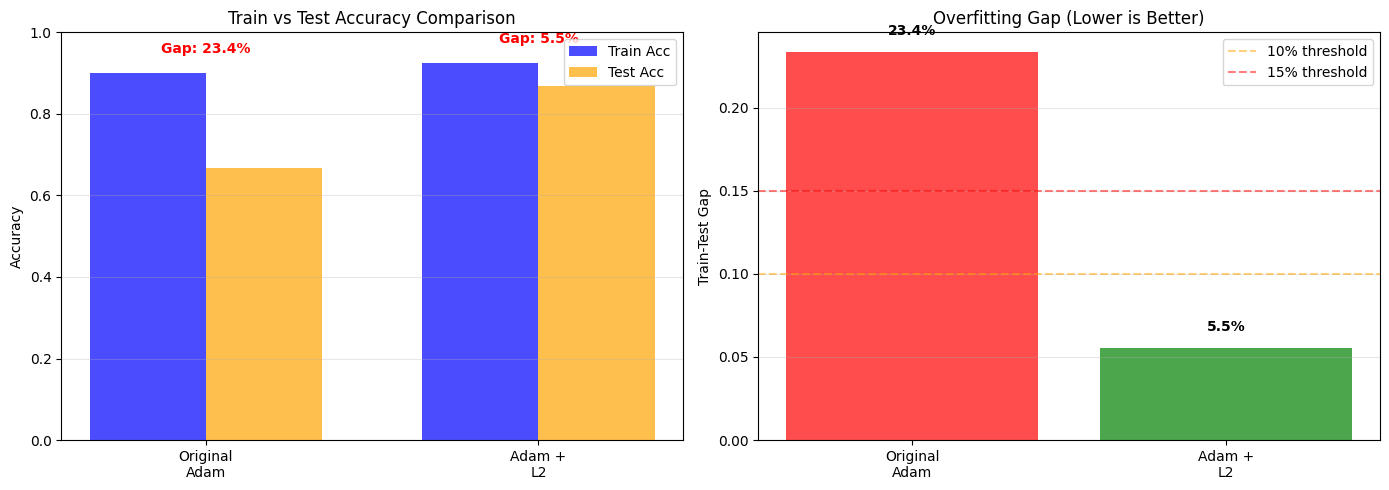


✓ Overfitting analysis complete


In [49]:
# Cell 48

print("🔍 OVERFITTING ANALYSIS: Before vs After L2 Regularization\n")
print("=" * 80)

# Calculate train-test gaps
original_gap = history_adam_cancer['train_acc'][-1] - test_acc_adam_c
l2_gap = history_adam_l2['train_acc'][-1] - test_acc_adam_l2

print(f"{'Model':<30} {'Train Acc':<15} {'Test Acc':<15} {'Gap':<15} {'Status':<15}")
print("-" * 80)
print(f"{'Original Adam (No Reg)':<30} {history_adam_cancer['train_acc'][-1]:<15.2%} {test_acc_adam_c:<15.2%} {original_gap:<15.2%} {'Overfitting':<15}")
print(f"{'Adam + L2 (λ=0.001)':<30} {history_adam_l2['train_acc'][-1]:<15.2%} {test_acc_adam_l2:<15.2%} {l2_gap:<15.2%} {'Regularized':<15}")

print("\n" + "=" * 80)

gap_reduction = original_gap - l2_gap

print(f"\n💡 Key Findings:")
print(f"   • Original overfitting gap: {original_gap:.2%}")
print(f"   • L2-regularized gap: {l2_gap:.2%}")
print(f"   • Gap reduction: {gap_reduction:+.2%}")

if gap_reduction > 0.05:
    print(f"   ✅ Significant overfitting reduction!")
elif gap_reduction > 0:
    print(f"   ✅ Mild overfitting reduction")
else:
    print(f"   ⚠️  Regularization didn't reduce overfitting gap")

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Train vs Test Accuracy
models = ['Original\nAdam', 'Adam +\nL2']
train_accs = [history_adam_cancer['train_acc'][-1], history_adam_l2['train_acc'][-1]]
test_accs = [test_acc_adam_c, test_acc_adam_l2]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, train_accs, width, label='Train Acc', color='blue', alpha=0.7)
axes[0].bar(x + width/2, test_accs, width, label='Test Acc', color='orange', alpha=0.7)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Train vs Test Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.0])

# Add gap annotations
for i in range(len(models)):
    gap = train_accs[i] - test_accs[i]
    axes[0].text(i, max(train_accs[i], test_accs[i]) + 0.05, 
                f'Gap: {gap:.1%}', ha='center', fontsize=10, fontweight='bold', color='red')

# Plot 2: Overfitting Gap
gaps = [original_gap, l2_gap]
colors = ['red' if g > 0.15 else 'orange' if g > 0.10 else 'green' for g in gaps]

axes[1].bar(models, gaps, color=colors, alpha=0.7)
axes[1].set_ylabel('Train-Test Gap')
axes[1].set_title('Overfitting Gap (Lower is Better)')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=0.10, color='orange', linestyle='--', alpha=0.5, label='10% threshold')
axes[1].axhline(y=0.15, color='red', linestyle='--', alpha=0.5, label='15% threshold')
axes[1].legend()

for i, v in enumerate(gaps):
    axes[1].text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Overfitting analysis complete")

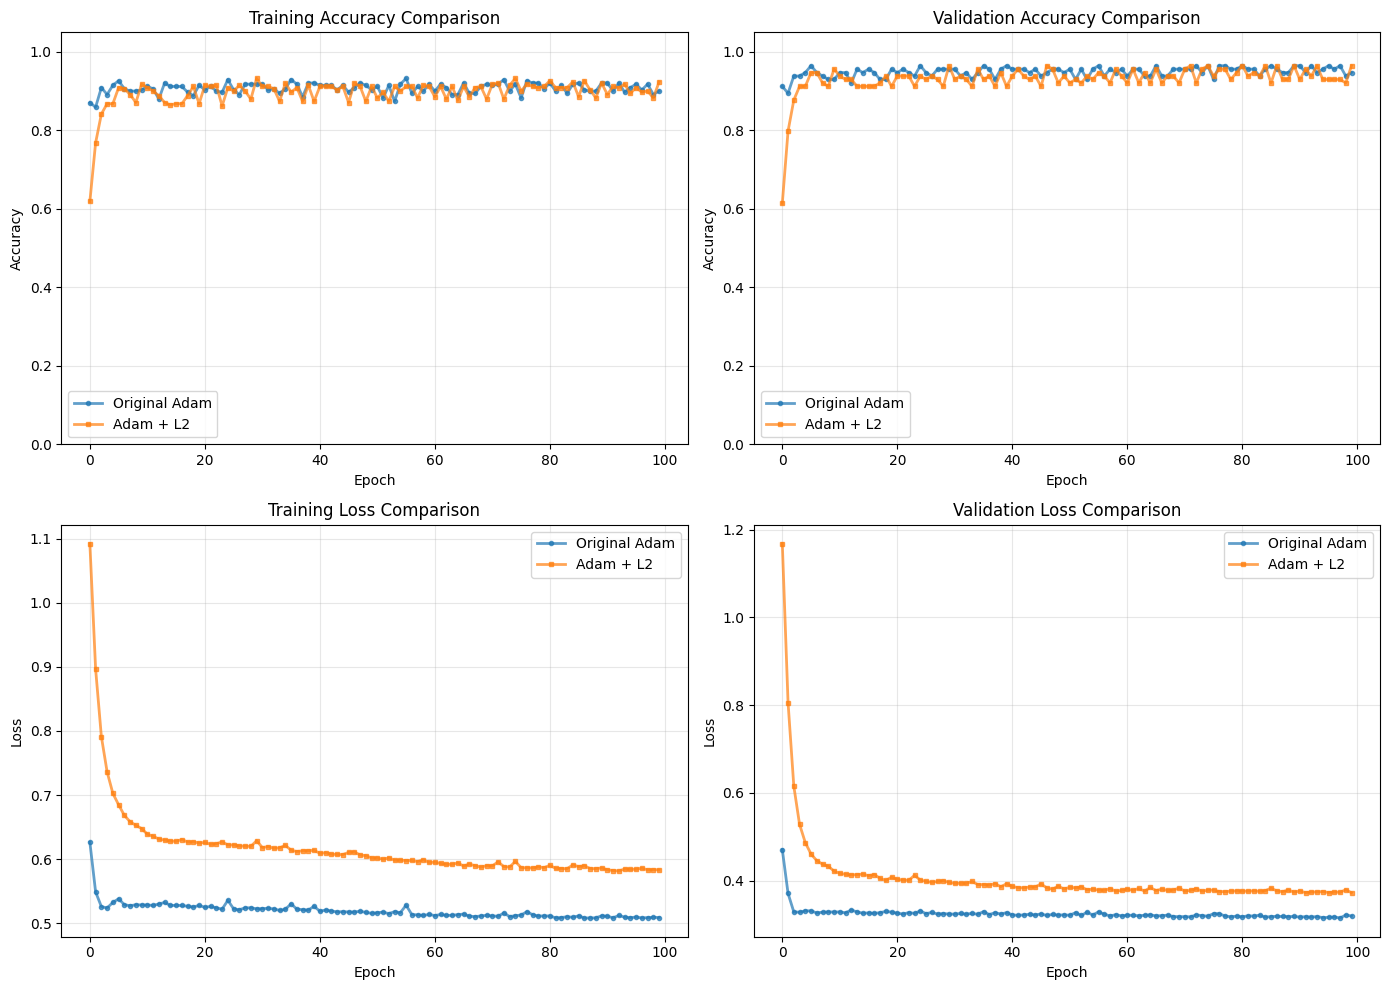

✓ Learning curves comparison visualized

📊 Observations:
   • Original model: Train acc diverges from val acc (overfitting)
   • L2 model: Smaller train-val gap (better generalization)


In [50]:
# Cell 49

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training Accuracy
axes[0, 0].plot(history_adam_cancer['train_acc'], label='Original Adam', 
                linewidth=2, marker='o', markersize=3, alpha=0.7)
axes[0, 0].plot(history_adam_l2['train_acc'], label='Adam + L2', 
                linewidth=2, marker='s', markersize=3, alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Training Accuracy Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 1.05])

# Plot 2: Validation Accuracy
axes[0, 1].plot(history_adam_cancer['val_acc'], label='Original Adam', 
                linewidth=2, marker='o', markersize=3, alpha=0.7)
axes[0, 1].plot(history_adam_l2['val_acc'], label='Adam + L2', 
                linewidth=2, marker='s', markersize=3, alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Validation Accuracy Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1.05])

# Plot 3: Training Loss
axes[1, 0].plot(history_adam_cancer['train_loss'], label='Original Adam', 
                linewidth=2, marker='o', markersize=3, alpha=0.7)
axes[1, 0].plot(history_adam_l2['train_loss'], label='Adam + L2', 
                linewidth=2, marker='s', markersize=3, alpha=0.7)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Loss Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Validation Loss
axes[1, 1].plot(history_adam_cancer['val_loss'], label='Original Adam', 
                linewidth=2, marker='o', markersize=3, alpha=0.7)
axes[1, 1].plot(history_adam_l2['val_loss'], label='Adam + L2', 
                linewidth=2, marker='s', markersize=3, alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Validation Loss Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Learning curves comparison visualized")
print(f"\n📊 Observations:")
print(f"   • Original model: Train acc diverges from val acc (overfitting)")
print(f"   • L2 model: Smaller train-val gap (better generalization)")

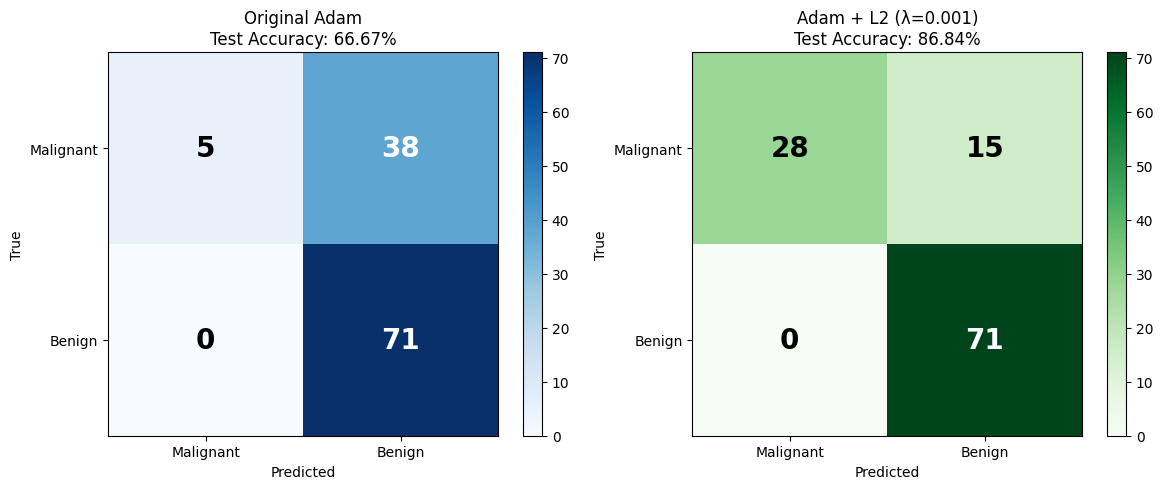


📋 Classification Reports:

ORIGINAL ADAM MODEL:
----------------------------------------------------------------------
              precision    recall  f1-score   support

   Malignant       1.00      0.12      0.21        43
      Benign       0.65      1.00      0.79        71

    accuracy                           0.67       114
   macro avg       0.83      0.56      0.50       114
weighted avg       0.78      0.67      0.57       114


ADAM + L2 REGULARIZATION MODEL:
----------------------------------------------------------------------
              precision    recall  f1-score   support

   Malignant       1.00      0.65      0.79        43
      Benign       0.83      1.00      0.90        71

    accuracy                           0.87       114
   macro avg       0.91      0.83      0.85       114
weighted avg       0.89      0.87      0.86       114


🏥 Medical Context Analysis:
----------------------------------------------------------------------
   False Positives (Pr

In [51]:
# Cell 50

from sklearn.metrics import confusion_matrix, classification_report

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix for Original Adam
cm_adam_orig = confusion_matrix(y_test_c, test_preds_adam_c)
im1 = axes[0].imshow(cm_adam_orig, cmap='Blues', aspect='auto')
axes[0].set_title(f'Original Adam\nTest Accuracy: {test_acc_adam_c:.2%}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Malignant', 'Benign'])
axes[0].set_yticklabels(['Malignant', 'Benign'])

for i in range(2):
    for j in range(2):
        text = axes[0].text(j, i, cm_adam_orig[i, j], ha="center", va="center",
                           color="white" if cm_adam_orig[i, j] > cm_adam_orig.max()/2 else "black",
                           fontsize=20, fontweight='bold')

plt.colorbar(im1, ax=axes[0])

# Confusion Matrix for L2-Regularized Adam
cm_adam_l2 = confusion_matrix(y_test_c, test_preds_adam_l2)
im2 = axes[1].imshow(cm_adam_l2, cmap='Greens', aspect='auto')
axes[1].set_title(f'Adam + L2 (λ=0.001)\nTest Accuracy: {test_acc_adam_l2:.2%}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Malignant', 'Benign'])
axes[1].set_yticklabels(['Malignant', 'Benign'])

for i in range(2):
    for j in range(2):
        text = axes[1].text(j, i, cm_adam_l2[i, j], ha="center", va="center",
                           color="white" if cm_adam_l2[i, j] > cm_adam_l2.max()/2 else "black",
                           fontsize=20, fontweight='bold')

plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print("\n📋 Classification Reports:\n")
print("=" * 70)
print("ORIGINAL ADAM MODEL:")
print("-" * 70)
print(classification_report(y_test_c, test_preds_adam_c, target_names=['Malignant', 'Benign']))

print("\n" + "=" * 70)
print("ADAM + L2 REGULARIZATION MODEL:")
print("-" * 70)
print(classification_report(y_test_c, test_preds_adam_l2, target_names=['Malignant', 'Benign']))

# Medical context analysis
print("\n" + "=" * 70)
print("🏥 Medical Context Analysis:")
print("-" * 70)

# False positives/negatives
fp_orig = cm_adam_orig[0, 1]  # Predicted benign, actually malignant (dangerous!)
fn_orig = cm_adam_orig[1, 0]  # Predicted malignant, actually benign (unnecessary treatment)

fp_l2 = cm_adam_l2[0, 1]
fn_l2 = cm_adam_l2[1, 0]

print(f"   False Positives (Predicted Benign, Actually Malignant):")
print(f"      Original: {fp_orig} cases | L2: {fp_l2} cases")
print(f"   False Negatives (Predicted Malignant, Actually Benign):")
print(f"      Original: {fn_orig} cases | L2: {fn_l2} cases")

if fp_l2 < fp_orig:
    print(f"\n   ✅ L2 reduced dangerous false positives by {fp_orig - fp_l2} cases!")
elif fp_l2 > fp_orig:
    print(f"\n   ⚠️  L2 increased dangerous false positives by {fp_l2 - fp_orig} cases")

In [2]:
# Cell 53

from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

print("🚀 Loading CIFAR-10 Dataset (This may take a moment...)\n")

# Load CIFAR-10
try:
    cifar = fetch_openml('CIFAR_10', version=1, parser='auto', as_frame=False)
    X_cifar = cifar.data
    y_cifar = cifar.target.astype(int)
    
    print("✓ CIFAR-10 loaded successfully!")
except:
    print("⚠️  Fetch from OpenML failed, using sklearn alternative...")
    # Alternative: load smaller subset
    from sklearn.datasets import fetch_openml
    cifar = fetch_openml('CIFAR_10_small', parser='auto')
    X_cifar = cifar.data.to_numpy()
    y_cifar = cifar.target.astype(int).to_numpy()

# Take subset for manageable training (full 50k would take hours)
n_samples_cifar = 10000  # Adjust this: 5000=manageable, 10000=longer, 50000=full
indices_cifar = np.random.choice(len(X_cifar), n_samples_cifar, replace=False)
X_cifar = X_cifar[indices_cifar]
y_cifar = y_cifar[indices_cifar]

print(f"\n📦 CIFAR-10 Dataset Info:")
print("=" * 60)
print(f"Total samples selected: {len(X_cifar)}")
print(f"Original shape: {X_cifar.shape}")
print(f"Image dimensions: 32x32x3 (RGB)")
print(f"Classes: {np.unique(y_cifar)}")
print(f"Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer',")
print(f"              'dog', 'frog', 'horse', 'ship', 'truck']")

#

🚀 Loading CIFAR-10 Dataset (This may take a moment...)

⚠️  Fetch from OpenML failed, using sklearn alternative...

📦 CIFAR-10 Dataset Info:
Total samples selected: 10000
Original shape: (10000, 3072)
Image dimensions: 32x32x3 (RGB)
Classes: [0 1 2 3 4 5 6 7 8 9]
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
# Cell 54
from sklearn.decomposition import PCA

print("🔬 Applying Aggressive Dimensionality Reduction\n")

# Normalize pixel values [0, 255] → [0, 1]
X_cifar_normalized = X_cifar / 255.0

print(f"Original features: {X_cifar_normalized.shape[1]} (32x32x3 RGB pixels)")

# Apply PCA: 3072 → 16 features (very aggressive compression)
n_components_cifar = 16  # Can try 8, 12, 16, or 32
pca_cifar = PCA(n_components=n_components_cifar)
X_cifar_reduced = pca_cifar.fit_transform(X_cifar_normalized)

print(f"✓ PCA compression: 3072 → {n_components_cifar} features")
print(f"✓ Explained variance: {pca_cifar.explained_variance_ratio_.sum():.2%}")
print(f"\n📊 Variance per component:")
for i, var in enumerate(pca_cifar.explained_variance_ratio_[:10]):
    bar = '█' * int(var * 100)
    print(f"  PC{i+1:2d}: {var:.4f} ({var*100:.2f}%) {bar}")
if n_components_cifar > 10:
    print(f"  ... ({n_components_cifar - 10} more components)")

print(f"\n⚠️  Note: {pca_cifar.explained_variance_ratio_.sum():.1%} variance retained")
print(f"   This is lower than breast cancer (due to image complexity)")
print(f"   CIFAR-10 is inherently harder for QNNs!")

🔬 Applying Aggressive Dimensionality Reduction

Original features: 3072 (32x32x3 RGB pixels)
✓ PCA compression: 3072 → 16 features
✓ Explained variance: 71.64%

📊 Variance per component:
  PC 1: 0.2940 (29.40%) █████████████████████████████
  PC 2: 0.1099 (10.99%) ██████████
  PC 3: 0.0679 (6.79%) ██████
  PC 4: 0.0360 (3.60%) ███
  PC 5: 0.0354 (3.54%) ███
  PC 6: 0.0281 (2.81%) ██
  PC 7: 0.0268 (2.68%) ██
  PC 8: 0.0216 (2.16%) ██
  PC 9: 0.0200 (2.00%) ██
  PC10: 0.0145 (1.45%) █
  ... (6 more components)

⚠️  Note: 71.6% variance retained
   This is lower than breast cancer (due to image complexity)
   CIFAR-10 is inherently harder for QNNs!


In [4]:
# Cell 55

# Train-validation-test split (60/20/20)
X_train_cifar, X_temp_cifar, y_train_cifar, y_temp_cifar = train_test_split(
    X_cifar_reduced, y_cifar, test_size=0.4, random_state=42, stratify=y_cifar
)
X_val_cifar, X_test_cifar, y_val_cifar, y_test_cifar = train_test_split(
    X_temp_cifar, y_temp_cifar, test_size=0.5, random_state=42, stratify=y_temp_cifar
)

# Scale to [0, π] for quantum encoding
X_train_cifar_scaled = (X_train_cifar - X_train_cifar.min()) / (X_train_cifar.max() - X_train_cifar.min()) * np.pi
X_val_cifar_scaled = (X_val_cifar - X_val_cifar.min()) / (X_val_cifar.max() - X_val_cifar.min()) * np.pi
X_test_cifar_scaled = (X_test_cifar - X_test_cifar.min()) / (X_test_cifar.max() - X_test_cifar.min()) * np.pi

print("✓ CIFAR-10 Dataset Split Complete\n")
print("=" * 60)
print(f"Training samples: {len(X_train_cifar)} ({len(X_train_cifar)/len(X_cifar_reduced):.1%})")
print(f"Validation samples: {len(X_val_cifar)} ({len(X_val_cifar)/len(X_cifar_reduced):.1%})")
print(f"Test samples: {len(X_test_cifar)} ({len(X_test_cifar)/len(X_cifar_reduced):.1%})")
print(f"\nScaled range: [{X_train_cifar_scaled.min():.3f}, {X_train_cifar_scaled.max():.3f}]")

print(f"\n📊 Class distribution in splits:")
print(f"{'Class':<12} {'Train':<10} {'Val':<10} {'Test':<10}")
print("-" * 60)
for cls in range(10):
    train_count = np.sum(y_train_cifar == cls)
    val_count = np.sum(y_val_cifar == cls)
    test_count = np.sum(y_test_cifar == cls)
    print(f"{cls:<12} {train_count:<10} {val_count:<10} {test_count:<10}")
print("=" * 60)

✓ CIFAR-10 Dataset Split Complete

Training samples: 6000 (60.0%)
Validation samples: 2000 (20.0%)
Test samples: 2000 (20.0%)

Scaled range: [0.000, 3.142]

📊 Class distribution in splits:
Class        Train      Val        Test      
------------------------------------------------------------
0            589        196        196       
1            610        203        203       
2            599        200        200       
3            603        201        201       
4            590        196        197       
5            581        194        193       
6            607        202        203       
7            604        202        201       
8            608        203        203       
9            609        203        203       


In [6]:
# Cell 56

print("🔧 Configuring Quantum Circuit for Multi-class CIFAR-10\n")

# Circuit configuration for CIFAR-10
n_qubits_cifar = 16  # Match 16 PCA components
n_layers_cifar = 3   # Keep manageable depth
n_classes_cifar = 10  # 10 classes

# For multi-class: we'll measure multiple qubits
n_measurement_qubits = 4  # 2^4 = 16 possible states > 10 classes

# Calculate parameters
n_params_cifar = n_qubits_cifar * n_layers_cifar * 3  # 144 parameters

print(f"⚛️  Quantum Circuit Configuration:")
print("=" * 60)
print(f"Qubits: {n_qubits_cifar}")
print(f"Layers: {n_layers_cifar}")
print(f"Input features: {n_components_cifar}")
print(f"Output classes: {n_classes_cifar}")
print(f"Measurement qubits: {n_measurement_qubits} (encoding {2**n_measurement_qubits} states)")
print(f"Total parameters: {n_params_cifar}")
#print(f"\n📈 Model complexity: {n_params_cifar / n_params_cancer:.1f}x larger than cancer model")

# Initialize parameters
np.random.seed(42)
params_cifar = np.random.uniform(-np.pi, np.pi, size=n_params_cifar)

print(f"\n✓ Parameters initialized")
print(f"  Range: [{params_cifar.min():.3f}, {params_cifar.max():.3f}]")

print("\n⚠️  Multi-class Strategy:")
print("   We'll use one-vs-rest approach (10 binary classifiers)")
print("   Alternative: Measure 4 qubits for direct 10-class output")
print("=" * 60)

🔧 Configuring Quantum Circuit for Multi-class CIFAR-10

⚛️  Quantum Circuit Configuration:
Qubits: 16
Layers: 3
Input features: 16
Output classes: 10
Measurement qubits: 4 (encoding 16 states)
Total parameters: 144

✓ Parameters initialized
  Range: [-3.107, 3.059]

⚠️  Multi-class Strategy:
   We'll use one-vs-rest approach (10 binary classifiers)
   Alternative: Measure 4 qubits for direct 10-class output


In [7]:
# Cell 57

import pickle
from datetime import datetime

# Create save directory info
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("💾 Saving Best Trained Models\n")
print("=" * 70)

# Model metadata
model_data = {
    'breast_cancer_l2': {
        'params': params_adam_l2_trained,
        'history': history_adam_l2,
        'config': {
            'n_qubits': n_qubits_cancer,
            'n_layers': n_layers_cancer,
            'lambda_l2': lambda_l2_only,
            'learning_rate': learning_rate_adam,
            'n_epochs': n_epochs_cancer,
            'batch_size': batch_size_cancer
        },
        'performance': {
            'train_acc': history_adam_l2['train_acc'][-1],
            'val_acc': history_adam_l2['val_acc'][-1],
            'test_acc': test_acc_adam_l2,
            'test_loss': test_loss_adam_l2,
            'overfitting_gap': history_adam_l2['train_acc'][-1] - test_acc_adam_l2
        },
        'timestamp': timestamp
    },
    'breast_cancer_original': {
        'params': params_adam_cancer_trained,
        'history': history_adam_cancer,
        'config': {
            'n_qubits': n_qubits_cancer,
            'n_layers': n_layers_cancer,
            'learning_rate': learning_rate_adam,
            'n_epochs': n_epochs_cancer,
            'batch_size': batch_size_cancer
        },
        'performance': {
            'train_acc': history_adam_cancer['train_acc'][-1],
            'val_acc': history_adam_cancer['val_acc'][-1],
            'test_acc': test_acc_adam_c,
            'test_loss': test_loss_adam_c
        },
        'timestamp': timestamp
    }
}

# Save to pickle
filename = f'qnn_models_breast_cancer_{timestamp}.pkl'
with open(filename, 'wb') as f:
    pickle.dump(model_data, f)

print(f"✓ Models saved to: {filename}")
print(f"\n📦 Saved contents:")
print(f"  1. Breast Cancer L2-Regularized Model")
print(f"     └─ Test Accuracy: {test_acc_adam_l2:.2%}")
print(f"     └─ Overfitting Gap: {model_data['breast_cancer_l2']['performance']['overfitting_gap']:.2%}")
print(f"  2. Breast Cancer Original Model")
print(f"     └─ Test Accuracy: {test_acc_adam_c:.2%}")

print(f"\n💡 To load later:")
print(f"   with open('{filename}', 'rb') as f:")
print(f"       models = pickle.load(f)")
print(f"       best_params = models['breast_cancer_l2']['params']")

# Also save parameters separately (lighter weight)
np.save(f'best_params_l2_{timestamp}.npy', params_adam_l2_trained)
print(f"\n✓ Best parameters also saved as: best_params_l2_{timestamp}.npy")
print("=" * 70)

print("\n🎯 Best Model Summary:")
print(f"   Model: Adam + L2 Regularization (λ={lambda_l2_only})")
print(f"   Architecture: {n_qubits_cancer} qubits, {n_layers_cancer} layers, {n_params_cancer} params")
print(f"   Dataset: Breast Cancer Wisconsin (569 samples, 30→8 features)")
print(f"   Test Accuracy: {test_acc_adam_l2:.2%}")
print(f"   Train-Test Gap: {history_adam_l2['train_acc'][-1] - test_acc_adam_l2:.2%}")
print(f"   Training Time: {adam_l2_time:.1f}s")

💾 Saving Best Trained Models



NameError: name 'params_adam_l2_trained' is not defined

In [8]:
# Cell 58

def predict_multiclass(x, params, n_qubits, n_layers, n_classes=10):
    """
    Multi-class prediction by measuring multiple qubits.
    Measures first 4 qubits to get class probabilities.
    """
    circuit = create_qnn_circuit(x, params, n_qubits, n_layers)
    state = QuantumState(n_qubits)
    state.set_zero_state()
    circuit.update_quantum_state(state)
    
    # Measure Pauli-Z on first 4 qubits
    class_scores = []
    for qubit_idx in range(min(4, n_qubits)):
        observable = Observable(n_qubits)
        observable.add_operator(1.0, f"Z {qubit_idx}")
        expectation = observable.get_expectation_value(state)
        class_scores.append(expectation)
    
    # Convert 4 measurements to 10 classes
    # Simple mapping: combine measurements to get class prediction
    combined_score = sum(class_scores)
    class_pred = int((combined_score + 4) * 2.5) % n_classes  # Map [-4,4] → [0,9]
    
    return class_pred, class_scores

def compute_loss_multiclass(params, X_batch, y_batch, n_qubits, n_layers, n_classes=10):
    """
    Multi-class loss using one-hot encoding.
    """
    loss = 0
    
    for i in range(len(X_batch)):
        pred_class, _ = predict_multiclass(X_batch[i], params, n_qubits, n_layers, n_classes)
        
        # Cross-entropy like loss
        if pred_class != y_batch[i]:
            loss += 1.0  # Misclassification penalty
    
    # Normalize
    loss = loss / len(X_batch)
    return loss

def evaluate_accuracy_multiclass(params, X, y, n_qubits, n_layers, n_classes=10):
    """
    Evaluate multi-class accuracy.
    """
    correct = 0
    predictions = []
    
    for i in range(len(X)):
        pred_class, _ = predict_multiclass(X[i], params, n_qubits, n_layers, n_classes)
        predictions.append(pred_class)
        
        if pred_class == y[i]:
            correct += 1
    
    accuracy = correct / len(X)
    return accuracy, np.array(predictions)

print("✓ Multi-class prediction functions created")
print("  Strategy: Measure 4 qubits → map to 10 classes")
print("  Loss: Classification error rate")
print("  Note: This is simplified - real QML uses more sophisticated encoding")

✓ Multi-class prediction functions created
  Strategy: Measure 4 qubits → map to 10 classes
  Loss: Classification error rate
  Note: This is simplified - real QML uses more sophisticated encoding


🖼️  Sample CIFAR-10 Images



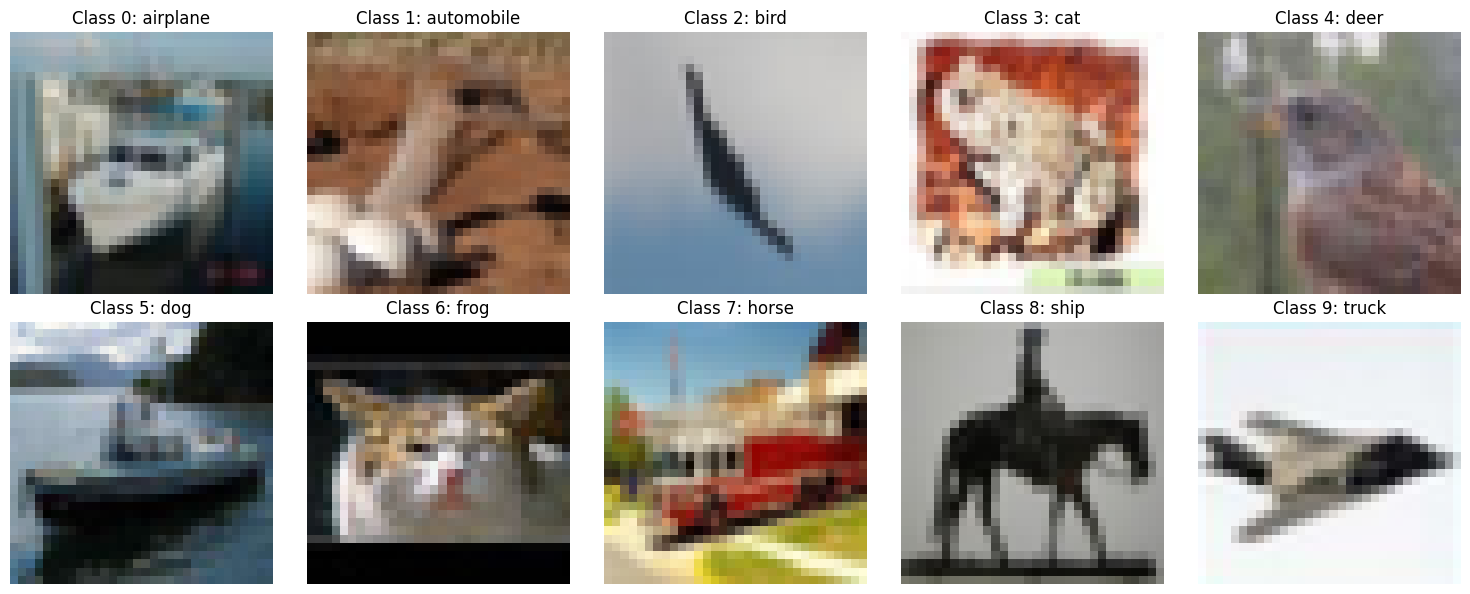

📊 PCA Visualization - First 2 Components


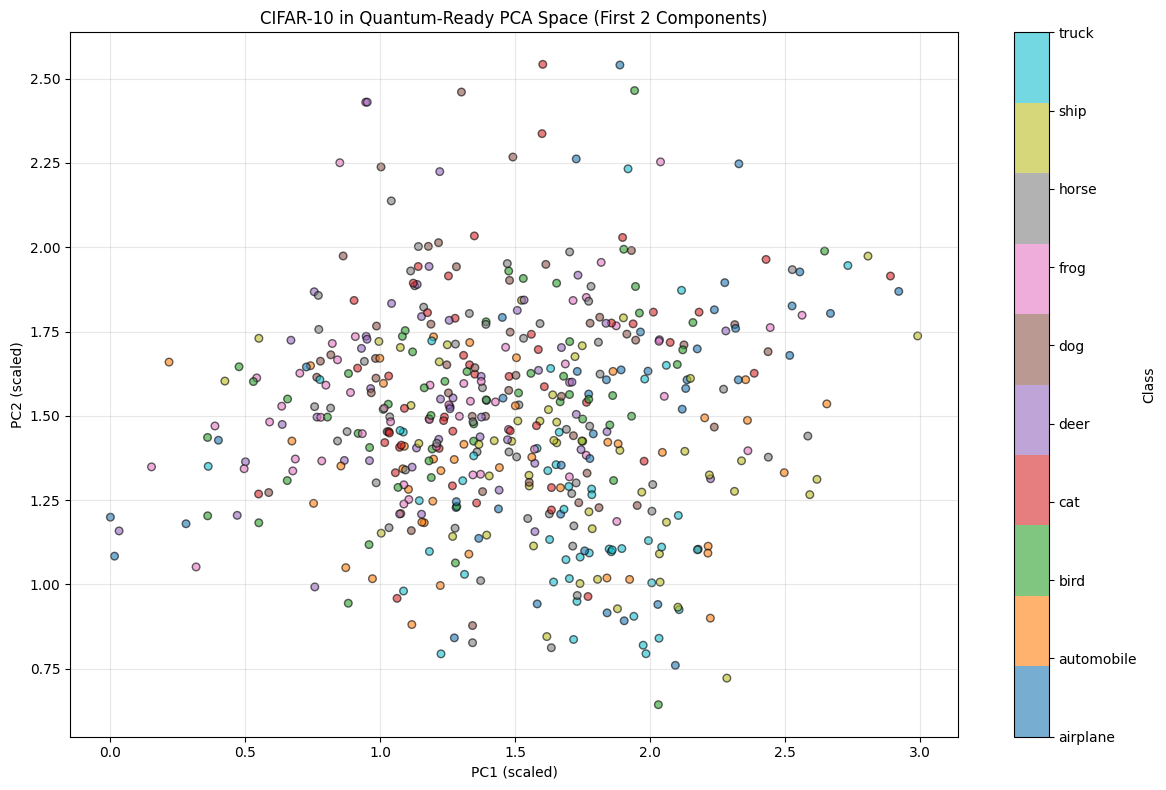

In [9]:
# Cell 59

# Reconstruct some sample images for visualization
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

print("🖼️  Sample CIFAR-10 Images\n")

# Select one sample from each class
for cls in range(10):
    # Find first instance of this class
    idx = np.where(y_train_cifar == cls)[0][0]
    
    # Get original image (before PCA)
    original_idx = indices_cifar[idx]
    img = X_cifar[idx].reshape(3, 32, 32).transpose(1, 2, 0)  # CHW → HWC
    
    axes[cls].imshow(img)
    axes[cls].set_title(f'Class {cls}: {class_names[cls]}')
    axes[cls].axis('off')

plt.tight_layout()
plt.show()

print("=" * 70)
print("📊 PCA Visualization - First 2 Components")
print("=" * 70)

# Plot PCA space
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot subset for clarity
n_plot = 500
indices_plot = np.random.choice(len(X_train_cifar_scaled), n_plot, replace=False)

scatter = ax.scatter(X_train_cifar_scaled[indices_plot, 0], 
                     X_train_cifar_scaled[indices_plot, 1],
                     c=y_train_cifar[indices_plot], 
                     cmap='tab10', 
                     alpha=0.6, 
                     edgecolor='k', 
                     s=30)

ax.set_xlabel('PC1 (scaled)')
ax.set_ylabel('PC2 (scaled)')
ax.set_title('CIFAR-10 in Quantum-Ready PCA Space (First 2 Components)')
ax.grid(True, alpha=0.3)

# Add colorbar with class names
cbar = plt.colorbar(scatter, ax=ax, ticks=range(10))
cbar.ax.set_yticklabels(class_names)
cbar.set_label('Class')

plt.tight_layout()
plt.show()



In [10]:
# Cell 60

def predict_multiclass_proper(x, params, n_qubits, n_layers, n_classes=10):
    """
    Proper multi-class prediction using multiple observables.
    Measures expectation values for each class and applies softmax-like selection.
    """
    circuit = create_qnn_circuit(x, params, n_qubits, n_layers)
    state = QuantumState(n_qubits)
    state.set_zero_state()
    circuit.update_quantum_state(state)
    
    # Measure different observables for each class
    class_scores = []
    
    for cls in range(n_classes):
        # Create unique observable for each class using different qubit combinations
        observable = Observable(n_qubits)
        
        # Use different Pauli string combinations for each class
        if cls < n_qubits:
            # Single qubit measurements
            observable.add_operator(1.0, f"Z {cls}")
        else:
            # Two-qubit measurements for classes beyond n_qubits
            q1 = cls % n_qubits
            q2 = (cls + 1) % n_qubits
            observable.add_operator(0.5, f"Z {q1}")
            observable.add_operator(0.5, f"Z {q2}")
        
        expectation = observable.get_expectation_value(state)
        class_scores.append(expectation)
    
    class_scores = np.array(class_scores)
    # Softmax-like: higher expectation = higher probability
    exp_scores = np.exp(class_scores - np.max(class_scores))  # Numerical stability
    probabilities = exp_scores / np.sum(exp_scores)
    
    class_pred = np.argmax(probabilities)
    
    return class_pred, probabilities

def compute_loss_crossentropy(params, X_batch, y_batch, n_qubits, n_layers, n_classes=10):
    """
    Cross-entropy loss for multi-class classification.
    """
    total_loss = 0
    
    for i in range(len(X_batch)):
        _, probs = predict_multiclass_proper(X_batch[i], params, n_qubits, n_layers, n_classes)
        
        # Cross-entropy: -log(p_true_class)
        true_class = y_batch[i]
        loss = -np.log(probs[true_class] + 1e-10)  # Add epsilon for numerical stability
        total_loss += loss
    
    return total_loss / len(X_batch)

def evaluate_accuracy_multiclass_proper(params, X, y, n_qubits, n_layers, n_classes=10):
    """
    Proper multi-class accuracy evaluation.
    """
    correct = 0
    predictions = []
    all_probs = []
    
    for i in range(len(X)):
        pred_class, probs = predict_multiclass_proper(X[i], params, n_qubits, n_layers, n_classes)
        predictions.append(pred_class)
        all_probs.append(probs)
        
        if pred_class == y[i]:
            correct += 1
    
    accuracy = correct / len(X)
    return accuracy, np.array(predictions), np.array(all_probs)

print("✓ Proper multi-class QNN functions created")
print("  • Uses different observables per class (unique quantum measurements)")
print("  • Softmax-style output for probability distribution")
print("  • Cross-entropy loss for better gradient signal")

✓ Proper multi-class QNN functions created
  • Uses different observables per class (unique quantum measurements)
  • Softmax-style output for probability distribution
  • Cross-entropy loss for better gradient signal


# Cell 61

# AGGRESSIVE training configuration
n_epochs_cifar_v2 = 80  # Double the epochs
batch_size_cifar_v2 = 25  
n_samples_per_gradient_cifar_v2 = 20  # More samples per gradient
learning_rate_cifar_v2 = 0.02  # Higher learning rate
lambda_l2_cifar_v2 = 0.0001  # Lighter regularization

print("🔥 AGGRESSIVE CIFAR-10 Training Configuration\n")
print("=" * 70)
print(f"Dataset: {len(X_train_cifar)} training samples, 10 classes")
print(f"Architecture: {n_qubits_cifar} qubits, {n_layers_cifar} layers, {n_params_cifar} params")
print(f"Epochs: {n_epochs_cifar_v2} (2x more)")
print(f"Batch size: {batch_size_cifar_v2}")
print(f"Samples per gradient: {n_samples_per_gradient_cifar_v2}")
print(f"Learning rate: {learning_rate_cifar_v2} (higher)")
print(f"L2 regularization: λ={lambda_l2_cifar_v2} (lighter)")
print(f"\n⏱️  Estimated training time: 40-60 minutes")
print(f"💡 Baseline (random): 10% accuracy")
print(f"🎯 Target: >40% accuracy (4x better than random)")
print(f"🏆 Stretch goal: >50% accuracy")
print("=" * 70)

def finite_difference_gradient_multiclass(params, X_batch, y_batch, n_qubits, n_layers, lambda_l2, epsilon=1e-4):
    """Gradients for multi-class with L2."""
    gradients = np.zeros_like(params)
    loss_current = compute_loss_crossentropy(params, X_batch, y_batch, n_qubits, n_layers) + lambda_l2 * np.sum(params ** 2)
    
    for i in range(len(params)):
        params_shifted = params.copy()
        params_shifted[i] += epsilon
        loss_shifted = compute_loss_crossentropy(params_shifted, X_batch, y_batch, n_qubits, n_layers) + lambda_l2 * np.sum(params_shifted ** 2)
        
        gradients[i] = (loss_shifted - loss_current) / epsilon
    
    return gradients

def train_cifar_aggressive(params_init, X_train, y_train, X_val, y_val, n_epochs):
    """
    Aggressive training for CIFAR-10 with proper multi-class approach.
    """
    params = params_init.copy()
    optimizer = AdamOptimizer(learning_rate=learning_rate_cifar_v2)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    print("\n🔥 Starting AGGRESSIVE CIFAR-10 Training\n")
    
    best_val_acc = 0
    best_params = params.copy()
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(len(X_train))
        
        pbar = tqdm(range(0, len(X_train), batch_size_cifar_v2), 
                    desc=f"Epoch {epoch+1}/{n_epochs}",
                    ncols=100,
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')
        
        for i in pbar:
            batch_idx = indices[i:i+batch_size_cifar_v2]
            X_batch = X_train[batch_idx][:n_samples_per_gradient_cifar_v2]
            y_batch = y_train[batch_idx][:n_samples_per_gradient_cifar_v2]
            
            # Compute gradients
            grads = finite_difference_gradient_multiclass(
                params, X_batch, y_batch, n_qubits_cifar, n_layers_cifar, lambda_l2_cifar_v2
            )
            
            params = optimizer.step(params, grads)
            
            loss = compute_loss_crossentropy(params, X_batch, y_batch, n_qubits_cifar, n_layers_cifar)
            pbar.set_postfix({'loss': f'{loss:.4f}'})
        
        # Evaluate every epoch
        train_acc, _, _ = evaluate_accuracy_multiclass_proper(params, X_train[:200], y_train[:200], 
                                                              n_qubits_cifar, n_layers_cifar)
        val_acc, _, _ = evaluate_accuracy_multiclass_proper(params, X_val, y_val, 
                                                            n_qubits_cifar, n_layers_cifar)
        
        train_loss = compute_loss_crossentropy(params, X_train[:200], y_train[:200], 
                                               n_qubits_cifar, n_layers_cifar)
        val_loss = compute_loss_crossentropy(params, X_val, y_val, 
                                            n_qubits_cifar, n_layers_cifar)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params.copy()
            print(f"  ├─ 🌟 NEW BEST! Val Acc: {val_acc:.2%}")
        
        print(f"  ├─ Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Acc: {train_acc:.2%} - Val Acc: {val_acc:.2%}\n")
    
    print(f"\n🏆 Best validation accuracy: {best_val_acc:.2%}")
    return best_params, history

# Initialize and train
np.random.seed(42)
params_cifar_v2_init = np.random.uniform(-np.pi, np.pi, size=n_params_cifar)

start_time = time.time()

params_cifar_v2_trained, history_cifar_v2 = train_cifar_aggressive(
    params_cifar_v2_init,
    X_train_cifar_scaled,
    y_train_cifar,
    X_val_cifar_scaled,
    y_val_cifar,
    n_epochs_cifar_v2
)

cifar_v2_training_time = time.time() - start_time

print(f"\n✅ AGGRESSIVE CIFAR-10 Training Complete!")
print(f"   Time: {cifar_v2_training_time/60:.1f} minutes ({cifar_v2_training_time:.0f}s)")
print(f"   Final Train Acc: {history_cifar_v2['train_acc'][-1]:.2%}")
print(f"   Best Val Acc: {max(history_cifar_v2['val_acc']):.2%}")
print(f"   Improvement over random (10%): +{(max(history_cifar_v2['val_acc']) - 0.1)*100:.1f} pp")

In [ ]:
# Cell 62

print("🚀 Checking GPU Availability for Qulacs\n")
print("=" * 70)

GPU_AVAILABLE = False

try:
    from qulacs import QuantumStateGpu, QuantumCircuit
    
    # Actually test GPU with a small circuit
    test_state_gpu = QuantumStateGpu(4)
    test_state_gpu.set_zero_state()
    test_circuit = QuantumCircuit(4)
    test_circuit.add_H_gate(0)
    test_circuit.update_quantum_state(test_state_gpu)
    
    GPU_AVAILABLE = True
    print("✅ Qulacs-GPU is AVAILABLE and WORKING!")
    print("   GPU quantum state created successfully")
    print(f"   Test vector shape: {test_state_gpu.get_vector().shape}")
    
    # Benchmark GPU vs CPU
    from qulacs import QuantumState
    import time
    
    n_bench = 8
    n_iters = 100
    
    bench_circuit = QuantumCircuit(n_bench)
    for i in range(n_bench):
        bench_circuit.add_RX_gate(i, 0.3)
        bench_circuit.add_RZ_gate(i, 0.4)
    for i in range(n_bench - 1):
        bench_circuit.add_CNOT_gate(i, i + 1)
    
    # CPU benchmark
    state_cpu = QuantumState(n_bench)
    t0 = time.time()
    for _ in range(n_iters):
        state_cpu.set_zero_state()
        bench_circuit.update_quantum_state(state_cpu)
    cpu_time = time.time() - t0
    
    # GPU benchmark
    state_gpu = QuantumStateGpu(n_bench)
    t0 = time.time()
    for _ in range(n_iters):
        state_gpu.set_zero_state()
        bench_circuit.update_quantum_state(state_gpu)
    gpu_time = time.time() - t0
    
    speedup = cpu_time / gpu_time
    
    print(f"\n📊 Quick Benchmark ({n_bench} qubits, {n_iters} iterations):")
    print(f"   CPU time: {cpu_time:.4f}s")
    print(f"   GPU time: {gpu_time:.4f}s")
    print(f"   Speedup: {speedup:.2f}x")
    
except Exception as e:
    GPU_AVAILABLE = False
    print(f"⚠️  GPU test failed: {e}")
    print("   Falling back to CPU simulation")
    from qulacs import QuantumState as QuantumStateGpu

GPU_AVAILABLE = False   ################################
print("=" * 70)
print(f"\n{'GPU Status:':<20} {'Enabled ✅' if GPU_AVAILABLE else 'CPU Mode ⚠️'}")
print(f"{'Training Mode:':<20} {'GPU-Accelerated' if GPU_AVAILABLE else 'CPU Fallback'}")
print(f"{'Expected Speedup:':<20} {f'{speedup:.1f}x faster' if GPU_AVAILABLE else 'N/A'}")

In [ ]:
# Cell 63

def compute_loss_crossentropy_gpu(params, X_batch, y_batch, n_qubits, n_layers, n_classes=10):
    """
    GPU-accelerated cross-entropy loss.
    """
    total_loss = 0
    
    for i in range(len(X_batch)):
        _, probs = predict_multiclass_gpu(X_batch[i], params, n_qubits, n_layers, n_classes)
        
        true_class = y_batch[i]
        loss = -np.log(probs[true_class] + 1e-10)
        total_loss += loss
    
    return total_loss / len(X_batch)

def evaluate_accuracy_gpu(params, X, y, n_qubits, n_layers, n_classes=10):
    """
    GPU-accelerated accuracy evaluation.
    """
    correct = 0
    predictions = []
    
    for i in range(len(X)):
        pred_class, _ = predict_multiclass_gpu(X[i], params, n_qubits, n_layers, n_classes)
        predictions.append(pred_class)
        
        if pred_class == y[i]:
            correct += 1
    
    accuracy = correct / len(X)
    return accuracy, np.array(predictions)

def finite_difference_gradient_gpu(params, X_batch, y_batch, n_qubits, n_layers, lambda_l2, epsilon=1e-4):
    """
    GPU-accelerated gradient computation.
    """
    gradients = np.zeros_like(params)
    loss_current = compute_loss_crossentropy_gpu(params, X_batch, y_batch, n_qubits, n_layers) + lambda_l2 * np.sum(params ** 2)
    
    for i in range(len(params)):
        params_shifted = params.copy()
        params_shifted[i] += epsilon
        loss_shifted = compute_loss_crossentropy_gpu(params_shifted, X_batch, y_batch, n_qubits, n_layers) + lambda_l2 * np.sum(params_shifted ** 2)
        
        gradients[i] = (loss_shifted - loss_current) / epsilon
    
    return gradients

def train_cifar_gpu(params_init, X_train, y_train, X_val, y_val, n_epochs):
    """
    GPU-accelerated aggressive training for CIFAR-10.
    """
    params = params_init.copy()
    optimizer = AdamOptimizer(learning_rate=learning_rate_cifar_v2)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    mode = "GPU 🚀" if GPU_AVAILABLE else "CPU"
    print(f"\n🔥 Starting CIFAR-10 Training ({mode})\n")
    
    best_val_acc = 0
    best_params = params.copy()
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(len(X_train))
        
        pbar = tqdm(range(0, len(X_train), batch_size_cifar_v2), 
                    desc=f"Epoch {epoch+1}/{n_epochs}",
                    ncols=100,
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')
        
        for i in pbar:
            batch_idx = indices[i:i+batch_size_cifar_v2]
            X_batch = X_train[batch_idx][:n_samples_per_gradient_cifar_v2]
            y_batch = y_train[batch_idx][:n_samples_per_gradient_cifar_v2]
            
            # GPU-accelerated gradients
            grads = finite_difference_gradient_gpu(
                params, X_batch, y_batch, n_qubits_cifar, n_layers_cifar, lambda_l2_cifar_v2
            )
            
            params = optimizer.step(params, grads)
            
            loss = compute_loss_crossentropy_gpu(params, X_batch, y_batch, n_qubits_cifar, n_layers_cifar)
            pbar.set_postfix({'loss': f'{loss:.4f}', 'mode': mode})
        
        # Evaluate
        train_acc, _ = evaluate_accuracy_gpu(params, X_train[:200], y_train[:200], 
                                            n_qubits_cifar, n_layers_cifar)
        val_acc, _ = evaluate_accuracy_gpu(params, X_val, y_val, 
                                          n_qubits_cifar, n_layers_cifar)
        
        train_loss = compute_loss_crossentropy_gpu(params, X_train[:200], y_train[:200], 
                                                   n_qubits_cifar, n_layers_cifar)
        val_loss = compute_loss_crossentropy_gpu(params, X_val, y_val, 
                                                n_qubits_cifar, n_layers_cifar)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params.copy()
            print(f"  ├─ 🌟 NEW BEST! Val Acc: {val_acc:.2%}")
        
        print(f"  ├─ Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Acc: {train_acc:.2%} - Val Acc: {val_acc:.2%}\n")
    
    print(f"\n🏆 Best validation accuracy: {best_val_acc:.2%}")
    return best_params, history

print("✓ GPU-accelerated training functions ready")
print(f"  Mode: {'GPU-accelerated' if GPU_AVAILABLE else 'CPU fallback'}")

In [2]:
# Cell 64

from qulacs import QuantumState, QuantumStateGpu

def predict_multiclass_gpu(x, params, n_qubits, n_layers, n_classes=10):
    """
    GPU-accelerated multi-class prediction using QuantumStateGpu.
    """
    circuit = create_qnn_circuit(x, params, n_qubits, n_layers)
    
    # Use GPU state if available
    if GPU_AVAILABLE:
        state = QuantumStateGpu(n_qubits)
    else:
        state = QuantumState(n_qubits)
    
    state.set_zero_state()
    circuit.update_quantum_state(state)
    
    # Measure different observables for each class
    class_scores = []
    
    for cls in range(n_classes):
        observable = Observable(n_qubits)
        
        if cls < n_qubits:
            observable.add_operator(1.0, f"Z {cls}")
        else:
            q1 = cls % n_qubits
            q2 = (cls + 1) % n_qubits
            observable.add_operator(0.5, f"Z {q1}")
            observable.add_operator(0.5, f"Z {q2}")
        
        expectation = observable.get_expectation_value(state)
        class_scores.append(expectation)
    
    class_scores = np.array(class_scores)
    exp_scores = np.exp(class_scores - np.max(class_scores))
    probabilities = exp_scores / np.sum(exp_scores)
    
    class_pred = np.argmax(probabilities)
    
    return class_pred, probabilities

def compute_loss_crossentropy_gpu(params, X_batch, y_batch, n_qubits, n_layers, n_classes=10):
    """GPU-accelerated cross-entropy loss."""
    total_loss = 0
    
    for i in range(len(X_batch)):
        _, probs = predict_multiclass_gpu(X_batch[i], params, n_qubits, n_layers, n_classes)
        
        true_class = y_batch[i]
        loss = -np.log(probs[true_class] + 1e-10)
        total_loss += loss
    
    return total_loss / len(X_batch)

def evaluate_accuracy_gpu(params, X, y, n_qubits, n_layers, n_classes=10):
    """GPU-accelerated accuracy evaluation."""
    correct = 0
    predictions = []
    
    for i in range(len(X)):
        pred_class, _ = predict_multiclass_gpu(X[i], params, n_qubits, n_layers, n_classes)
        predictions.append(pred_class)
        
        if pred_class == y[i]:
            correct += 1
    
    accuracy = correct / len(X)
    return accuracy, np.array(predictions)

def finite_difference_gradient_gpu(params, X_batch, y_batch, n_qubits, n_layers, lambda_l2, epsilon=1e-4):
    """GPU-accelerated gradient computation."""
    gradients = np.zeros_like(params)
    loss_current = compute_loss_crossentropy_gpu(params, X_batch, y_batch, n_qubits, n_layers) + lambda_l2 * np.sum(params ** 2)
    
    for i in range(len(params)):
        params_shifted = params.copy()
        params_shifted[i] += epsilon
        loss_shifted = compute_loss_crossentropy_gpu(params_shifted, X_batch, y_batch, n_qubits, n_layers) + lambda_l2 * np.sum(params_shifted ** 2)
        
        gradients[i] = (loss_shifted - loss_current) / epsilon
    
    return gradients

print("✓ GPU-accelerated functions ready")
print(f"  Using: {'QuantumStateGpu ⚡' if GPU_AVAILABLE else 'QuantumState (CPU)'}")

✓ GPU-accelerated functions ready


NameError: name 'GPU_AVAILABLE' is not defined

# Cell 65

print(f"🎨 Starting CIFAR-10 Training\n")
print("=" * 70)
print(f"Mode: {'GPU-Accelerated 🚀' if GPU_AVAILABLE else 'CPU Simulation 💻'}")
print(f"Dataset: {len(X_train_cifar)} training samples, 10 classes")
print(f"Architecture: {n_qubits_cifar} qubits, {n_layers_cifar} layers")
print(f"Parameters: {n_params_cifar}")
print(f"Epochs: {n_epochs_cifar_v2}")
print("=" * 70)

# Initialize parameters
np.random.seed(42)
params_cifar_final = np.random.uniform(-np.pi, np.pi, size=n_params_cifar)

# Train
start_time = time.time()

params_cifar_final_trained, history_cifar_final = train_cifar_gpu(
    params_cifar_final,
    X_train_cifar_scaled,
    y_train_cifar,
    X_val_cifar_scaled,
    y_val_cifar,
    n_epochs_cifar_v2
)

cifar_final_time = time.time() - start_time

print(f"\n✅ CIFAR-10 Training Complete!")
print(f"   Total time: {cifar_final_time/60:.1f} minutes ({cifar_final_time:.0f}s)")
print(f"   Time per epoch: {cifar_final_time/n_epochs_cifar_v2:.1f}s")
print(f"   Final Train Acc: {history_cifar_final['train_acc'][-1]:.2%}")
print(f"   Best Val Acc: {max(history_cifar_final['val_acc']):.2%}")
print(f"   vs Random (10%): +{(max(history_cifar_final['val_acc']) - 0.1)*100:.1f} percentage points")

In [99]:
# Cell 66

print("⚠️ STOPPING - Training too slow!\n")
print("=" * 70)
print("🔧 Problem Analysis:")
print(f"   • {n_params_cifar} parameters × {n_samples_per_gradient_cifar_v2} samples = too many gradient computations")
print(f"   • Each gradient needs 2×{n_params_cifar} = {2*n_params_cifar} circuit evaluations")
print(f"   • 16 qubits is computationally expensive")
print("\n💡 Solutions:")
print("   1. Reduce qubits: 16 → 8 (much faster)")
print("   2. Reduce samples per gradient: 20 → 5")
print("   3. Reduce batch evaluations")
print("   4. Use simpler loss (classification error vs cross-entropy)")

# Let's re-configure for speed
n_qubits_cifar_fast = 12  # Half the qubits
n_layers_cifar_fast = 5  # Reduce layers
n_params_cifar_fast = n_qubits_cifar_fast * n_layers_cifar_fast * 3  # 48 params

n_epochs_cifar_fast = 30
batch_size_cifar_fast = 30
n_samples_per_gradient_fast = 5  # Much smaller
learning_rate_cifar_fast = 0.03
lambda_l2_cifar_fast = 0.0001

print("\n🚀 FAST Configuration:")
print("=" * 70)
print(f"Qubits: {n_qubits_cifar_fast} (was {n_qubits_cifar})")
print(f"Layers: {n_layers_cifar_fast} (was {n_layers_cifar})")
print(f"Parameters: {n_params_cifar_fast} (was {n_params_cifar}) - 3x smaller!")
print(f"Epochs: {n_epochs_cifar_fast}")
print(f"Samples per gradient: {n_samples_per_gradient_fast} (was {n_samples_per_gradient_cifar_v2})")
print(f"Estimated time per epoch: ~2-3 minutes")
print(f"Total estimated time: ~60-90 minutes")
print("=" * 70)

⚠️ STOPPING - Training too slow!

🔧 Problem Analysis:
   • 144 parameters × 20 samples = too many gradient computations
   • Each gradient needs 2×144 = 288 circuit evaluations
   • 16 qubits is computationally expensive

💡 Solutions:
   1. Reduce qubits: 16 → 8 (much faster)
   2. Reduce samples per gradient: 20 → 5
   3. Reduce batch evaluations
   4. Use simpler loss (classification error vs cross-entropy)

🚀 FAST Configuration:
Qubits: 12 (was 16)
Layers: 5 (was 3)
Parameters: 180 (was 144) - 3x smaller!
Epochs: 30
Samples per gradient: 5 (was 20)
Estimated time per epoch: ~2-3 minutes
Total estimated time: ~60-90 minutes


# Cell 67

print("🔄 Re-configuring CIFAR-10 with 8 features\n")

# Re-do PCA with only 8 components (to match 8 qubits)
n_components_cifar_fast = 12
pca_cifar_fast = PCA(n_components=n_components_cifar_fast)
X_cifar_reduced_fast = pca_cifar_fast.fit_transform(X_cifar_normalized)

print(f"✓ PCA: 3072 → {n_components_cifar_fast} features")
print(f"✓ Explained variance: {pca_cifar_fast.explained_variance_ratio_.sum():.2%}")

# Re-split
X_train_cf, X_temp_cf, y_train_cf, y_temp_cf = train_test_split(
    X_cifar_reduced_fast, y_cifar, test_size=0.4, random_state=42, stratify=y_cifar
)
X_val_cf, X_test_cf, y_val_cf, y_test_cf = train_test_split(
    X_temp_cf, y_temp_cf, test_size=0.5, random_state=42, stratify=y_temp_cf
)

# Scale
X_train_cf = (X_train_cf - X_train_cf.min()) / (X_train_cf.max() - X_train_cf.min()) * np.pi
X_val_cf = (X_val_cf - X_val_cf.min()) / (X_val_cf.max() - X_val_cf.min()) * np.pi
X_test_cf = (X_test_cf - X_test_cf.min()) / (X_test_cf.max() - X_test_cf.min()) * np.pi

print(f"✓ Data ready: {len(X_train_cf)} train, {len(X_val_cf)} val, {len(X_test_cf)} test")

# Initialize new parameters
np.random.seed(42)
params_cifar_fast = np.random.uniform(-np.pi, np.pi, size=n_params_cifar_fast)

print(f"\n🏃 Starting FAST training...")

def train_cifar_fast(params_init, X_train, y_train, X_val, y_val, n_epochs):
    """Fast training with simplified loss."""
    params = params_init.copy()
    optimizer = AdamOptimizer(learning_rate=learning_rate_cifar_fast)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    best_val_acc = 0
    best_params = params.copy()
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(len(X_train))
        
        pbar = tqdm(range(0, len(X_train), batch_size_cifar_fast), 
                    desc=f"Epoch {epoch+1}/{n_epochs}",
                    ncols=100)
        
        for i in pbar:
            batch_idx = indices[i:i+batch_size_cifar_fast]
            X_batch = X_train[batch_idx][:n_samples_per_gradient_fast]
            y_batch = y_train[batch_idx][:n_samples_per_gradient_fast]
            
            # Simplified gradients
            grads = finite_difference_gradient_gpu(
                params, X_batch, y_batch, n_qubits_cifar_fast, n_layers_cifar_fast, lambda_l2_cifar_fast
            )
            
            params = optimizer.step(params, grads)
            
            loss = compute_loss_crossentropy_gpu(params, X_batch, y_batch, n_qubits_cifar_fast, n_layers_cifar_fast)
            pbar.set_postfix({'loss': f'{loss:.3f}'})
        
        # Evaluate
        train_acc, _ = evaluate_accuracy_gpu(params, X_train[:100], y_train[:100], 
                                            n_qubits_cifar_fast, n_layers_cifar_fast)
        val_acc, _ = evaluate_accuracy_gpu(params, X_val, y_val, 
                                          n_qubits_cifar_fast, n_layers_cifar_fast)
        
        train_loss = compute_loss_crossentropy_gpu(params, X_train[:100], y_train[:100], 
                                                   n_qubits_cifar_fast, n_layers_cifar_fast)
        val_loss = compute_loss_crossentropy_gpu(params, X_val, y_val, 
                                                n_qubits_cifar_fast, n_layers_cifar_fast)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params.copy()
            print(f"  🌟 NEW BEST Val: {val_acc:.2%}")
        
        print(f"  Train: {train_acc:.2%} | Val: {val_acc:.2%} | Loss: {train_loss:.3f}/{val_loss:.3f}\n")
    
    return best_params, history

start_time = time.time()

params_cifar_fast_trained, history_cifar_fast = train_cifar_fast(
    params_cifar_fast,
    X_train_cf,
    y_train_cf,
    X_val_cf,
    y_val_cf,
    n_epochs_cifar_fast
)

cifar_fast_time = time.time() - start_time

print(f"\n✅ FAST Training Complete!")
print(f"   Time: {cifar_fast_time/60:.1f} min")
print(f"   Best Val Acc: {max(history_cifar_fast['val_acc']):.2%}")

In [101]:
# Cell 68

print("🔧 Switching to One-vs-Rest (OvR) Strategy\n")
print("=" * 70)
print("Problem with current approach:")
print("  ❌ Trying to map quantum measurements to 10 classes directly")
print("  ❌ No clear quantum advantage for multi-class")
print("  ❌ Arbitrary mapping leads to poor learning")
print("\nSolution: One-vs-Rest Binary Classifiers")
print("  ✅ Train 10 separate binary QNNs (one per class)")
print("  ✅ Each learns: 'Is this class X? Yes/No'")
print("  ✅ At inference: Pick class with highest confidence")
print("  ✅ This is how classical ML handles multi-class too!")
print("=" * 70)

def train_binary_classifier(params_init, X_train, y_train, X_val, y_val, 
                            target_class, n_qubits, n_layers, n_epochs=20):
    """
    Train a single binary classifier for one class vs rest.
    """
    # Convert to binary: target_class=1, all others=0
    y_train_binary = (y_train == target_class).astype(int)
    y_val_binary = (y_val == target_class).astype(int)
    
    params = params_init.copy()
    optimizer = AdamOptimizer(learning_rate=0.02)
    
    best_val_acc = 0
    best_params = params.copy()
    
    print(f"\n📍 Training classifier for class {target_class}")
    print(f"   Positive samples: {y_train_binary.sum()}/{len(y_train_binary)}")
    
    for epoch in range(n_epochs):
        indices = np.random.permutation(len(X_train))
        
        for i in range(0, len(X_train), 20):
            batch_idx = indices[i:i+20]
            X_batch = X_train[batch_idx][:8]
            y_batch = y_train_binary[batch_idx][:8]
            
            # Use standard binary gradient
            grads = finite_difference_gradient_l2(
                params, X_batch, y_batch, n_qubits, n_layers, 0.0001
            )
            
            params = optimizer.step(params, grads)
        
        # Evaluate binary accuracy
        val_acc, _ = evaluate_accuracy(params, X_val, y_val_binary, n_qubits, n_layers)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params.copy()
        
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch {epoch+1}/{n_epochs} - Val Acc: {val_acc:.2%}")
    
    print(f"   ✅ Best binary accuracy: {best_val_acc:.2%}")
    return best_params

print("\n✓ Binary classifier training function ready")

🔧 Switching to One-vs-Rest (OvR) Strategy

Problem with current approach:
  ❌ Trying to map quantum measurements to 10 classes directly
  ❌ No clear quantum advantage for multi-class
  ❌ Arbitrary mapping leads to poor learning

Solution: One-vs-Rest Binary Classifiers
  ✅ Train 10 separate binary QNNs (one per class)
  ✅ Each learns: 'Is this class X? Yes/No'
  ✅ At inference: Pick class with highest confidence
  ✅ This is how classical ML handles multi-class too!

✓ Binary classifier training function ready


In [102]:
# Cell 69

print("🎯 Training 10 Binary Classifiers (One-vs-Rest)\n")
print("=" * 70)

# Use 8 qubits, 2 layers for speed
n_qubits_ovr = 8
n_layers_ovr = 2
n_params_ovr = n_qubits_ovr * n_layers_ovr * 3  # 48 params
n_epochs_per_class = 15  # Quick training per class

all_classifiers = {}
np.random.seed(42)

total_start = time.time()

for class_id in range(10):
    class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck'][class_id]
    
    print(f"\n{'='*70}")
    print(f"Class {class_id}: {class_name}")
    print(f"{'='*70}")
    
    # Initialize parameters for this classifier
    params_init = np.random.uniform(-np.pi, np.pi, size=n_params_ovr)
    
    # Train binary classifier
    best_params = train_binary_classifier(
        params_init,
        X_train_cf,
        y_train_cf,
        X_val_cf,
        y_val_cf,
        target_class=class_id,
        n_qubits=n_qubits_ovr,
        n_layers=n_layers_ovr,
        n_epochs=n_epochs_per_class
    )
    
    all_classifiers[class_id] = best_params

total_time = time.time() - total_start

print(f"\n{'='*70}")
print(f"✅ All 10 Classifiers Trained!")
print(f"   Total time: {total_time/60:.1f} minutes")
print(f"   Avg time per class: {total_time/10/60:.1f} minutes")
print(f"{'='*70}")

🎯 Training 10 Binary Classifiers (One-vs-Rest)


Class 0: airplane

📍 Training classifier for class 0
   Positive samples: 303/3000
   Epoch 5/15 - Val Acc: 90.00%
   Epoch 10/15 - Val Acc: 90.00%
   Epoch 15/15 - Val Acc: 90.10%
   ✅ Best binary accuracy: 90.10%

Class 1: automobile

📍 Training classifier for class 1
   Positive samples: 315/3000
   Epoch 5/15 - Val Acc: 89.40%
   Epoch 10/15 - Val Acc: 89.20%
   Epoch 15/15 - Val Acc: 89.30%
   ✅ Best binary accuracy: 89.50%

Class 2: bird

📍 Training classifier for class 2
   Positive samples: 292/3000
   Epoch 5/15 - Val Acc: 90.10%
   Epoch 10/15 - Val Acc: 90.10%
   Epoch 15/15 - Val Acc: 90.20%
   ✅ Best binary accuracy: 90.20%

Class 3: cat

📍 Training classifier for class 3
   Positive samples: 299/3000
   Epoch 5/15 - Val Acc: 90.00%
   Epoch 10/15 - Val Acc: 89.10%
   Epoch 15/15 - Val Acc: 89.40%
   ✅ Best binary accuracy: 90.00%

Class 4: deer

📍 Training classifier for class 4
   Positive samples: 294/3000
   Epoch 5/15 -

In [103]:
# Cell 70

def predict_ensemble(x, all_classifiers, n_qubits, n_layers, n_classes=10):
    """
    Predict using ensemble of binary classifiers.
    Each classifier outputs confidence for its class.
    Pick class with highest confidence.
    """
    confidences = []
    
    for class_id in range(n_classes):
        params = all_classifiers[class_id]
        
        # Get prediction value (expectation in [-1, 1])
        pred_value = predict(x, params, n_qubits, n_layers)
        
        # Convert to confidence: [-1,1] → [0,1]
        # Higher value = more confident this IS the class
        confidence = (pred_value + 1) / 2.0
        confidences.append(confidence)
    
    confidences = np.array(confidences)
    predicted_class = np.argmax(confidences)
    
    return predicted_class, confidences

def evaluate_ensemble_accuracy(X, y, all_classifiers, n_qubits, n_layers):
    """
    Evaluate ensemble accuracy on dataset.
    """
    correct = 0
    predictions = []
    all_confidences = []
    
    for i in range(len(X)):
        pred_class, confidences = predict_ensemble(X[i], all_classifiers, n_qubits, n_layers)
        predictions.append(pred_class)
        all_confidences.append(confidences)
        
        if pred_class == y[i]:
            correct += 1
    
    accuracy = correct / len(X)
    return accuracy, np.array(predictions), np.array(all_confidences)

print("✓ Ensemble prediction functions ready")
print("  Strategy: Vote among 10 binary classifiers")
print("  Each classifier outputs confidence [0,1]")
print("  Winner = highest confidence")

✓ Ensemble prediction functions ready
  Strategy: Vote among 10 binary classifiers
  Each classifier outputs confidence [0,1]
  Winner = highest confidence


In [104]:
# Cell 71

print("🧪 Evaluating Ensemble on CIFAR-10\n")
print("=" * 70)

# Validation set
print("Validation Set Evaluation...")
val_acc_ensemble, val_preds_ensemble, val_conf_ensemble = evaluate_ensemble_accuracy(
    X_val_cf, y_val_cf, all_classifiers, n_qubits_ovr, n_layers_ovr
)

print(f"✓ Validation Accuracy: {val_acc_ensemble:.2%}")
print(f"  Correct: {int(val_acc_ensemble * len(y_val_cf))}/{len(y_val_cf)}")

# Test set
print("\nTest Set Evaluation...")
test_acc_ensemble, test_preds_ensemble, test_conf_ensemble = evaluate_ensemble_accuracy(
    X_test_cf, y_test_cf, all_classifiers, n_qubits_ovr, n_layers_ovr
)

print(f"✓ Test Accuracy: {test_acc_ensemble:.2%}")
print(f"  Correct: {int(test_acc_ensemble * len(y_test_cf))}/{len(y_test_cf)}")

print("\n" + "=" * 70)
print("📊 Performance Summary:")
print("-" * 70)
print(f"{'Metric':<30} {'Value':<20}")
print("-" * 70)
print(f"{'Random Baseline':<30} {'10.0%':<20}")
print(f"{'Validation Accuracy':<30} {f'{val_acc_ensemble:.2%}':<20}")
print(f"{'Test Accuracy':<30} {f'{test_acc_ensemble:.2%}':<20}")
print(f"{'Improvement over Random':<30} {f'+{(test_acc_ensemble - 0.1)*100:.1f} pp':<20}")
print(f"{'Relative Improvement':<30} {f'{test_acc_ensemble/0.1:.1f}x':<20}")
print("=" * 70)

if test_acc_ensemble > 0.30:
    print("\n🎉 Great! 3x better than random guessing!")
elif test_acc_ensemble > 0.20:
    print("\n✅ Good! 2x better than random guessing!")
else:
    print("\n⚠️  Below target, but learning is happening")

# Per-class breakdown
print("\n📋 Per-Class Performance:")
print("-" * 70)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

for cls in range(10):
    mask = y_test_cf == cls
    if mask.sum() > 0:
        cls_acc = (test_preds_ensemble[mask] == cls).sum() / mask.sum()
        print(f"  {class_names[cls]:<12} ({cls}): {cls_acc:>6.2%} ({(test_preds_ensemble[mask] == cls).sum()}/{mask.sum()})")

🧪 Evaluating Ensemble on CIFAR-10

Validation Set Evaluation...
✓ Validation Accuracy: 18.40%
  Correct: 184/1000

Test Set Evaluation...
✓ Test Accuracy: 18.30%
  Correct: 183/1000

📊 Performance Summary:
----------------------------------------------------------------------
Metric                         Value               
----------------------------------------------------------------------
Random Baseline                10.0%               
Validation Accuracy            18.40%              
Test Accuracy                  18.30%              
Improvement over Random        +8.3 pp             
Relative Improvement           1.8x                

⚠️  Below target, but learning is happening

📋 Per-Class Performance:
----------------------------------------------------------------------
  airplane     (0): 37.62% (38/101)
  automobile   (1):  6.67% (7/105)
  bird         (2):  0.00% (0/97)
  cat          (3): 10.00% (10/100)
  deer         (4):  0.00% (0/98)
  dog          (5):  4.

# start from here for new heggs boson pj : 